In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import zipfile
import io
import numpy as np
import matplotlib.pyplot as plt
import json

In [7]:
%matplotlib inline

In [8]:
torch.cuda.is_available()

True

In [9]:
def load_archive():
    archive = zipfile.ZipFile("train.zip", "r")
    num_images = 0
    image_list = []
    filenames = []
    for name in archive.filelist:
        if "__MACOSX" in name.filename: continue
        image_bytes = archive.read(name)
        if len(image_bytes) == 0: continue
        image = np.array(Image.open(io.BytesIO(image_bytes)))
        image_list.append(image)
        filenames.append(name.filename)
        num_images += 1
        if False and num_images < 10:
            plt.imshow(image, cmap='gray')
            plt.show()
    images = np.array(image_list)
    return image_list, filenames

In [10]:
class NormalizedOp(nn.Module):
    def __init__(self, op):
        super().__init__()
        self.op = op
        self.bn = nn.BatchNorm2d(op.out_channels)
    
    def forward(self, x):
        x = self.op(x)
        x = self.bn(x)
        return x

        

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.conv1 = NormalizedOp(nn.Conv2d(1, 32, 3, padding=1, stride=2))
        self.conv2 = NormalizedOp(nn.Conv2d(32, 64, 3, padding=1, stride=2))
        self.conv3 = NormalizedOp(nn.Conv2d(64, 128, 3, padding=1, stride=2))
        self.conv4 = NormalizedOp(nn.Conv2d(128, 256, 3, padding=0, stride=3))
        
        self.mu_fc = nn.Linear(256, latent_size)
        self.log_var_fc = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.shape[0], -1)
        
        mu = self.mu_fc(x)
        log_var = self.log_var_fc(x)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.dec_fc = nn.Linear(latent_size, 256)

        self.tconv1 = nn.ConvTranspose2d(256, 128, 3, padding=0, stride=3)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 3, output_padding=0, stride=2)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 3, output_padding=0, stride=2)
        self.tconv4 = nn.ConvTranspose2d(32, 1, 3, output_padding=0, stride=2)
    
    def forward(self, z):
        x = self.dec_fc(z)
        
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.relu(self.tconv1(x))
        x = torch.relu(self.tconv2(x))[:, :, :-1, :-1]
        x = torch.relu(self.tconv3(x))[:, :, :-1, :-1]
        x = torch.sigmoid(self.tconv4(x))[:, :, :-1, :-1]
        
        return x

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        
        x = self.decoder(z)
        
        return x

# vae = VAE()
# test_batch = torch.tensor(images[0:1]).float().unsqueeze(1)
# print(test_batch.shape)
# vae(test_batch);

0 0.0410427451133728


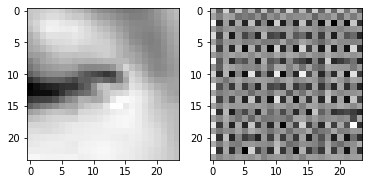

1 0.05239575728774071
2 0.04105580598115921
3 0.037676651030778885
4 0.033290162682533264
5 0.028823567554354668
6 0.028192659839987755
7 0.026441864669322968
8 0.024344483390450478
9 0.025014569982886314
10 0.02385885827243328


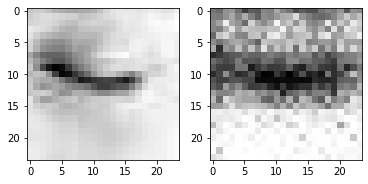

11 0.021658727899193764
12 0.027009466663002968
13 0.022737521678209305
14 0.01735335774719715
15 0.02254999615252018
16 0.022704921662807465
17 0.020581092685461044
18 0.019845101982355118
19 0.019571268931031227
20 0.02030005492269993


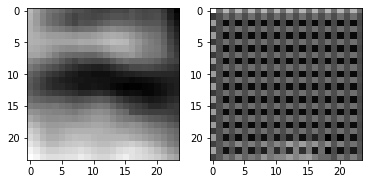

21 0.018863296136260033
22 0.01870366744697094
23 0.019939765334129333
24 0.017281420528888702
25 0.017987003549933434
26 0.017250239849090576
27 0.017110731452703476
28 0.016703013330698013
29 0.011657802388072014
30 0.01901434361934662


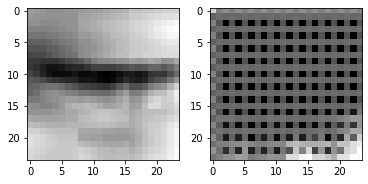

31 0.01441503781825304
32 0.015501982532441616
33 0.017085948958992958
34 0.015674075111746788
35 0.014736230485141277
36 0.014242500066757202
37 0.014714577235281467
38 0.013948950916528702
39 0.012749859131872654
40 0.012917173095047474


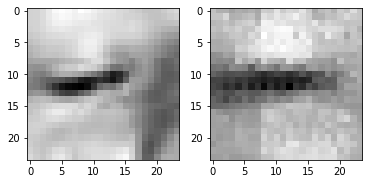

41 0.012696863152086735
42 0.013499816879630089
43 0.012030047364532948
44 0.011135399341583252
45 0.01641339808702469
46 0.013368071988224983
47 0.01333523914217949
48 0.01399308629333973
49 0.010898481123149395
50 0.013917086645960808


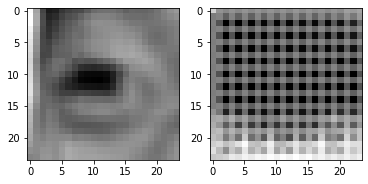

51 0.010781500488519669
52 0.011704746633768082
53 0.01225612685084343
54 0.011139673180878162
55 0.011129704304039478
56 0.01091283094137907
57 0.011112671345472336
58 0.010366338305175304
59 0.01233579870313406
60 0.012076673097908497


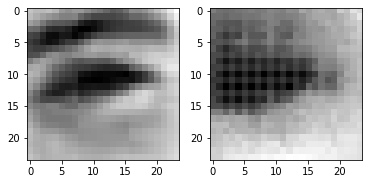

61 0.01029836293309927
62 0.011994955129921436
63 0.010797405615448952
64 0.012853479944169521
65 0.010106515139341354
66 0.009943422861397266
67 0.012818080373108387
68 0.0103048887103796
69 0.012262141332030296
70 0.011102533899247646


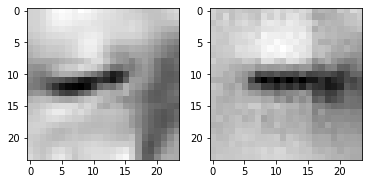

71 0.009938827715814114
72 0.01113868411630392
73 0.011194383725523949
74 0.013846001587808132
75 0.017198586836457253
76 0.010318583808839321
77 0.010435469448566437
78 0.011368107050657272
79 0.011549912393093109
80 0.00996448379009962


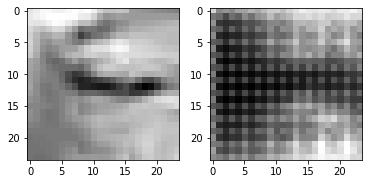

81 0.01092340424656868
82 0.009993165731430054
83 0.010274752043187618
84 0.010349255055189133
85 0.010914863087236881
86 0.010554060339927673
87 0.009631382301449776
88 0.00993718858808279
89 0.010804777033627033
90 0.012728105299174786


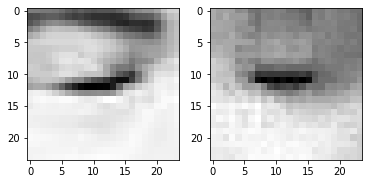

91 0.010830004699528217
92 0.00980699248611927
93 0.009830760769546032
94 0.01109535712748766
95 0.008911175653338432
96 0.009915451519191265
97 0.0098043167963624
98 0.009640759788453579
99 0.008602083660662174
100 0.009184279479086399


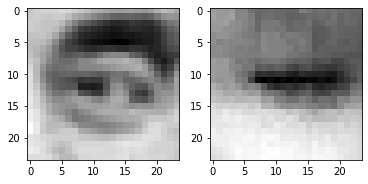

101 0.010050931945443153
102 0.008633779361844063
103 0.008993822149932384
104 0.010003061965107918
105 0.0106468191370368
106 0.009748773649334908
107 0.009174433536827564
108 0.010713018476963043
109 0.009816552512347698
110 0.008795303292572498


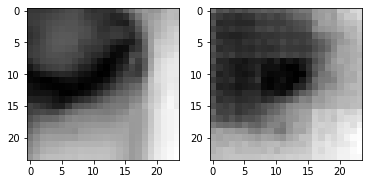

111 0.009882885031402111
112 0.009209895506501198
113 0.008169849403202534
114 0.009474022313952446
115 0.008448481559753418
116 0.008681253530085087
117 0.00840189028531313
118 0.00902729481458664
119 0.0060937912203371525
120 0.008244876749813557


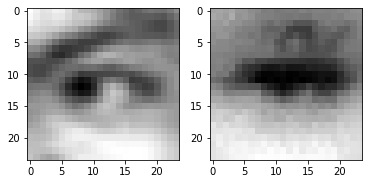

121 0.008449476212263107
122 0.008447633124887943
123 0.008262906223535538
124 0.0078889774158597
125 0.008851299062371254
126 0.00802921038120985
127 0.00813065841794014
128 0.007764781359583139
129 0.007794803474098444
130 0.008369178511202335


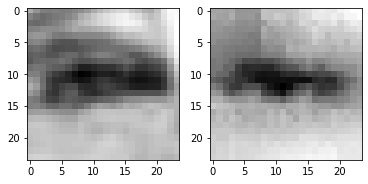

131 0.00733430590480566
132 0.00770805636420846
133 0.008150395937263966
134 0.010011603124439716
135 0.00755620002746582
136 0.007769522722810507
137 0.007255785167217255
138 0.007707579992711544
139 0.007844652980566025
140 0.00726611353456974


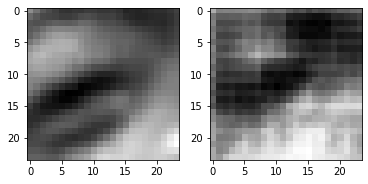

141 0.007691459730267525
142 0.0074548134580254555
143 0.007228035945445299
144 0.007630898617208004
145 0.0077301329001784325
146 0.007334268651902676
147 0.00730292359367013
148 0.007425785064697266
149 0.008688751608133316
150 0.007920792326331139


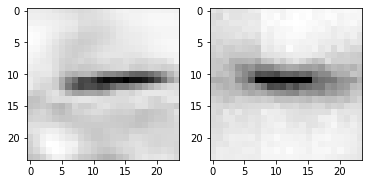

151 0.008156446740031242
152 0.007518408354371786
153 0.008014787919819355
154 0.0076742032542824745
155 0.008185656741261482
156 0.008152663707733154
157 0.007807171903550625
158 0.007234188262373209
159 0.007112754043191671
160 0.009666969068348408


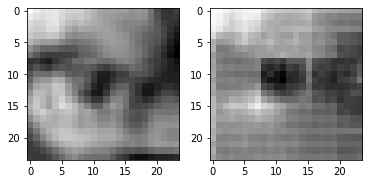

161 0.006625853944569826
162 0.007334367372095585
163 0.009095274843275547
164 0.0057802628725767136
165 0.007542555686086416
166 0.00746177788823843
167 0.00744187505915761
168 0.007031937595456839
169 0.0068671307526528835
170 0.007303929887712002


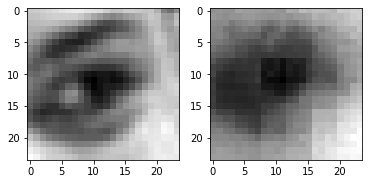

171 0.007029925938695669
172 0.007420035544782877
173 0.006776849739253521
174 0.006611949298530817
175 0.00710094952955842
176 0.006801294162869453
177 0.006192211527377367
178 0.00619885791093111
179 0.0070668854750692844
180 0.006341572385281324


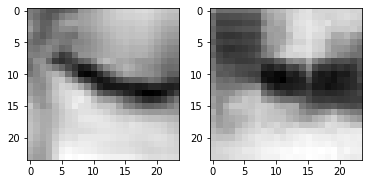

181 0.006905778311192989
182 0.006663408130407333
183 0.006680727936327457
184 0.006793261040002108
185 0.007079476490616798
186 0.006184149067848921
187 0.006631824187934399
188 0.006223367527127266
189 0.0071639567613601685
190 0.006432820111513138


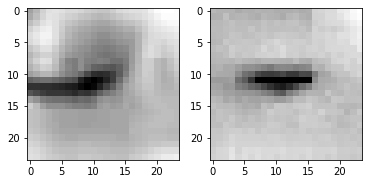

191 0.00600526062771678
192 0.0063054622150957584
193 0.00728413974866271
194 0.008131657727062702
195 0.007738146465271711
196 0.007906969636678696
197 0.007065044716000557
198 0.006212523207068443
199 0.006674813572317362
200 0.0076216403394937515


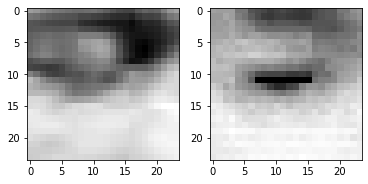

201 0.0068863690830767155
202 0.0067665004171431065
203 0.007090537343174219
204 0.006059734616428614
205 0.00627539586275816
206 0.005838750395923853
207 0.007077953312546015
208 0.0060938820242881775
209 0.009784956462681293
210 0.007346880156546831


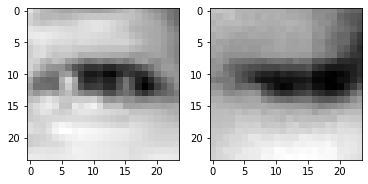

211 0.006432074587792158
212 0.006194462534040213
213 0.006023051682859659
214 0.006416477728635073
215 0.006576297804713249
216 0.005904724355787039
217 0.006649562623351812
218 0.006065968424081802
219 0.006375215016305447
220 0.005760154686868191


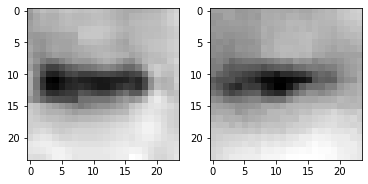

221 0.006062788423150778
222 0.00648206053301692
223 0.005265576299279928
224 0.007920371368527412
225 0.006902806926518679
226 0.006454289425164461
227 0.006075376644730568
228 0.006048315204679966
229 0.005855570547282696
230 0.0063405162654817104


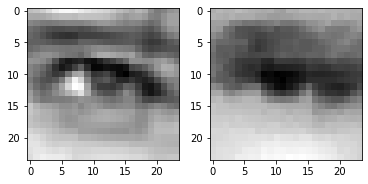

231 0.0063616447150707245
232 0.006242670118808746
233 0.005770034156739712
234 0.0069320290349423885
235 0.005910116247832775
236 0.005534190684556961
237 0.006085702683776617
238 0.00587675953283906
239 0.007610073778778315
240 0.005939142778515816


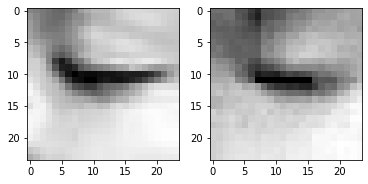

241 0.00602596253156662
242 0.007514942903071642
243 0.005678872112184763
244 0.00805307924747467
245 0.0074744331650435925
246 0.005948743782937527
247 0.00718689477071166
248 0.006688675377517939
249 0.00768649484962225
250 0.007390730082988739


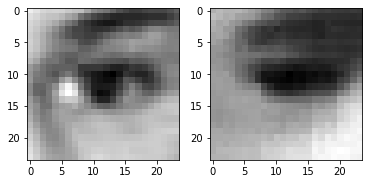

251 0.007970583625137806
252 0.0063692242838442326
253 0.006030082702636719
254 0.01836421899497509
255 0.006206990219652653
256 0.01006239838898182
257 0.0073805516585707664
258 0.007045953534543514
259 0.007585558574646711
260 0.007708298042416573


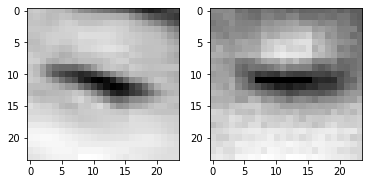

261 0.006778473500162363
262 0.007314940448850393
263 0.006390403490513563
264 0.0060959248803555965
265 0.006794617045670748
266 0.006365092936903238
267 0.0062548150308430195
268 0.006149778608232737
269 0.008347813040018082
270 0.008396731689572334


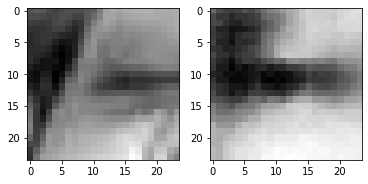

271 0.006238845642656088
272 0.006028721109032631
273 0.007171713747084141
274 0.005817115306854248
275 0.006562116090208292
276 0.006280629429966211
277 0.0064171538688242435
278 0.005877944640815258
279 0.005314996931701899
280 0.005710368510335684


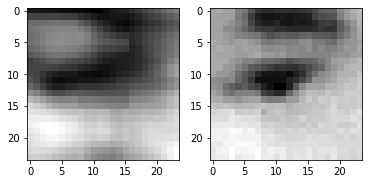

281 0.005817821715027094
282 0.00548400217667222
283 0.005067845340818167
284 0.0068494477309286594
285 0.005337799433618784
286 0.005477630067616701
287 0.005719447508454323
288 0.005467402748763561
289 0.00550431851297617
290 0.00530075142160058


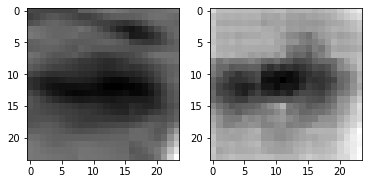

291 0.0051844255067408085
292 0.005871715489774942
293 0.005168867763131857
294 0.005485815461724997
295 0.0057343230582773685
296 0.004721845034509897
297 0.005403532646596432
298 0.005117257125675678
299 0.007198924198746681
300 0.005698552820831537


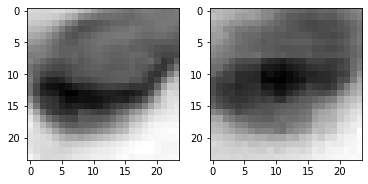

301 0.006315248552709818
302 0.005643900483846664
303 0.005343527998775244
304 0.005908563733100891
305 0.005589223466813564
306 0.004938943777233362
307 0.0051612998358905315
308 0.005242215935140848
309 0.005785650108009577
310 0.005066876765340567


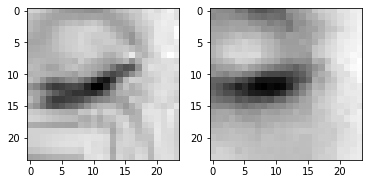

311 0.005720316898077726
312 0.00551102077588439
313 0.00571292033419013
314 0.008985428139567375
315 0.005984803196042776
316 0.00579800084233284
317 0.0060348198749125
318 0.005443844478577375
319 0.005413691978901625
320 0.0059739830903708935


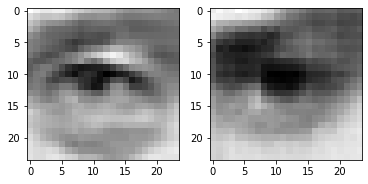

321 0.005596931558102369
322 0.005235864780843258
323 0.007029450498521328
324 0.005216998513787985
325 0.005235012620687485
326 0.006200017873197794
327 0.0059130750596523285
328 0.004990838933736086
329 0.007738437969237566
330 0.005489433649927378


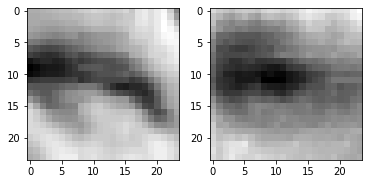

331 0.006213420536369085
332 0.005470404867082834
333 0.004792461637407541
334 0.005502715706825256
335 0.005934121552854776
336 0.005274702794849873
337 0.0049655865877866745
338 0.004932316020131111
339 0.005181789398193359
340 0.004980527330189943


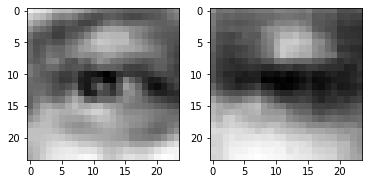

341 0.005298141855746508
342 0.0053332047536969185
343 0.00501797953620553
344 0.007661665324121714
345 0.005022550467401743
346 0.005763223394751549
347 0.005578095559030771
348 0.0049027856439352036
349 0.004748175386339426
350 0.004991220775991678


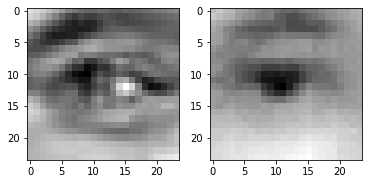

351 0.005300311371684074
352 0.005418997723609209
353 0.005072357598692179
354 0.00526099419221282
355 0.0055718026123940945
356 0.005692008882761002
357 0.0052200728096067905
358 0.006384691689163446
359 0.00618742173537612
360 0.0053609139285981655


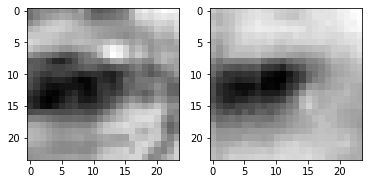

361 0.005857332143932581
362 0.005774320103228092
363 0.004736616276204586
364 0.006412091664969921
365 0.005109811667352915
366 0.004875042475759983
367 0.004948925692588091
368 0.005173256620764732
369 0.005982277914881706
370 0.00471862917765975


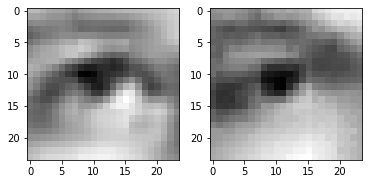

371 0.004871792625635862
372 0.005503090098500252
373 0.005207996815443039
374 0.006597823463380337
375 0.005041888449341059
376 0.005138445645570755
377 0.005423272494226694
378 0.00578159699216485
379 0.004544233437627554
380 0.005367951467633247


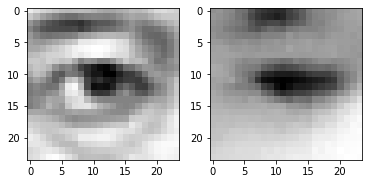

381 0.004885020200163126
382 0.0047767856158316135
383 0.0047907596454024315
384 0.005197927355766296
385 0.0047167036682367325
386 0.00452851876616478
387 0.00463292608037591
388 0.0054486459121108055
389 0.006075108423829079
390 0.004912699572741985


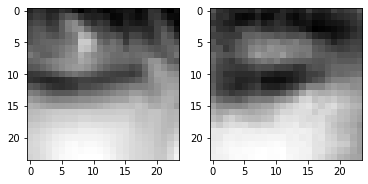

391 0.004357346333563328
392 0.0050048804841935635
393 0.004815550986677408
394 0.004680017475038767
395 0.004662733990699053
396 0.005095877684652805
397 0.004815457388758659
398 0.005064766388386488
399 0.004124413710087538
400 0.004276858177036047


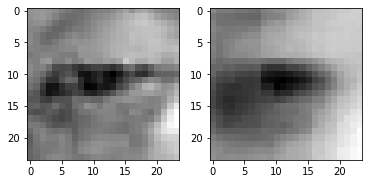

401 0.004344040993601084
402 0.004623936489224434
403 0.005101850721985102
404 0.0064302850514650345
405 0.005826493259519339
406 0.00532468082383275
407 0.00534237502142787
408 0.004770767875015736
409 0.004659485537558794
410 0.006205950863659382


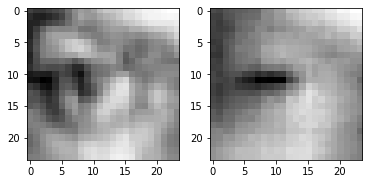

411 0.004865832161158323
412 0.005011900793761015
413 0.00454996433109045
414 0.004629821050912142
415 0.004607994109392166
416 0.004843041300773621
417 0.0052026924677193165
418 0.004952946212142706
419 0.0068298811092972755
420 0.0046208705753088


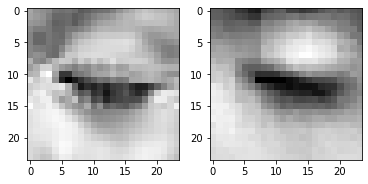

421 0.005250005517154932
422 0.005834086332470179
423 0.005017669405788183
424 0.005198122467845678
425 0.004777965601533651
426 0.004501504357904196
427 0.005006386432796717
428 0.005123963113874197
429 0.004676687065511942
430 0.0046385303139686584


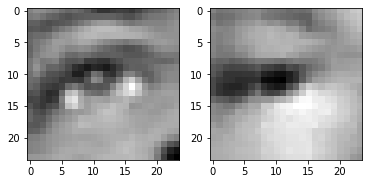

431 0.004620361141860485
432 0.00440599862486124
433 0.004873192403465509
434 0.005838037468492985
435 0.00484061986207962
436 0.004887017887085676
437 0.004581022076308727
438 0.00494057172909379
439 0.004792558494955301
440 0.004623299464583397


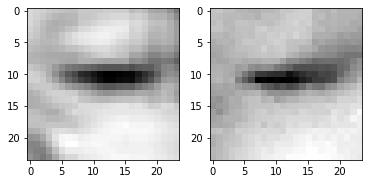

441 0.005361632909625769
442 0.004535316955298185
443 0.006074963603168726
444 0.004641564562916756
445 0.004380686208605766
446 0.004978745244443417
447 0.004224948585033417
448 0.0046883681789040565
449 0.003855473594740033
450 0.004331571515649557


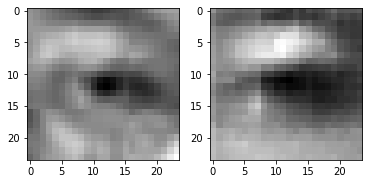

451 0.004538755398243666
452 0.00421338202431798
453 0.0047347405925393105
454 0.004507085308432579
455 0.004358332138508558
456 0.004145175684243441
457 0.005104148294776678
458 0.003742215922102332
459 0.00485397269949317
460 0.0050859902985394


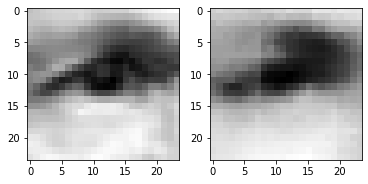

461 0.004532220307737589
462 0.004812760278582573
463 0.005113785620778799
464 0.0037330302875488997
465 0.0046553295105695724
466 0.005245281849056482
467 0.005355995614081621
468 0.004621031694114208
469 0.004722669720649719
470 0.0048873573541641235


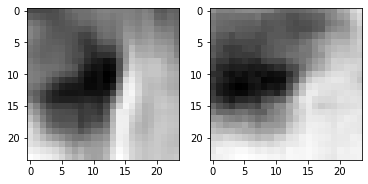

471 0.00591628672555089
472 0.004541142378002405
473 0.004234567284584045
474 0.00458972854539752
475 0.0057358755730092525
476 0.005037093069404364
477 0.004278273321688175
478 0.006013521924614906
479 0.0044144876301288605
480 0.004654217977076769


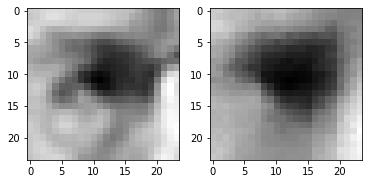

481 0.004420939367264509
482 0.004298694431781769
483 0.004483479540795088
484 0.004757300019264221
485 0.004050805699080229
486 0.004448404535651207
487 0.004453682340681553
488 0.0039957924745976925
489 0.004541977308690548
490 0.004494786728173494


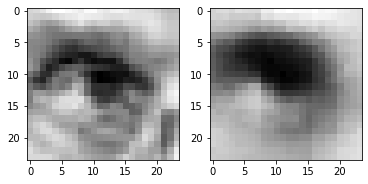

491 0.003930932376533747
492 0.003904269076883793
493 0.004281480330973864
494 0.005501683335751295
495 0.004658648278564215
496 0.00484640384092927
497 0.004427376668900251
498 0.00454992288723588
499 0.0039131916128098965
500 0.004561937879770994


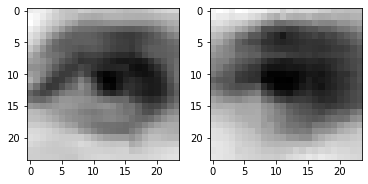

501 0.004388013854622841
502 0.004306018818169832
503 0.004481813404709101
504 0.0043547446839511395
505 0.004566698335111141
506 0.004436611197888851
507 0.004102179314941168
508 0.004105208907276392
509 0.006630416493862867
510 0.004562126938253641


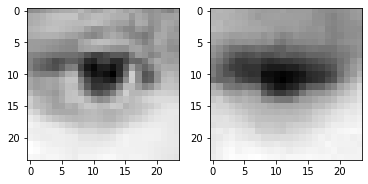

511 0.004158372059464455
512 0.005173162091523409
513 0.004850365221500397
514 0.004535031970590353
515 0.004673976916819811
516 0.004795527085661888
517 0.004603142384439707
518 0.004428761545568705
519 0.004644440487027168
520 0.004617579746991396


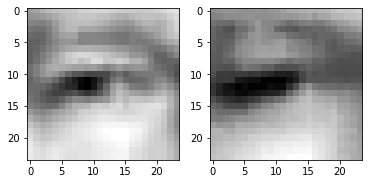

521 0.004657089710235596
522 0.004803564865142107
523 0.004206070676445961
524 0.004928416572511196
525 0.0043380120769143105
526 0.004488152917474508
527 0.004137007985264063
528 0.00409733597189188
529 0.004265825729817152
530 0.004076553508639336


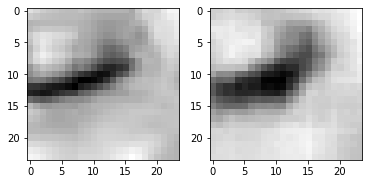

531 0.0040049427188932896
532 0.004234994295984507
533 0.0042469981126487255
534 0.004405088257044554
535 0.004287258256226778
536 0.004482963588088751
537 0.003705462208017707
538 0.004260554909706116
539 0.005809650756418705
540 0.00405092304572463


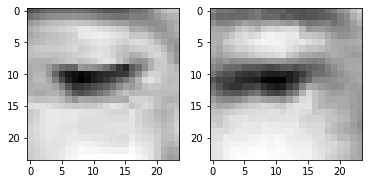

541 0.0038695568218827248
542 0.004829361103475094
543 0.0038860419299453497
544 0.004624208435416222
545 0.004223741590976715
546 0.0038694238755851984
547 0.0037862174212932587
548 0.004009719472378492
549 0.004192299675196409
550 0.0036733485758304596


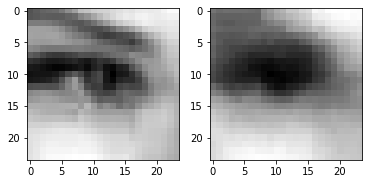

551 0.004025864414870739
552 0.004068354144692421
553 0.004334998782724142
554 0.007956252433359623
555 0.004368523135781288
556 0.004416569601744413
557 0.004244169220328331
558 0.004207840654999018
559 0.00410537188872695
560 0.003665679832920432


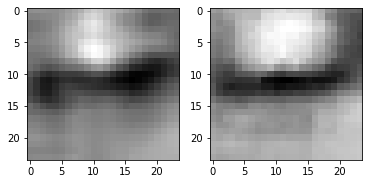

561 0.003800133941695094
562 0.0038003127556294203
563 0.004133504815399647
564 0.004061669576913118
565 0.003796173492446542
566 0.004171372391283512
567 0.003847123822197318
568 0.003950732760131359
569 0.005320785101503134
570 0.004168235696852207


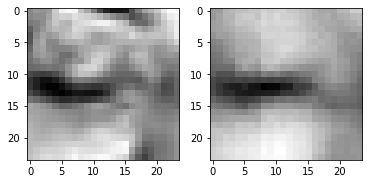

571 0.004710928536951542
572 0.004374620504677296
573 0.004407140426337719
574 0.004149692133069038
575 0.004507115576416254
576 0.0044601294212043285
577 0.00457973126322031
578 0.0044358717277646065
579 0.003827436128631234
580 0.004286712501198053


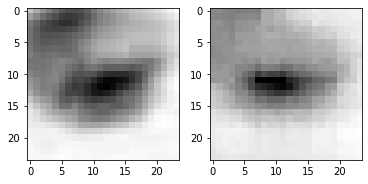

581 0.0038962066173553467
582 0.00400373013690114
583 0.004542603623121977
584 0.007084534503519535
585 0.005059380084276199
586 0.008987112902104855
587 0.005700663663446903
588 0.004431149456650019
589 0.0058473278768360615
590 0.004737457726150751


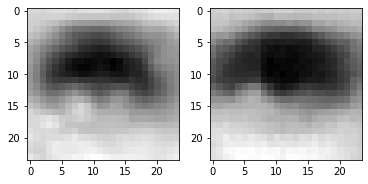

591 0.004269277211278677
592 0.004215267486870289
593 0.004802652634680271
594 0.004655756521970034
595 0.003851982532069087
596 0.004254316445440054
597 0.004391245543956757
598 0.004158603958785534
599 0.004437761846929789
600 0.004458664450794458


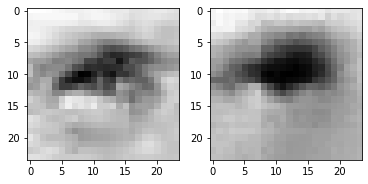

601 0.005197449121624231
602 0.004802043084055185
603 0.004871405195444822
604 0.005449495743960142
605 0.005613017361611128
606 0.00420653261244297
607 0.003862679935991764
608 0.004476902075111866
609 0.004873788915574551
610 0.004623419605195522


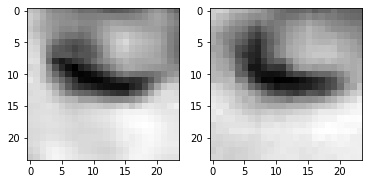

611 0.00391858397051692
612 0.0069162240251898766
613 0.004361695144325495
614 0.006629529874771833
615 0.0048182038590312
616 0.004199976101517677
617 0.004335438366979361
618 0.004377960227429867
619 0.00439412659034133
620 0.004085659049451351


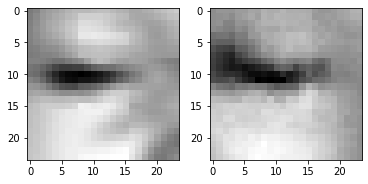

621 0.00444214791059494
622 0.003936236258596182
623 0.0038957942742854357
624 0.0041409083642065525
625 0.003918980713933706
626 0.00427229143679142
627 0.003916480578482151
628 0.003852140624076128
629 0.009869545698165894
630 0.0047713047824800014


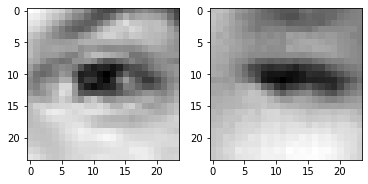

631 0.00477172527462244
632 0.004883914720267057
633 0.0038483855314552784
634 0.004956748802214861
635 0.003925996366888285
636 0.00525505980476737
637 0.004321359563618898
638 0.004680827725678682
639 0.005351260304450989
640 0.003987483214586973


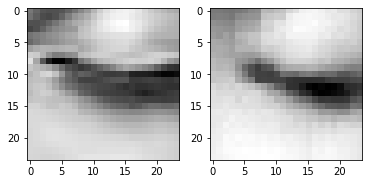

641 0.0039369938895106316
642 0.003670014441013336
643 0.003978337626904249
644 0.006203750614076853
645 0.004483909346163273
646 0.005278135184198618
647 0.004618841223418713
648 0.0038842398207634687
649 0.004966998007148504
650 0.004700629506260157


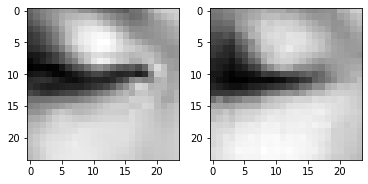

651 0.004264875315129757
652 0.0040671322494745255
653 0.004566476680338383
654 0.004499421454966068
655 0.004008318297564983
656 0.0038018114864826202
657 0.0038821168709546328
658 0.004080772865563631
659 0.0037919257301837206
660 0.0037127675022929907


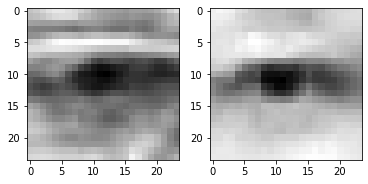

661 0.004076660610735416
662 0.0035882932133972645
663 0.0034738474059849977
664 0.003671290585771203
665 0.003715001977980137
666 0.0038286943454295397
667 0.0035376010928303003
668 0.0035193052608519793
669 0.003908555023372173
670 0.003709233831614256


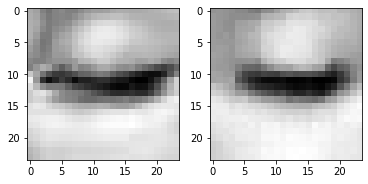

671 0.0036900313571095467
672 0.0036977215204387903
673 0.0032082677353173494
674 0.004630293231457472
675 0.0037074785213917494
676 0.003824543673545122
677 0.0037166178226470947
678 0.003651141654700041
679 0.0037722992710769176
680 0.0034426471684128046


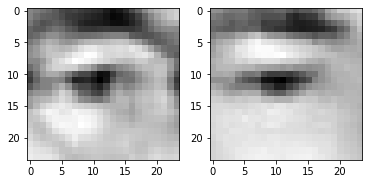

681 0.00320500903762877
682 0.003846318693831563
683 0.0034344280138611794
684 0.0034275129437446594
685 0.003832033136859536
686 0.0036228622775524855
687 0.0033107989002019167
688 0.0036743751261383295
689 0.004871787969022989
690 0.003966507036238909


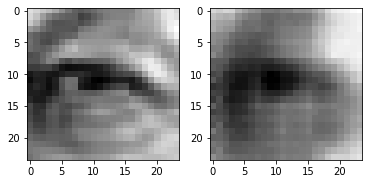

691 0.004178448114544153
692 0.004096141085028648
693 0.0037786352913826704
694 0.0038028976414352655
695 0.004429734777659178
696 0.004038326907902956
697 0.004221286159008741
698 0.005107572767883539
699 0.003551037749275565
700 0.003463253378868103


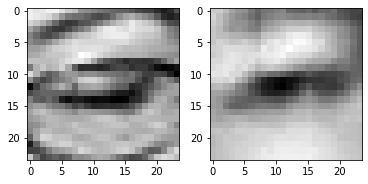

701 0.003896166803315282
702 0.004264031071215868
703 0.0035017712507396936
704 0.0046138884499669075
705 0.0034159973729401827
706 0.0033669054973870516
707 0.0036272474098950624
708 0.0036017633974552155
709 0.0038426045794039965
710 0.003988687414675951


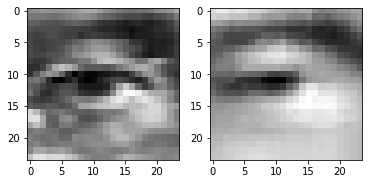

711 0.0044657266698777676
712 0.003413508413359523
713 0.004300867673009634
714 0.003941675648093224
715 0.004149590618908405
716 0.00376956001855433
717 0.004334055818617344
718 0.0033995057456195354
719 0.007717943750321865
720 0.0035507911816239357


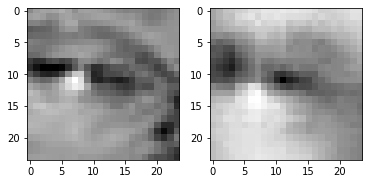

721 0.0034765745513141155
722 0.005157215055078268
723 0.004056939855217934
724 0.0034058040473610163
725 0.003985207993537188
726 0.003548761596903205
727 0.0034659970551729202
728 0.003771084826439619
729 0.0036343249958008528
730 0.003759692655876279


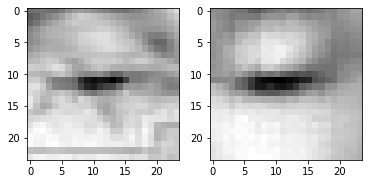

731 0.0033939119894057512
732 0.0041787270456552505
733 0.0033837135415524244
734 0.004703118000179529
735 0.005205985624343157
736 0.004795561544597149
737 0.005001483950763941
738 0.003618116956204176
739 0.00428700540214777
740 0.005300851073116064


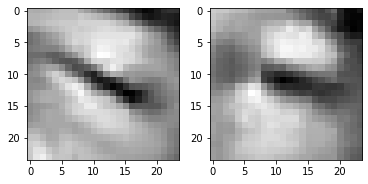

741 0.003745726775377989
742 0.0033452589996159077
743 0.004575861617922783
744 0.004323904402554035
745 0.0036982179153710604
746 0.003547190921381116
747 0.004252724349498749
748 0.004329080227762461
749 0.004118933342397213
750 0.0038694601971656084


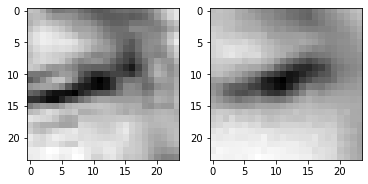

751 0.003668981371447444
752 0.003573731519281864
753 0.0037181482184678316
754 0.003574009984731674
755 0.003729701042175293
756 0.0035610769409686327
757 0.0036301042418926954
758 0.004209182690829039
759 0.003132933285087347
760 0.0036308446433395147


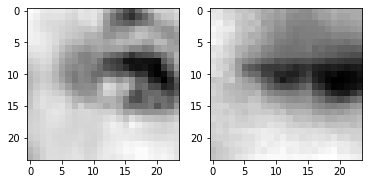

761 0.004534349776804447
762 0.0036967326886951923
763 0.0033870188053697348
764 0.004593061748892069
765 0.004109195899218321
766 0.0061945365741848946
767 0.004193900618702173
768 0.0040440489538013935
769 0.0038686038460582495
770 0.004002176225185394


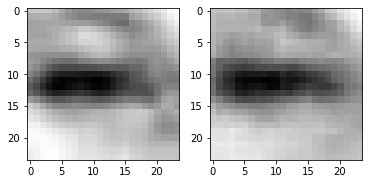

771 0.0035305614583194256
772 0.0037627231795340776
773 0.0035411417484283447
774 0.0040742987766861916
775 0.003940955735743046
776 0.004220160190016031
777 0.003275272436439991
778 0.004937834106385708
779 0.0065276846289634705
780 0.0037967960815876722


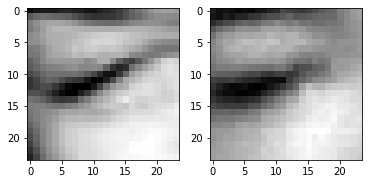

781 0.0039027375169098377
782 0.004626020789146423
783 0.00517931766808033
784 0.0037734960205852985
785 0.0037643685936927795
786 0.0061409049667418
787 0.006134550552815199
788 0.003924789372831583
789 0.004205986857414246
790 0.004244925454258919


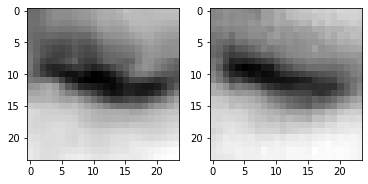

791 0.0037774157244712114
792 0.0034747098106890917
793 0.003818855620920658
794 0.005607014987617731
795 0.004450701177120209
796 0.003806570777669549
797 0.003915619570761919
798 0.00432604132220149
799 0.0038539383094757795
800 0.003405030583962798


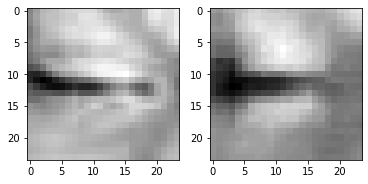

801 0.0035682108718901873
802 0.003599983174353838
803 0.0033087495248764753
804 0.003463831963017583
805 0.003518278943374753
806 0.004064891487360001
807 0.00334343989379704
808 0.0035391661804169416
809 0.004317614249885082
810 0.0035194228403270245


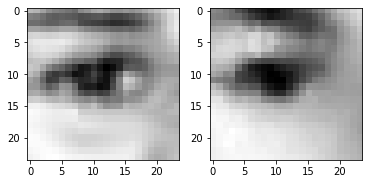

811 0.003752910066395998
812 0.003555550007149577
813 0.003634848864749074
814 0.003926475998014212
815 0.0035136949736624956
816 0.003332847962155938
817 0.004861712921410799
818 0.003228427143767476
819 0.0032955047208815813
820 0.00280985445715487


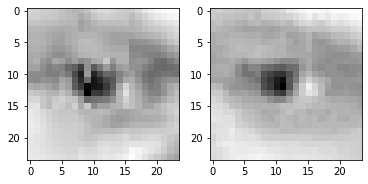

821 0.004467188846319914
822 0.0032278429716825485
823 0.0031167343258857727
824 0.005947558209300041
825 0.003158882260322571
826 0.003779218066483736
827 0.00390113634057343
828 0.0035595919471234083
829 0.0034792812075465918
830 0.003233605530112982


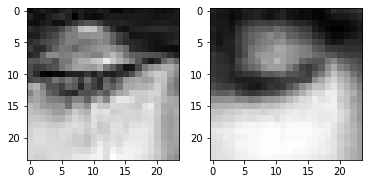

831 0.003564371494576335
832 0.004559096414595842
833 0.003528422908857465
834 0.00324215367436409
835 0.0037822015583515167
836 0.003468238515779376
837 0.003962567541748285
838 0.003111977595835924
839 0.004448695573955774
840 0.004310596268624067


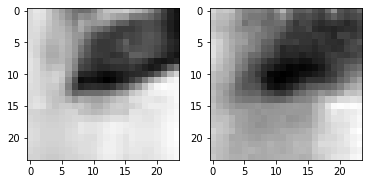

841 0.005473377648741007
842 0.004494844004511833
843 0.0033923585433512926
844 0.0038710609078407288
845 0.003906361758708954
846 0.004860231652855873
847 0.0044723195023834705
848 0.0036898755934089422
849 0.003538236953318119
850 0.004462418612092733


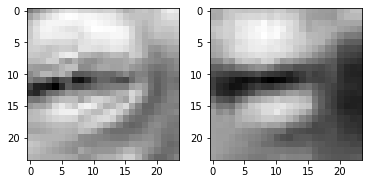

851 0.00472945487126708
852 0.003632481675595045
853 0.004202092532068491
854 0.006656611803919077
855 0.003798720659688115
856 0.0038418592885136604
857 0.003886760910972953
858 0.0035640986170619726
859 0.003540606936439872
860 0.003634825348854065


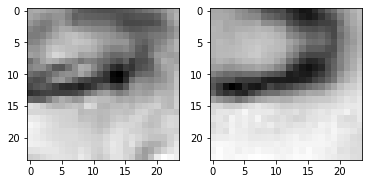

861 0.0034119102638214827
862 0.003481063526123762
863 0.003935457672923803
864 0.003514658659696579
865 0.003332562046125531
866 0.0034143461380153894
867 0.0035816882736980915
868 0.003815353848040104
869 0.004994692746549845
870 0.004651165567338467


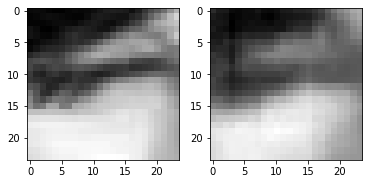

871 0.0036783600226044655
872 0.003922643605619669
873 0.0036211498081684113
874 0.004075273405760527
875 0.003209346206858754
876 0.003246788401156664
877 0.0032903088722378016
878 0.0036044050939381123
879 0.0036175090353935957
880 0.0033510446082800627


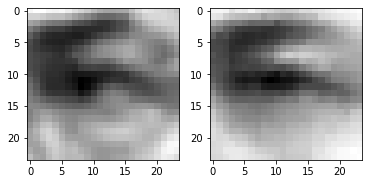

881 0.0031173336319625378
882 0.0033921024296432734
883 0.003256739117205143
884 0.0038626252207905054
885 0.004735844675451517
886 0.004889671690762043
887 0.004132948350161314
888 0.0037563915830105543
889 0.0036941387224942446
890 0.004189281724393368


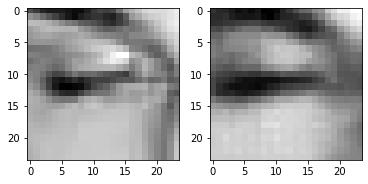

891 0.004432463087141514
892 0.003307612845674157
893 0.00327097880654037
894 0.0034699789248406887
895 0.0035425620153546333
896 0.004179293289780617
897 0.003586911829188466
898 0.0033562288153916597
899 0.004654929973185062
900 0.003823261009529233


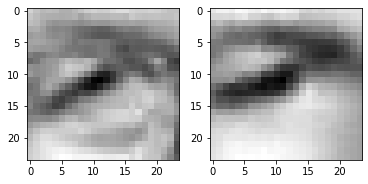

901 0.003233569674193859
902 0.003503140527755022
903 0.004149383865296841
904 0.00400584377348423
905 0.0032403229270130396
906 0.0037407022900879383
907 0.003823791164904833
908 0.003635779954493046
909 0.0030727789271622896
910 0.0033227514941245317


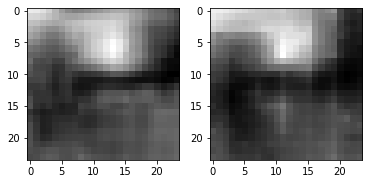

911 0.003467205911874771
912 0.003389738965779543
913 0.0032457413617521524
914 0.008683362975716591
915 0.004384865518659353
916 0.007417991757392883
917 0.004004323855042458
918 0.0034688804298639297
919 0.004925243556499481
920 0.0037572504952549934


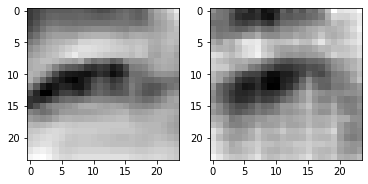

921 0.0038301146123558283
922 0.0034847308415919542
923 0.0035459415521472692
924 0.003779768943786621
925 0.0034420390147715807
926 0.003769879462197423
927 0.0035662229638546705
928 0.0032529563177376986
929 0.0050084698013961315
930 0.004242653492838144


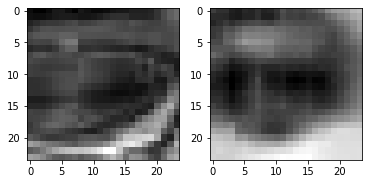

931 0.0033758762292563915
932 0.003555501578375697
933 0.003489892464131117
934 0.0031214007176458836
935 0.0034607318229973316
936 0.0035325170028954744
937 0.003190929302945733
938 0.0035788342356681824
939 0.0032546103466302156
940 0.003029197920113802


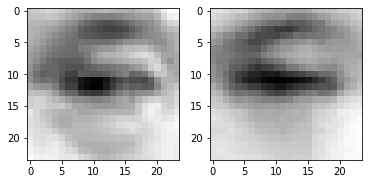

941 0.003333674743771553
942 0.003387667704373598
943 0.002969138789921999
944 0.00394420837983489
945 0.003199297236278653
946 0.003257296746596694
947 0.0032970504835247993
948 0.002989983418956399
949 0.003115921514108777
950 0.0032605426385998726


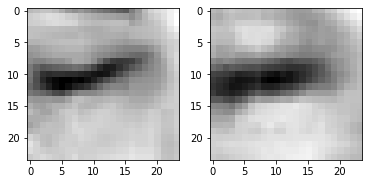

951 0.002929054433479905
952 0.0032654295209795237
953 0.0032136254012584686
954 0.003848912427201867
955 0.002604740671813488
956 0.003075557528063655
957 0.002964985789731145
958 0.002998322481289506
959 0.004932001233100891
960 0.0033716203179210424


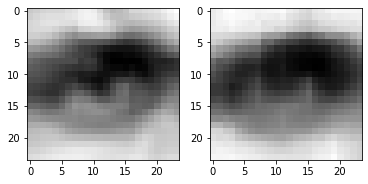

961 0.0035464635584503412
962 0.003234833013266325
963 0.0031810945365577936
964 0.0029344302602112293
965 0.003559185890480876
966 0.0029919412918388844
967 0.0030287557747215033
968 0.002904453780502081
969 0.003453028155490756
970 0.0038117701187729836


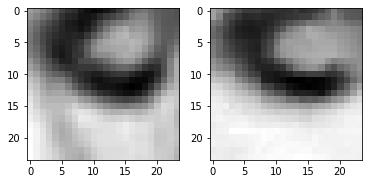

971 0.0029382219072431326
972 0.0031100516207516193
973 0.002980018500238657
974 0.004780258517712355
975 0.003238781588152051
976 0.004203252028673887
977 0.0037523098289966583
978 0.0036937627010047436
979 0.00472660455852747
980 0.0030638084281235933


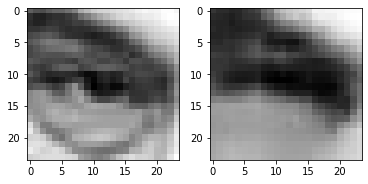

981 0.0032005510292947292
982 0.003386941971257329
983 0.003011214779689908
984 0.0027457105461508036
985 0.0029654467944055796
986 0.0031575581524521112
987 0.00304796127602458
988 0.002821957226842642
989 0.005456279963254929
990 0.0034082275815308094


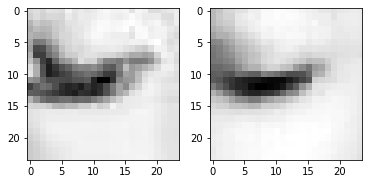

991 0.005475868005305529
992 0.0045392164029181
993 0.0029320635367184877
994 0.003597587812691927
995 0.004083955194801092
996 0.004787055309861898
997 0.0033396007493138313
998 0.003186238696798682
999 0.004181854426860809
1000 0.004028649069368839


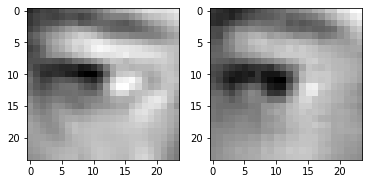

1001 0.0029919154476374388
1002 0.0031911812257021666
1003 0.0031102995853871107
1004 0.007737975101917982
1005 0.0033850620966404676
1006 0.0034926612861454487
1007 0.0040624928660690784
1008 0.0037214159965515137
1009 0.0039446065202355385
1010 0.003485076129436493


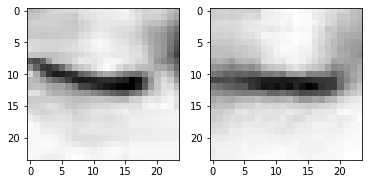

1011 0.0035636036191135645
1012 0.004094836767762899
1013 0.0036680421326309443
1014 0.0031384651083499193
1015 0.00352972699329257
1016 0.0034885890781879425
1017 0.0035397671163082123
1018 0.00377149460837245
1019 0.008123816922307014
1020 0.004219352267682552


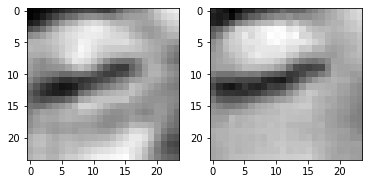

1021 0.00605039345100522
1022 0.005636237561702728
1023 0.0038121454417705536
1024 0.003875448601320386
1025 0.005444003269076347
1026 0.004866710864007473
1027 0.004044723697006702
1028 0.0035873246379196644
1029 0.004200753290206194
1030 0.003975538071244955


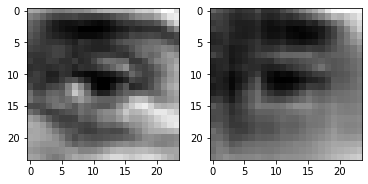

1031 0.003961800131946802
1032 0.003519895253702998
1033 0.0035604999866336584
1034 0.008877490647137165
1035 0.0035436053294688463
1036 0.004198148846626282
1037 0.0038946419954299927
1038 0.003954654093831778
1039 0.004321740940213203
1040 0.003566506551578641


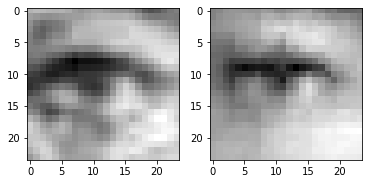

1041 0.003254704410210252
1042 0.003780156373977661
1043 0.0034264440182596445
1044 0.003565971739590168
1045 0.0032081929966807365
1046 0.0032029692083597183
1047 0.0035148081369698048
1048 0.0043154084123671055
1049 0.005969460587948561
1050 0.003285126993432641


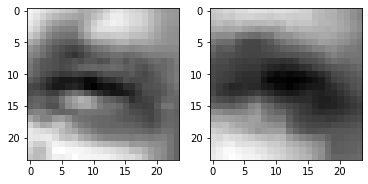

1051 0.0041962903924286366
1052 0.003774872748181224
1053 0.004049666225910187
1054 0.003125470131635666
1055 0.0030154765117913485
1056 0.003462555818259716
1057 0.005974832456558943
1058 0.0033440168481320143
1059 0.002965485444292426
1060 0.0034434006083756685


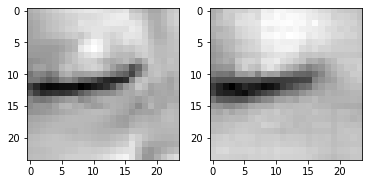

1061 0.0033800334203988314
1062 0.003288154723122716
1063 0.003049041610211134
1064 0.00366361066699028
1065 0.0031437629368156195
1066 0.002880245912820101
1067 0.0028522061184048653
1068 0.0030540938023477793
1069 0.002737496281042695
1070 0.0027416679076850414


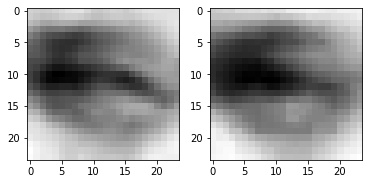

1071 0.0027302801609039307
1072 0.0029792904388159513
1073 0.003877429524436593
1074 0.0029688996728509665
1075 0.0029645897448062897
1076 0.0029675953555852175
1077 0.0029638733249157667
1078 0.003355335211381316
1079 0.005810773931443691
1080 0.0031173001043498516


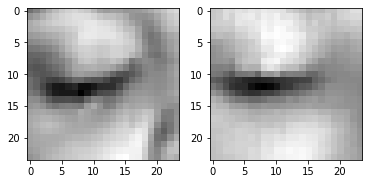

1081 0.003730006981641054
1082 0.003218552563339472
1083 0.0029842089861631393
1084 0.002882401691749692
1085 0.0030163086485117674
1086 0.0034376480616629124
1087 0.002969522960484028
1088 0.00318050105124712
1089 0.0033362817484885454
1090 0.003655193606391549


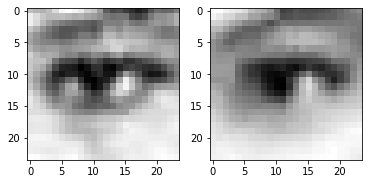

1091 0.0030765910632908344
1092 0.002723190700635314
1093 0.0036404388956725597
1094 0.004553693346679211
1095 0.003990015480667353
1096 0.003074402455240488
1097 0.0032463185489177704
1098 0.0031013507395982742
1099 0.003043095814064145
1100 0.0028176407795399427


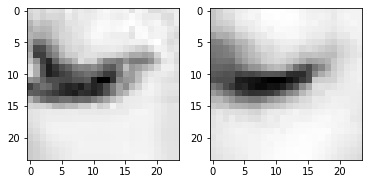

1101 0.0026948137674480677
1102 0.0030098012648522854
1103 0.002801179885864258
1104 0.003101288340985775
1105 0.0027679528575390577
1106 0.0031795368995517492
1107 0.003579271724447608
1108 0.0036931869108229876
1109 0.013436486944556236
1110 0.003255990566685796


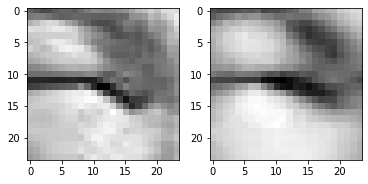

1111 0.004025634843856096
1112 0.004273502621799707
1113 0.0032460857182741165
1114 0.002981186378747225
1115 0.0036304809618741274
1116 0.003102497663348913
1117 0.0032197213731706142
1118 0.0035742144100368023
1119 0.0031851830426603556
1120 0.002711985958740115


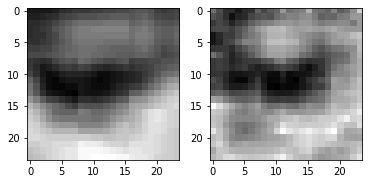

1121 0.0029458014760166407
1122 0.0032688770443201065
1123 0.0029178191907703876
1124 0.0044191693887114525
1125 0.002837005304172635
1126 0.0032125706784427166
1127 0.0031885073985904455
1128 0.0028769008349627256
1129 0.003094935091212392
1130 0.0028527018148452044


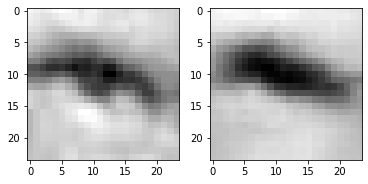

1131 0.0035006061661988497
1132 0.0025547523982822895
1133 0.0030157340224832296
1134 0.002885514637455344
1135 0.0028962455689907074
1136 0.002971047768369317
1137 0.0028885784558951855
1138 0.003013079985976219
1139 0.003711789846420288
1140 0.003528584260493517


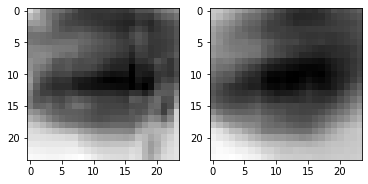

1141 0.003372229402884841
1142 0.003845025785267353
1143 0.0028407531790435314
1144 0.00277114799246192
1145 0.0031107966788113117
1146 0.0035087259020656347
1147 0.0028707601595669985
1148 0.00272013689391315
1149 0.003366070566698909
1150 0.0033082319423556328


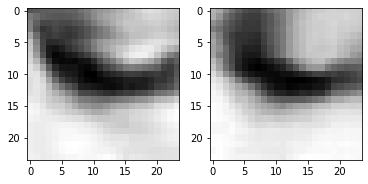

1151 0.003201243933290243
1152 0.002620216691866517
1153 0.004156143870204687
1154 0.005491636693477631
1155 0.0029323899652808905
1156 0.003132883459329605
1157 0.004374769050627947
1158 0.003709582844749093
1159 0.0029626076575368643
1160 0.003203530330210924


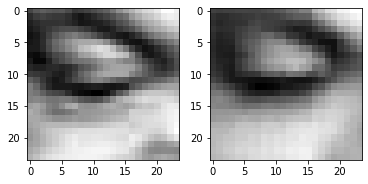

1161 0.003698732005432248
1162 0.0032153308857232332
1163 0.0029188701882958412
1164 0.004242488648742437
1165 0.0029837435577064753
1166 0.002758162561804056
1167 0.0026433963794261217
1168 0.0026577848475426435
1169 0.0059683723375201225
1170 0.003328559221699834


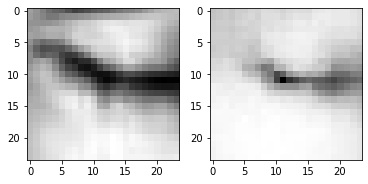

1171 0.0033228129614144564
1172 0.003169663017615676
1173 0.00293468264862895
1174 0.0028633836191147566
1175 0.003176408587023616
1176 0.0032681392040103674
1177 0.0033122680615633726
1178 0.003259052988141775
1179 0.004065752495080233
1180 0.0030110192019492388


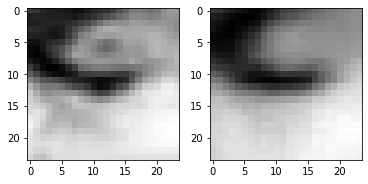

1181 0.003301773453131318
1182 0.002896652789786458
1183 0.003651510225608945
1184 0.008288079872727394
1185 0.0035926916170865297
1186 0.004056004341691732
1187 0.006919404026120901
1188 0.0035037945490330458
1189 0.0031373577658087015
1190 0.0031471753027290106


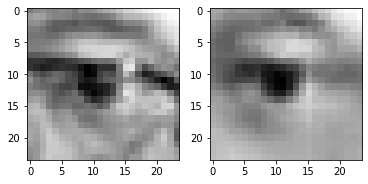

1191 0.0050985184498131275
1192 0.004361072089523077
1193 0.003333468921482563
1194 0.003099631518125534
1195 0.0032042176462709904
1196 0.0028243509586900473
1197 0.0029980004765093327
1198 0.0038812090642750263
1199 0.006444636732339859
1200 0.003495778888463974


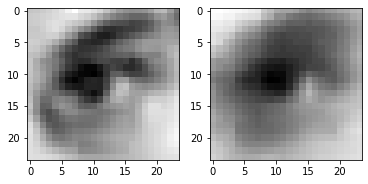

1201 0.0041467249393463135
1202 0.0031504230573773384
1203 0.0032871116418391466
1204 0.0036284816451370716
1205 0.003313829656690359
1206 0.003133849473670125
1207 0.0031158230267465115
1208 0.00301344390027225
1209 0.0032135015353560448
1210 0.003670924575999379


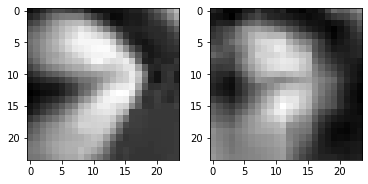

1211 0.003047412494197488
1212 0.003184273838996887
1213 0.003405659692361951
1214 0.0049242302775382996
1215 0.0031641442328691483
1216 0.003541575977578759
1217 0.0032225234899669886
1218 0.003101027337834239
1219 0.003119652858003974
1220 0.0032891305163502693


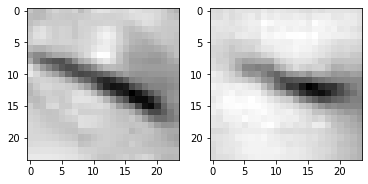

1221 0.003158632665872574
1222 0.002942225430160761
1223 0.0032181045971810818
1224 0.0032351776026189327
1225 0.0028969228733330965
1226 0.0030385314021259546
1227 0.002961670747026801
1228 0.003399801906198263
1229 0.004012296441942453
1230 0.002733679721131921


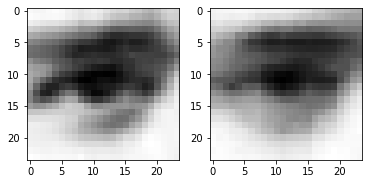

1231 0.0030430841725319624
1232 0.0028179355431348085
1233 0.0031098988838493824
1234 0.0028706651646643877
1235 0.002711276989430189
1236 0.003087476594373584
1237 0.0026760778855532408
1238 0.002760586328804493
1239 0.0031763252336531878
1240 0.0026473822072148323


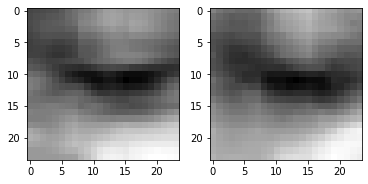

1241 0.0025089995469897985
1242 0.002821483416482806
1243 0.002592954318970442
1244 0.005324109923094511
1245 0.003078955691307783
1246 0.003457186510786414
1247 0.002799529116600752
1248 0.0033605226781219244
1249 0.002731490880250931
1250 0.0029885682743042707


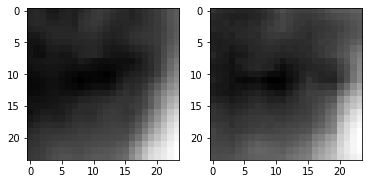

1251 0.0033671048004180193
1252 0.0028925102669745684
1253 0.0026483715046197176
1254 0.0025164643302559853
1255 0.0028021782636642456
1256 0.0026729675009846687
1257 0.0027401105035096407
1258 0.0025902963243424892
1259 0.006861547473818064
1260 0.0027829755563288927


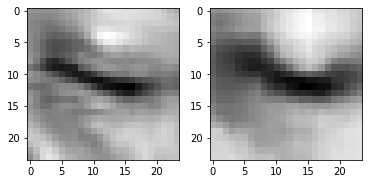

1261 0.004726267419755459
1262 0.0032107578590512276
1263 0.003212996991351247
1264 0.0027959684375673532
1265 0.003803211497142911
1266 0.00416170060634613
1267 0.0029450394213199615
1268 0.003228304209187627
1269 0.002684295643121004
1270 0.0028692055493593216


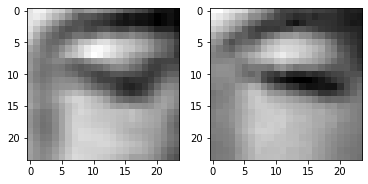

1271 0.002932172268629074
1272 0.0026344466023147106
1273 0.0027673328295350075
1274 0.005776145029813051
1275 0.0028293009381741285
1276 0.003963995724916458
1277 0.0029623869340866804
1278 0.002922216197475791
1279 0.002926821121945977
1280 0.0036861093249171972


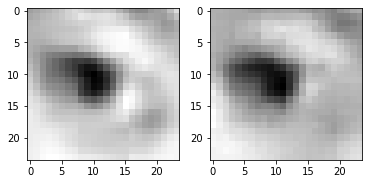

1281 0.0028944024816155434
1282 0.0028575172182172537
1283 0.003152528079226613
1284 0.003060390241444111
1285 0.0028987936675548553
1286 0.0033425225410610437
1287 0.0027361458633095026
1288 0.0028601400554180145
1289 0.005823163315653801
1290 0.0027778504882007837


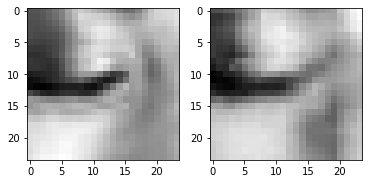

1291 0.0026531489565968513
1292 0.003404419869184494
1293 0.002941080601885915
1294 0.0035694167017936707
1295 0.002903782296925783
1296 0.003600865602493286
1297 0.002931106835603714
1298 0.002938430290669203
1299 0.0028320744168013334
1300 0.0031500468030571938


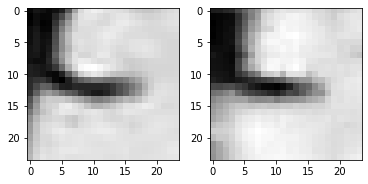

1301 0.0030445598531514406
1302 0.003247839165851474
1303 0.0027625386137515306
1304 0.007008750457316637
1305 0.0029851726721972227
1306 0.003556612879037857
1307 0.0036525018513202667
1308 0.0030369374435395002
1309 0.0025635696947574615
1310 0.0029592597857117653


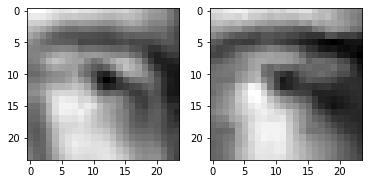

1311 0.0031013679690659046
1312 0.002849649405106902
1313 0.0032646458130329847
1314 0.0027887506876140833
1315 0.002843000926077366
1316 0.0029675569385290146
1317 0.002972930669784546
1318 0.002655832329764962
1319 0.0065455264411866665
1320 0.003112837905064225


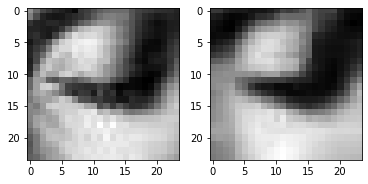

1321 0.0046156179159879684
1322 0.003209054237231612
1323 0.0029938253574073315
1324 0.003863480407744646
1325 0.002916057826951146
1326 0.003150956006720662
1327 0.002816893393173814
1328 0.0029579789843410254
1329 0.002841166453436017
1330 0.002773080952465534


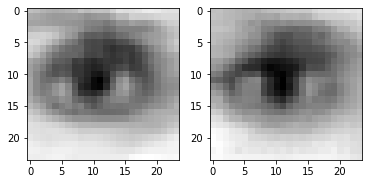

1331 0.0029722722247242928
1332 0.0031298163812607527
1333 0.002743679564446211
1334 0.007450804114341736
1335 0.004044550471007824
1336 0.006153522990643978
1337 0.0049394769594073296
1338 0.00346538913436234
1339 0.0032125443685799837
1340 0.004572755191475153


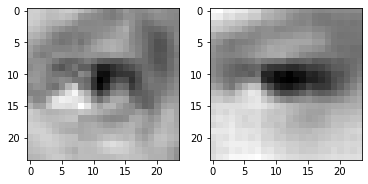

1341 0.004036455415189266
1342 0.0041222115978598595
1343 0.0039275893941521645
1344 0.0039141252636909485
1345 0.0039588687941432
1346 0.002890845062211156
1347 0.0033096158877015114
1348 0.0031535655725747347
1349 0.00474036717787385
1350 0.0035055242478847504


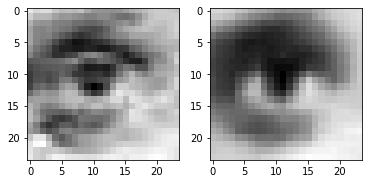

1351 0.0033963953610509634
1352 0.0035989219322800636
1353 0.0033746114932000637
1354 0.002975038718432188
1355 0.0037048417143523693
1356 0.004242792725563049
1357 0.0033632339909672737
1358 0.0027812430635094643
1359 0.0040000141598284245
1360 0.0036649852991104126


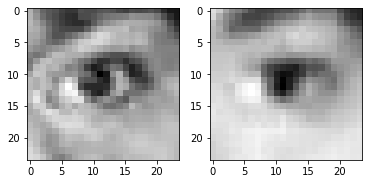

1361 0.002499940572306514
1362 0.0031385188922286034
1363 0.0031504444777965546
1364 0.00374826998449862
1365 0.0026632307562977076
1366 0.0033979478757828474
1367 0.0038205687887966633
1368 0.003284395206719637
1369 0.0031648059375584126
1370 0.0030820267274975777


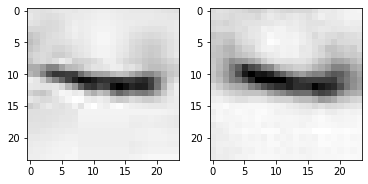

1371 0.0028206061106175184
1372 0.0032493467442691326
1373 0.0031055244617164135
1374 0.0029508788138628006
1375 0.003141404828056693
1376 0.0028438344597816467
1377 0.002784063806757331
1378 0.0029638041742146015
1379 0.004721383098512888
1380 0.0027170993853360415


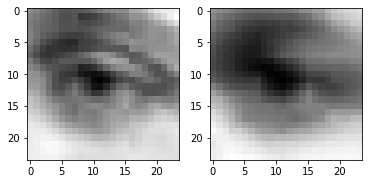

1381 0.0032747776713222265
1382 0.0035059754736721516
1383 0.0028226240538060665
1384 0.0026973874773830175
1385 0.0028968246188014746
1386 0.002866182941943407
1387 0.0027952799573540688
1388 0.0029368915129452944
1389 0.0029055338818579912
1390 0.002753176260739565


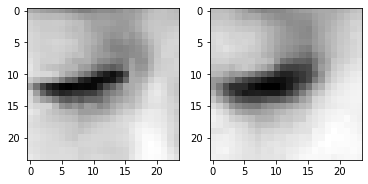

1391 0.0026144974399358034
1392 0.0030582568142563105
1393 0.0026309932582080364
1394 0.01215160172432661
1395 0.0028163024690002203
1396 0.003931018058210611
1397 0.004533098079264164
1398 0.0030002701096236706
1399 0.002783096395432949
1400 0.003190745133906603


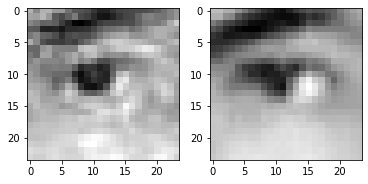

1401 0.0029939545784145594
1402 0.0031719282269477844
1403 0.0029831838328391314
1404 0.003345401957631111
1405 0.002932556439191103
1406 0.0028677370864897966
1407 0.002957562915980816
1408 0.003072436898946762
1409 0.0036502480506896973
1410 0.00302889384329319


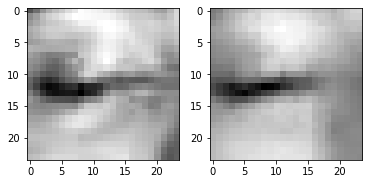

1411 0.0028807176277041435
1412 0.0028694451320916414
1413 0.002697225194424391
1414 0.0025979543570429087
1415 0.002624178770929575
1416 0.002861438086256385
1417 0.0026787715032696724
1418 0.002622467465698719
1419 0.0028614066541194916
1420 0.0026726170908659697


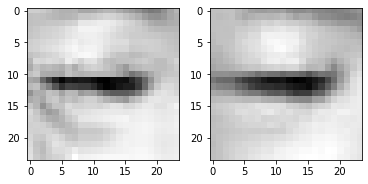

1421 0.0027550160884857178
1422 0.0025386817287653685
1423 0.002591372700408101
1424 0.004937408957630396
1425 0.0028808685019612312
1426 0.0027034361846745014
1427 0.0028511839918792248
1428 0.0027592622209340334
1429 0.002552443416789174
1430 0.00274490425363183


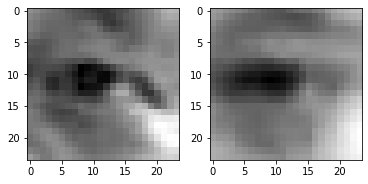

1431 0.002852116944268346
1432 0.002653231145814061
1433 0.0024588906671851873
1434 0.0027305542025715113
1435 0.002751660067588091
1436 0.0025815379340201616
1437 0.0025066500529646873
1438 0.0026345262303948402
1439 0.0028088269755244255
1440 0.0025608318392187357


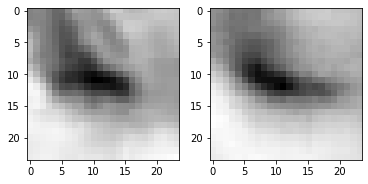

1441 0.0025749942287802696
1442 0.003021723125129938
1443 0.00293683260679245
1444 0.0024062932934612036
1445 0.002522772643715143
1446 0.002631055423989892
1447 0.003169731702655554
1448 0.0035897609777748585
1449 0.0031849900260567665
1450 0.003241253551095724


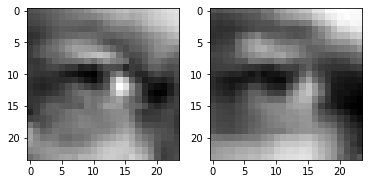

1451 0.003929775208234787
1452 0.003231670940294862
1453 0.0025643138214945793
1454 0.0045225415378808975
1455 0.0030597473960369825
1456 0.0025925582740455866
1457 0.0030723190866410732
1458 0.002913392847403884
1459 0.002749751089140773
1460 0.00296291196718812


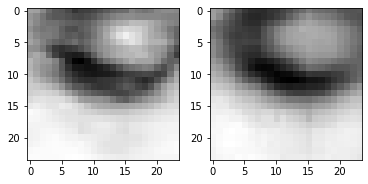

1461 0.00283035053871572
1462 0.002514642896130681
1463 0.0029702456668019295
1464 0.0026206960901618004
1465 0.0026471582241356373
1466 0.002901932690292597
1467 0.0029506750870496035
1468 0.0029308844823390245
1469 0.0052542611956596375
1470 0.0034363209269940853


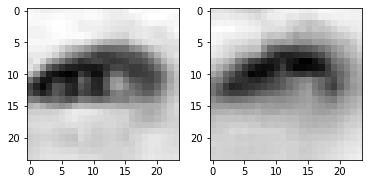

1471 0.00429471954703331
1472 0.003065356519073248
1473 0.0027940936852246523
1474 0.002899226965382695
1475 0.0028336867690086365
1476 0.0028453138656914234
1477 0.003552804933860898
1478 0.002651270478963852
1479 0.0026413246523588896
1480 0.0029062845278531313


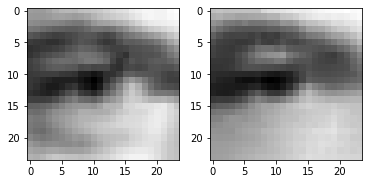

1481 0.003865020116791129
1482 0.0029579359106719494
1483 0.002598808379843831
1484 0.0038350422400981188
1485 0.0032460044603794813
1486 0.0030093698296695948
1487 0.002869741525501013
1488 0.002847223309800029
1489 0.002750377170741558
1490 0.0033850939944386482


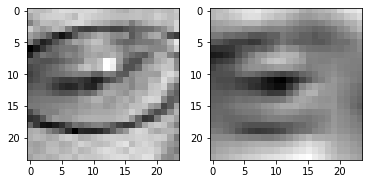

1491 0.002656336175277829
1492 0.0026914027985185385
1493 0.003327426500618458
1494 0.0032395117450505495
1495 0.003310840344056487
1496 0.002752525033429265
1497 0.002362023340538144
1498 0.002560249762609601
1499 0.0048277960158884525
1500 0.003215582575649023


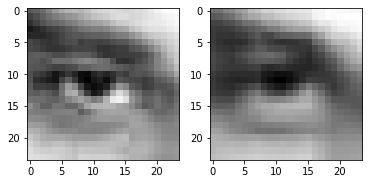

1501 0.0026903431862592697
1502 0.0025847377255558968
1503 0.003494327189400792
1504 0.0026897999923676252
1505 0.0024433513171970844
1506 0.002777544315904379
1507 0.0025749774649739265
1508 0.0032331719994544983
1509 0.002604084787890315
1510 0.0027069919742643833


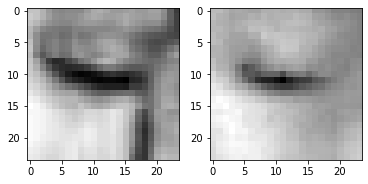

1511 0.0026935834903270006
1512 0.0026361006312072277
1513 0.00250858417712152
1514 0.003023739205673337
1515 0.0029185148887336254
1516 0.0032389226835221052
1517 0.002417296636849642
1518 0.002370620844885707
1519 0.0024190566036850214
1520 0.0025701094418764114


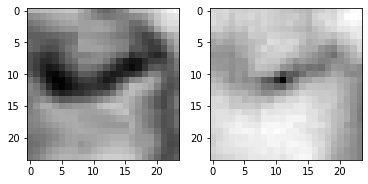

1521 0.002801308874040842
1522 0.0025530748534947634
1523 0.0029992132913321257
1524 0.002409599721431732
1525 0.0024311572778970003
1526 0.0024896820541471243
1527 0.0026404019445180893
1528 0.0024363987613469362
1529 0.005058648530393839
1530 0.002731139538809657


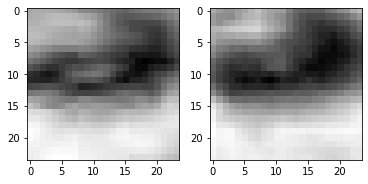

1531 0.0025380311999469995
1532 0.0036240543704479933
1533 0.0028456992004066706
1534 0.0030576575081795454
1535 0.0025368863716721535
1536 0.002765524899587035
1537 0.002188802929595113
1538 0.002535162027925253
1539 0.0042265793308615685
1540 0.0024232259020209312


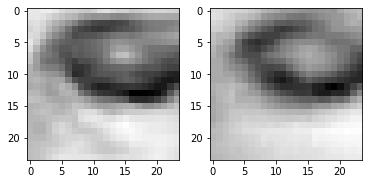

1541 0.00291583058424294
1542 0.0024939822033047676
1543 0.002500456292182207
1544 0.0034328920301049948
1545 0.003027783939614892
1546 0.002502250485122204
1547 0.0026139996480196714
1548 0.0026513035409152508
1549 0.0023696054704487324
1550 0.002481489907950163


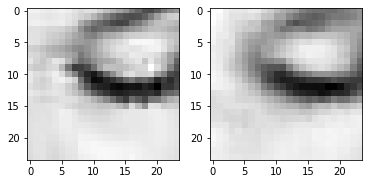

1551 0.002572865691035986
1552 0.002339318161830306
1553 0.002388550201430917
1554 0.002428540261462331
1555 0.0023441005032509565
1556 0.002153185661882162
1557 0.002501190872862935
1558 0.0025804725009948015
1559 0.0028524952940642834
1560 0.002621604595333338


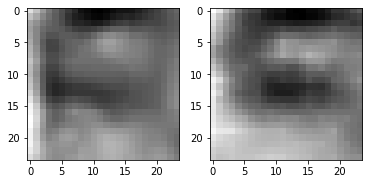

1561 0.00282559753395617
1562 0.002631685696542263
1563 0.0023987097665667534
1564 0.0027408406604081392
1565 0.002701240824535489
1566 0.0023719132877886295
1567 0.002497670240700245
1568 0.0023683744948357344
1569 0.0027690590359270573
1570 0.002424663631245494


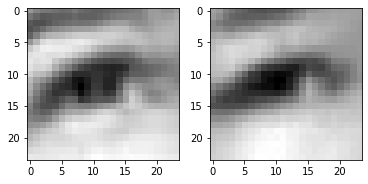

1571 0.0028158817440271378
1572 0.0023142832797020674
1573 0.002406507031992078
1574 0.004923131316900253
1575 0.002696501323953271
1576 0.003095396561548114
1577 0.0034028023947030306
1578 0.0036622455809265375
1579 0.00263932510279119
1580 0.0033901347778737545


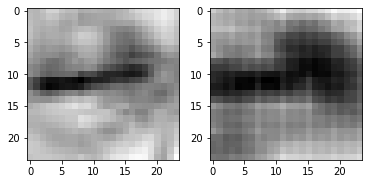

1581 0.002704337239265442
1582 0.003637238871306181
1583 0.0028928599786013365
1584 0.0032983161509037018
1585 0.003156412625685334
1586 0.0024106581695377827
1587 0.0026214064564555883
1588 0.0029381627682596445
1589 0.004688814282417297
1590 0.0025356155820190907


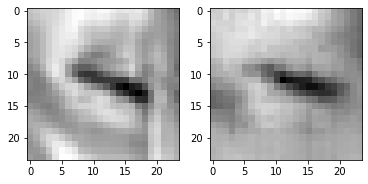

1591 0.004351511597633362
1592 0.0028585561085492373
1593 0.002479036571457982
1594 0.002881382592022419
1595 0.0027641509659588337
1596 0.0030627946835011244
1597 0.002646439941599965
1598 0.0024222549982368946
1599 0.0025017031002789736
1600 0.0024407280143350363


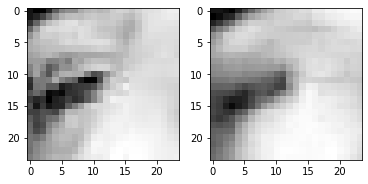

1601 0.002375826006755233
1602 0.0024980928283184767
1603 0.002498109359294176
1604 0.0035447755362838507
1605 0.0023729533422738314
1606 0.002524364273995161
1607 0.002944110194221139
1608 0.003008856438100338
1609 0.002544102258980274
1610 0.0026375094894319773


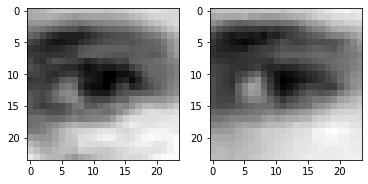

1611 0.002964528277516365
1612 0.0029402365908026695
1613 0.002311876742169261
1614 0.0023552835918962955
1615 0.0024710632860660553
1616 0.002392837544903159
1617 0.00257597747258842
1618 0.0021980255842208862
1619 0.0040879640728235245
1620 0.0029399003833532333


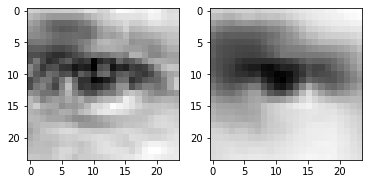

1621 0.0024609570391476154
1622 0.0023968287277966738
1623 0.002545923227444291
1624 0.002522342139855027
1625 0.002590857446193695
1626 0.002767857164144516
1627 0.0024508426431566477
1628 0.00255022244527936
1629 0.0025854557752609253
1630 0.00261433026753366


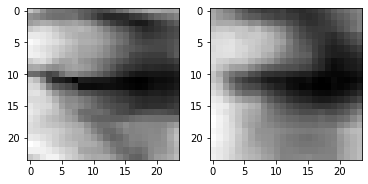

1631 0.002557423897087574
1632 0.0023125207517296076
1633 0.0023975467775017023
1634 0.0038872535806149244
1635 0.002578867133706808
1636 0.0025178007781505585
1637 0.002648286521434784
1638 0.002720407908782363
1639 0.0026233652606606483
1640 0.002368871122598648


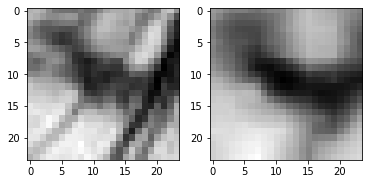

1641 0.0024108686484396458
1642 0.0024831932969391346
1643 0.002433751942589879
1644 0.0024676956236362457
1645 0.0022952936124056578
1646 0.0024868466425687075
1647 0.0023238100111484528
1648 0.0023471894674003124
1649 0.00803175289183855
1650 0.0029446857515722513


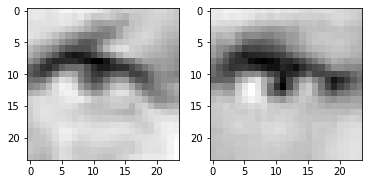

1651 0.005395911633968353
1652 0.004165458492934704
1653 0.002375276293605566
1654 0.0031057698652148247
1655 0.003341938368976116
1656 0.003115107072517276
1657 0.002730569802224636
1658 0.003299316158518195
1659 0.0024731631856411695
1660 0.0031184302642941475


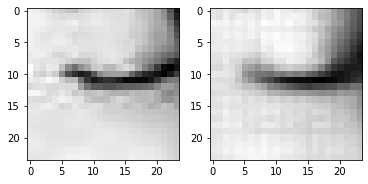

1661 0.004076092503964901
1662 0.0027716762851923704
1663 0.002943880157545209
1664 0.0041166795417666435
1665 0.0031514049042016268
1666 0.0035795611329376698
1667 0.0032587400637567043
1668 0.0037870374508202076
1669 0.0030984480399638414
1670 0.002736348658800125


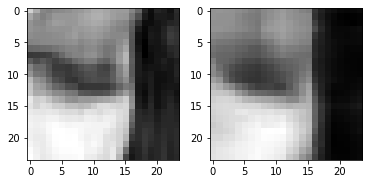

1671 0.0026067961007356644
1672 0.0032811101991683245
1673 0.0038645134773105383
1674 0.002697924617677927
1675 0.003186798421666026
1676 0.0030599767342209816
1677 0.0026558113750070333
1678 0.002489181002601981
1679 0.0034723870921880007
1680 0.004443331155925989


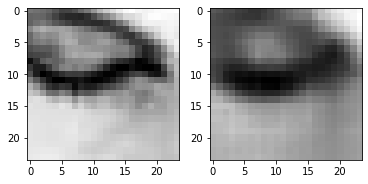

1681 0.0047755856066942215
1682 0.004948974587023258
1683 0.0027163373306393623
1684 0.00287536415271461
1685 0.003716442035511136
1686 0.0054093156941235065
1687 0.0033391297329217196
1688 0.0026343923527747393
1689 0.003031279891729355
1690 0.0032941775862127542


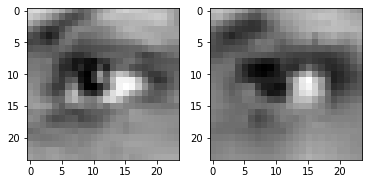

1691 0.004752541892230511
1692 0.003667047480121255
1693 0.0029576595406979322
1694 0.006788718048483133
1695 0.002873640973120928
1696 0.0029595450032502413
1697 0.003156437771394849
1698 0.0028415110427886248
1699 0.0035476982593536377
1700 0.002789570251479745


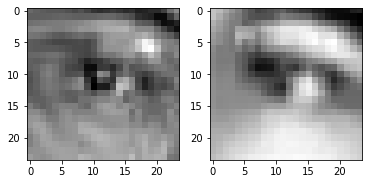

1701 0.002819288754835725
1702 0.002911248244345188
1703 0.002755227265879512
1704 0.0027482553850859404
1705 0.0028246960137039423
1706 0.002811002777889371
1707 0.002677520038560033
1708 0.0027945679612457752
1709 0.00413466477766633
1710 0.0026878854259848595


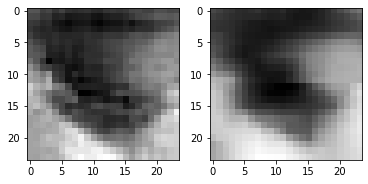

1711 0.0027245914097875357
1712 0.002752546686679125
1713 0.003076946595683694
1714 0.0025295158848166466
1715 0.002567431190982461
1716 0.0025659766979515553
1717 0.0031297386158257723
1718 0.0025125164538621902
1719 0.0026461933739483356
1720 0.002489147474989295


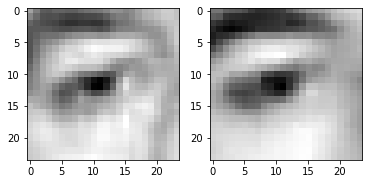

1721 0.0025573326274752617
1722 0.002734443638473749
1723 0.0024449594784528017
1724 0.00535399978980422
1725 0.002755630761384964
1726 0.003871721215546131
1727 0.0026354389265179634
1728 0.002457152586430311
1729 0.002596160862594843
1730 0.0030148562509566545


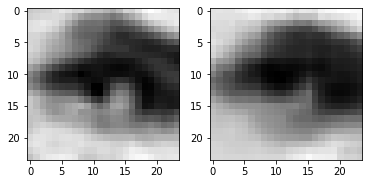

1731 0.002673354232683778
1732 0.002793943742290139
1733 0.0024941605515778065
1734 0.002463717246428132
1735 0.002610466443002224
1736 0.0029048766009509563
1737 0.002288524294272065
1738 0.002657761098816991
1739 0.002825936069712043
1740 0.002487351419404149


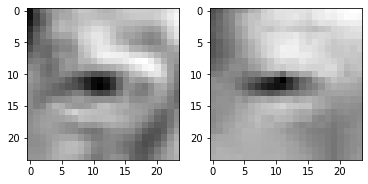

1741 0.0026791004929691553
1742 0.002961555263027549
1743 0.002604291308671236
1744 0.002630983479321003
1745 0.0027474670205265284
1746 0.0022757211700081825
1747 0.002338752383366227
1748 0.0029249009676277637
1749 0.002399622229859233
1750 0.0023987044114619493


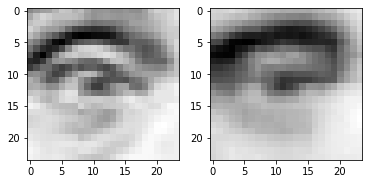

1751 0.0023438988719135523
1752 0.0023385898675769567
1753 0.0025100409984588623
1754 0.0031868640799075365
1755 0.00282988790422678
1756 0.003174368990585208
1757 0.0032742240000516176
1758 0.0035772353876382113
1759 0.004197645932435989
1760 0.0027257234323769808


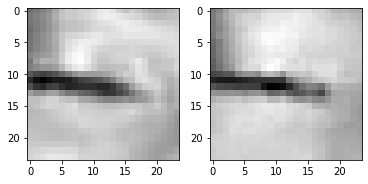

1761 0.002678921679034829
1762 0.0036067189648747444
1763 0.004083175212144852
1764 0.0025223272386938334
1765 0.0022756000980734825
1766 0.0023365181405097246
1767 0.0027415193617343903
1768 0.0036218564491719007
1769 0.0038690173532813787
1770 0.002629726892337203


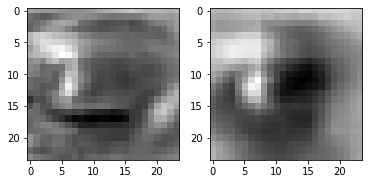

1771 0.0035495187621563673
1772 0.004017292521893978
1773 0.0028851365204900503
1774 0.002821663161739707
1775 0.00256033381447196
1776 0.003028774168342352
1777 0.002811413025483489
1778 0.0029539517126977444
1779 0.0027389286551624537
1780 0.002521061571314931


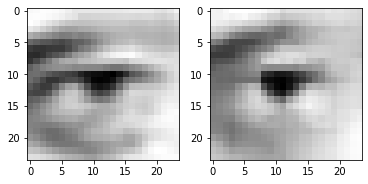

1781 0.0032355794683098793
1782 0.0028358278796076775
1783 0.0029689420480281115
1784 0.004561867564916611
1785 0.002330862684175372
1786 0.002675402443856001
1787 0.0028065494261682034
1788 0.002861131215468049
1789 0.002565524075180292
1790 0.002673286711797118


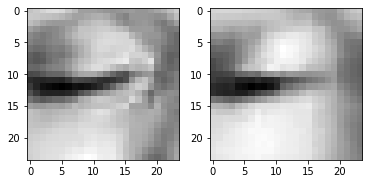

1791 0.002480012597516179
1792 0.002624356420710683
1793 0.002396409632638097
1794 0.0032024707179516554
1795 0.0025489255785942078
1796 0.0024004930164664984
1797 0.0028739995323121548
1798 0.0025696170050650835
1799 0.0029304209165275097
1800 0.0028917170129716396


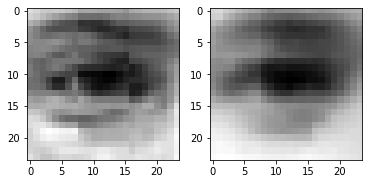

1801 0.002882580505684018
1802 0.0028389678336679935
1803 0.002379785291850567
1804 0.002304892288520932
1805 0.0022856758441776037
1806 0.002251788740977645
1807 0.0029004747048020363
1808 0.002578752813860774
1809 0.0023994483053684235
1810 0.002367055742070079


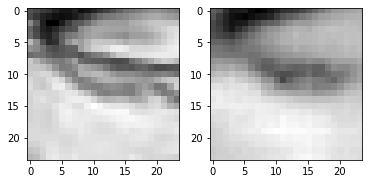

1811 0.0027684264350682497
1812 0.0021762466058135033
1813 0.0023171594366431236
1814 0.004168305080384016
1815 0.002316185738891363
1816 0.002825852483510971
1817 0.002815785352140665
1818 0.0024959195870906115
1819 0.002355111762881279
1820 0.002571995835751295


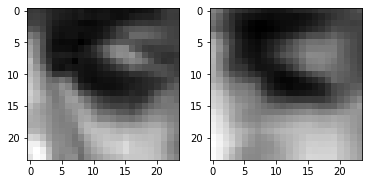

1821 0.002547205425798893
1822 0.0022234166972339153
1823 0.0024703689850866795
1824 0.0024672250729054213
1825 0.002479478484019637
1826 0.0025372756645083427
1827 0.002911088988184929
1828 0.002404706086963415
1829 0.004686387721449137
1830 0.0024183220230042934


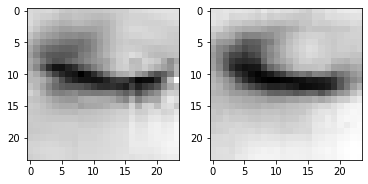

1831 0.0026330023538321257
1832 0.0027546652127057314
1833 0.0026166976895183325
1834 0.0024127382785081863
1835 0.0023590587079524994
1836 0.0026520309038460255
1837 0.0025494436267763376
1838 0.002321437932550907
1839 0.0030733896419405937
1840 0.002619317965582013


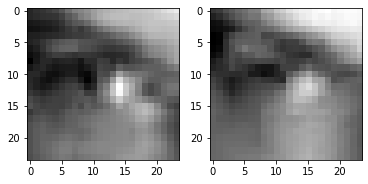

1841 0.00222987262532115
1842 0.0027241527568548918
1843 0.002597324550151825
1844 0.004784708376973867
1845 0.0021956847049295902
1846 0.0032582494895905256
1847 0.002615600125864148
1848 0.0028796216938644648
1849 0.00221639103256166
1850 0.0021654735319316387


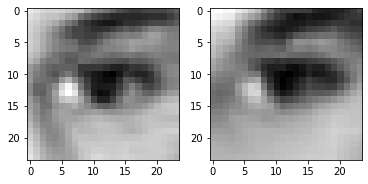

1851 0.0023296803701668978
1852 0.003156385850161314
1853 0.002355419797822833
1854 0.002267648931592703
1855 0.002650967799127102
1856 0.0023557415697723627
1857 0.0022748231422156096
1858 0.0023738075979053974
1859 0.0029512583278119564
1860 0.0022514215670526028


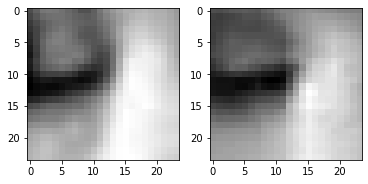

1861 0.002395783783867955
1862 0.002808875637128949
1863 0.002151273190975189
1864 0.002290854463353753
1865 0.0022363204043358564
1866 0.002285552676767111
1867 0.0021736929193139076
1868 0.0023772846907377243
1869 0.0023093644995242357
1870 0.0021433208603411913


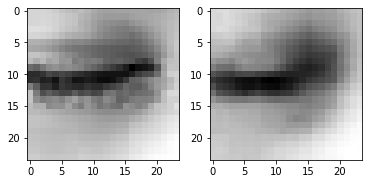

1871 0.0020875895861536264
1872 0.0022462490014731884
1873 0.0023414355237036943
1874 0.00270570395514369
1875 0.0024641714990139008
1876 0.0022820504382252693
1877 0.002410916844382882
1878 0.002252150559797883
1879 0.002251810859888792
1880 0.002137876348569989


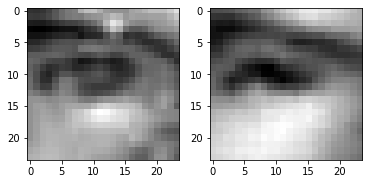

1881 0.0023417151533067226
1882 0.0022559212520718575
1883 0.002644568681716919
1884 0.0022784254979342222
1885 0.002053225180134177
1886 0.002196779241785407
1887 0.002743514021858573
1888 0.00248713162727654
1889 0.004501946736127138
1890 0.0025446880608797073


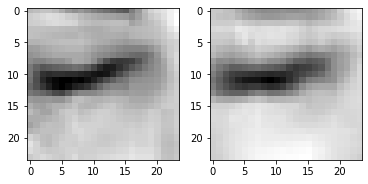

1891 0.0027897213585674763
1892 0.0028201367240399122
1893 0.0029252120293676853
1894 0.002584039233624935
1895 0.0024602937046438456
1896 0.0026499105151742697
1897 0.002475663786754012
1898 0.0024362325202673674
1899 0.002294794889166951
1900 0.002234454033896327


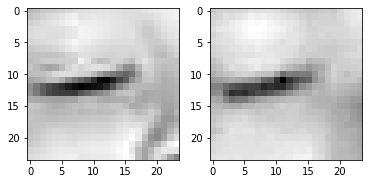

1901 0.0020637933630496264
1902 0.0022151221055537462
1903 0.00240038288757205
1904 0.0035420889034867287
1905 0.002278536558151245
1906 0.0033161446917802095
1907 0.002656772267073393
1908 0.0022937494795769453
1909 0.0026450345758348703
1910 0.002834238111972809


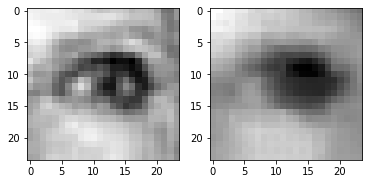

1911 0.0026873655151575804
1912 0.0024513998068869114
1913 0.002244106726720929
1914 0.0023448665160685778
1915 0.0023908752482384443
1916 0.0022528015542775393
1917 0.0023753929417580366
1918 0.002272985177114606
1919 0.004848880227655172
1920 0.0021750617306679487


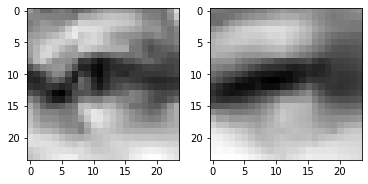

1921 0.0022304554004222155
1922 0.0022548269480466843
1923 0.0023823457304388285
1924 0.0028177916537970304
1925 0.0024063827004283667
1926 0.002397195203229785
1927 0.0023202081210911274
1928 0.0023022585082799196
1929 0.002296348800882697
1930 0.002296155085787177


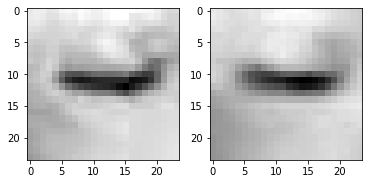

1931 0.002072723815217614
1932 0.002214649459347129
1933 0.0019810667727142572
1934 0.004502775147557259
1935 0.002115728333592415
1936 0.002378488425165415
1937 0.0028618881478905678
1938 0.00237086764536798
1939 0.0021956665441393852
1940 0.0025817607529461384


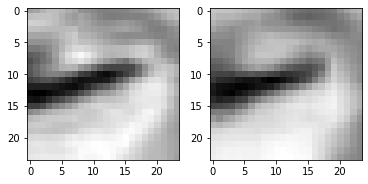

1941 0.0022078214678913355
1942 0.002591948490589857
1943 0.0025672558695077896
1944 0.002382516860961914
1945 0.0021320090163499117
1946 0.0023221331648528576
1947 0.0021510268561542034
1948 0.001979463966563344
1949 0.0029367965180426836
1950 0.0021976788993924856


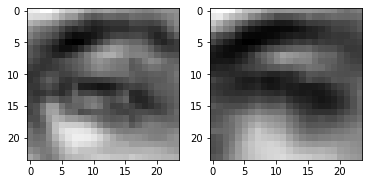

1951 0.0023002338130027056
1952 0.0024078956339508295
1953 0.0023843045346438885
1954 0.0022555196192115545
1955 0.0021305291447788477
1956 0.0026043446268886328
1957 0.0026847936678677797
1958 0.002102568047121167
1959 0.002220649505034089
1960 0.002854590769857168


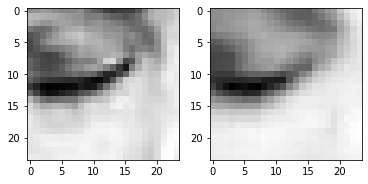

1961 0.0020616657566279173
1962 0.002075543627142906
1963 0.002172603039070964
1964 0.003448324976488948
1965 0.004048994742333889
1966 0.002667206572368741
1967 0.002565117087215185
1968 0.0025055604055523872
1969 0.0028752260841429234
1970 0.002868312643840909


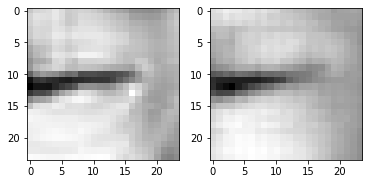

1971 0.002263035625219345
1972 0.0022461016196757555
1973 0.0022218143567442894
1974 0.0027050264179706573
1975 0.0025583498645573854
1976 0.0022806983906775713
1977 0.002459203125908971
1978 0.0021145502105355263
1979 0.005855710245668888
1980 0.002214389154687524


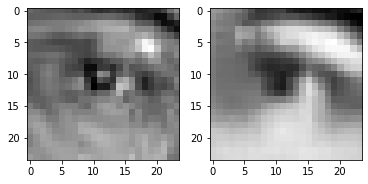

1981 0.0025898616295307875
1982 0.0025627384893596172
1983 0.0024546978529542685
1984 0.002288390649482608
1985 0.0022430552635341883
1986 0.002194139873608947
1987 0.0027919544372707605
1988 0.0023720357567071915
1989 0.00220758025534451
1990 0.002413362031802535


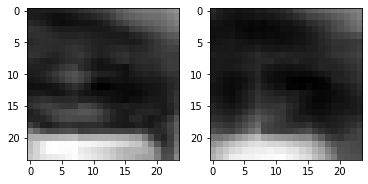

1991 0.0022660044487565756
1992 0.002365510445088148
1993 0.0023214092943817377
1994 0.003851919900625944
1995 0.0021630784031003714
1996 0.0030879159457981586
1997 0.0032767506781965494
1998 0.0023960538674145937
1999 0.002275545382872224
2000 0.0025403632316738367


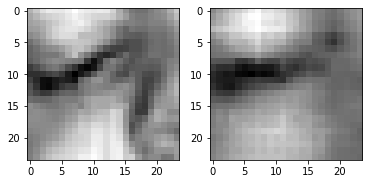

2001 0.0025496522430330515
2002 0.0024755781050771475
2003 0.002285437658429146
2004 0.0023186581674963236
2005 0.002225539879873395
2006 0.0025925266090780497
2007 0.0025196545757353306
2008 0.002245973562821746
2009 0.005700990557670593
2010 0.0027547194622457027


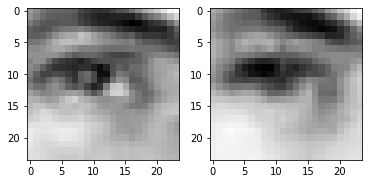

2011 0.0024510722141712904
2012 0.0025953727308660746
2013 0.0024687780532985926
2014 0.0023312417324632406
2015 0.00220656581223011
2016 0.002252924721688032
2017 0.002484911819919944
2018 0.0025109152775257826
2019 0.002249134238809347
2020 0.0022914172150194645


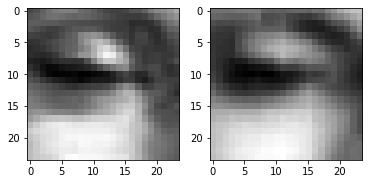

2021 0.0025030469987541437
2022 0.0023251050151884556
2023 0.002321171574294567
2024 0.003877899842336774
2025 0.0021869719494134188
2026 0.0026280612219125032
2027 0.00241674087010324
2028 0.0025284369476139545
2029 0.0021674272138625383
2030 0.0022200988605618477


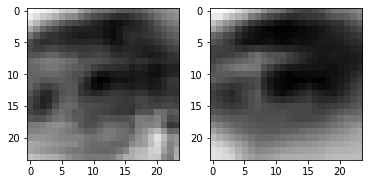

2031 0.0023320598993450403
2032 0.003227687906473875
2033 0.0023256023414433002
2034 0.0023519289679825306
2035 0.0022137744817882776
2036 0.0033722028601914644
2037 0.003036276903003454
2038 0.0025817204732447863
2039 0.00413371529430151
2040 0.00342881609685719


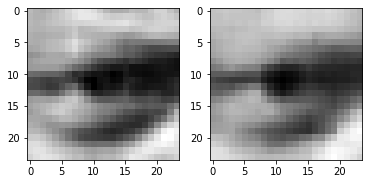

2041 0.004650112707167864
2042 0.0030963034369051456
2043 0.002552070189267397
2044 0.003141402965411544
2045 0.002489386824890971
2046 0.002783327829092741
2047 0.0031502367928624153
2048 0.002429000101983547
2049 0.002486271783709526
2050 0.0027077149134129286


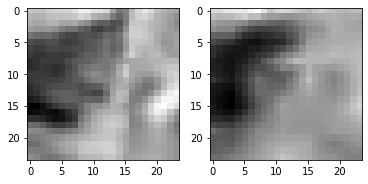

2051 0.0027212288696318865
2052 0.0028489972464740276
2053 0.0026303143240511417
2054 0.003466081339865923
2055 0.0023105156142264605
2056 0.0029418705962598324
2057 0.0027990795206278563
2058 0.002528874669224024
2059 0.0029492054600268602
2060 0.00277773872949183


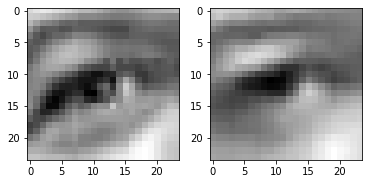

2061 0.0026517785154283047
2062 0.0024078902788460255
2063 0.0023088394664227962
2064 0.0027625667862594128
2065 0.002319032559171319
2066 0.0025574625469744205
2067 0.0023415391333401203
2068 0.0028121541254222393
2069 0.004501113668084145
2070 0.0023541778791695833


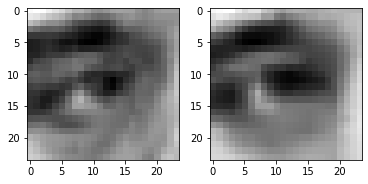

2071 0.002996353665366769
2072 0.0031190726440399885
2073 0.0027275998145341873
2074 0.002295789076015353
2075 0.002389801200479269
2076 0.002457633148878813
2077 0.0026560737751424313
2078 0.0025228874292224646
2079 0.002378949197009206
2080 0.002582170069217682


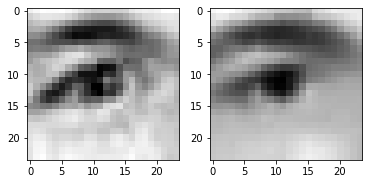

2081 0.002432828303426504
2082 0.002261217450723052
2083 0.002299094805493951
2084 0.0025909568648785353
2085 0.00213300297036767
2086 0.002457614289596677
2087 0.0026790681295096874
2088 0.002488825237378478
2089 0.0026906891725957394
2090 0.002389587927609682


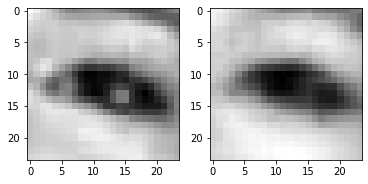

2091 0.002196615794673562
2092 0.002418629126623273
2093 0.0022783991880714893
2094 0.0022746401373296976
2095 0.0021146293729543686
2096 0.002216174267232418
2097 0.002197681227698922
2098 0.0021063510794192553
2099 0.004018337465822697
2100 0.0023679304867982864


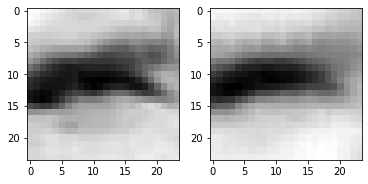

2101 0.002747863996773958
2102 0.0026977250818163157
2103 0.0024192084092646837
2104 0.002383933402597904
2105 0.0022852462716400623
2106 0.002737835980951786
2107 0.002821352332830429
2108 0.0023961085826158524
2109 0.002343523781746626
2110 0.002162683056667447


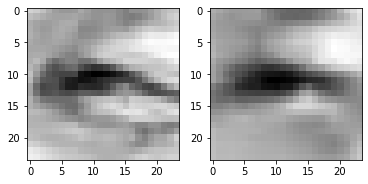

2111 0.0024143655318766832
2112 0.0021837607491761446
2113 0.0024474256206303835
2114 0.004818568471819162
2115 0.00320990988984704
2116 0.003250190755352378
2117 0.004116418305784464
2118 0.002626959001645446
2119 0.002908732509240508
2120 0.0034509801771491766


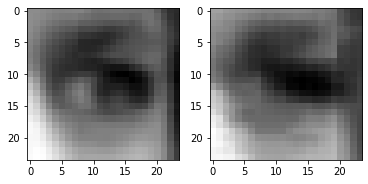

2121 0.003075116081163287
2122 0.0023929360322654247
2123 0.002437576185911894
2124 0.002681085839867592
2125 0.00437216367572546
2126 0.002412234665825963
2127 0.0025178007781505585
2128 0.0029201204888522625
2129 0.005329641047865152
2130 0.0023027488496154547


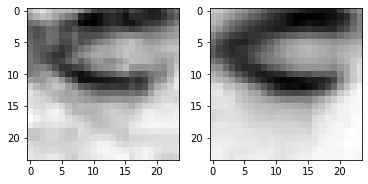

2131 0.0025460878387093544
2132 0.0031747552566230297
2133 0.0033076521940529346
2134 0.002547940006479621
2135 0.0024592222180217505
2136 0.0030768115539103746
2137 0.0028333303052932024
2138 0.0022907007951289415
2139 0.0022358412388712168
2140 0.0024189348332583904


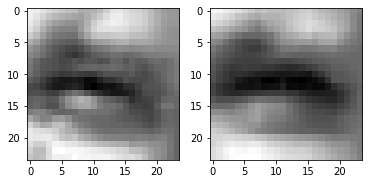

2141 0.0022659695241600275
2142 0.002455527428537607
2143 0.0035546724684536457
2144 0.0033539433497935534
2145 0.0025949396658688784
2146 0.004081991966813803
2147 0.00268523208796978
2148 0.0025624476838856936
2149 0.0025484543293714523
2150 0.002412964589893818


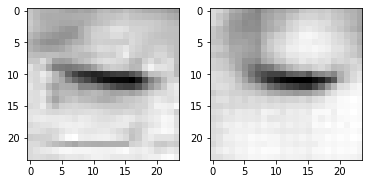

2151 0.0027335972990840673
2152 0.0028585002291947603
2153 0.0022686885204166174
2154 0.0022786364424973726
2155 0.0022810865193605423
2156 0.0023500612005591393
2157 0.002511040773242712
2158 0.0023642112500965595
2159 0.003343477612361312
2160 0.002213801257312298


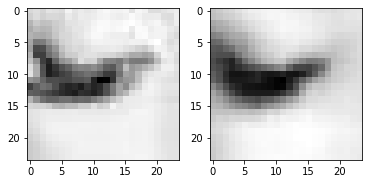

2161 0.002557723317295313
2162 0.002298956038430333
2163 0.003013908863067627
2164 0.002191282110288739
2165 0.002344108186662197
2166 0.0028971799183636904
2167 0.0021868927869945765
2168 0.0023049009032547474
2169 0.0026037737261503935
2170 0.0022472913842648268


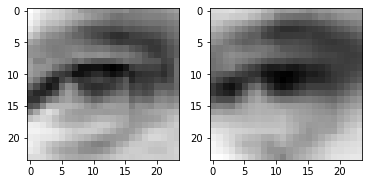

2171 0.002411038614809513
2172 0.0025504992809146643
2173 0.0023271820973604918
2174 0.0028650364838540554
2175 0.0022688275203108788
2176 0.002325491514056921
2177 0.0025659569073468447
2178 0.0026273445691913366
2179 0.0023601565044373274
2180 0.0023143875878304243


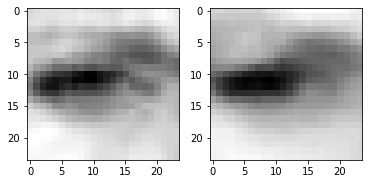

2181 0.0021783767733722925
2182 0.0023955265060067177
2183 0.002364307874813676
2184 0.002182435942813754
2185 0.002097838092595339
2186 0.002276673214510083
2187 0.0032444556709378958
2188 0.0025374044198542833
2189 0.003130632918328047
2190 0.0031085829250514507


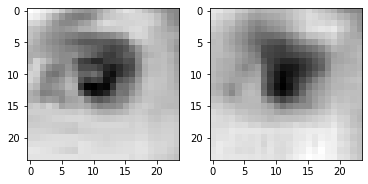

2191 0.002983803628012538
2192 0.002256646752357483
2193 0.00247235712595284
2194 0.0021019333507865667
2195 0.0021414393559098244
2196 0.0032200198620557785
2197 0.0031798866111785173
2198 0.002044101944193244
2199 0.002675094874575734
2200 0.0040345583111047745


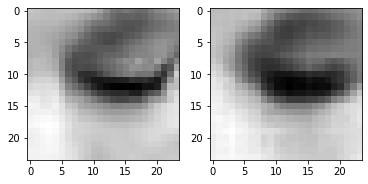

2201 0.002240477129817009
2202 0.002270239172503352
2203 0.002201302908360958
2204 0.003389444900676608
2205 0.0023024261463433504
2206 0.002376218792051077
2207 0.0025726580061018467
2208 0.0024054700043052435
2209 0.002100627636536956
2210 0.0022307797335088253


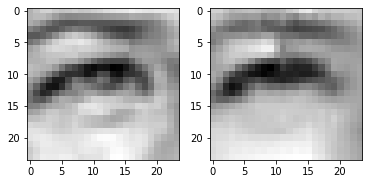

2211 0.0021589654497802258
2212 0.0025139942299574614
2213 0.0025220788083970547
2214 0.002288620453327894
2215 0.00300546083599329
2216 0.0021121338941156864
2217 0.0022223512642085552
2218 0.002598527120426297
2219 0.003903087694197893
2220 0.002873954363167286


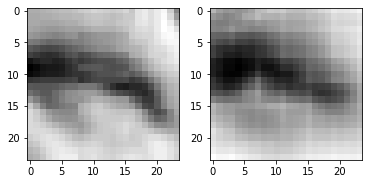

2221 0.002251649973914027
2222 0.00254400004632771
2223 0.002352154580876231
2224 0.0023105896543711424
2225 0.00240684044547379
2226 0.0022462133783847094
2227 0.002507487777620554
2228 0.00259479065425694
2229 0.002421136712655425
2230 0.002492443425580859


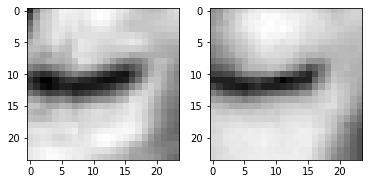

2231 0.0023178760893642902
2232 0.0020242263562977314
2233 0.0022246520966291428
2234 0.002909356728196144
2235 0.0022027245722711086
2236 0.002331546740606427
2237 0.0022249468602240086
2238 0.002297780243679881
2239 0.0020943554118275642
2240 0.002221293281763792


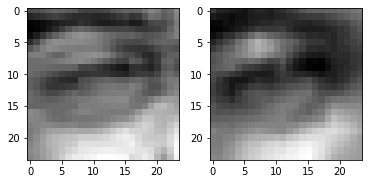

2241 0.0022159009240567684
2242 0.0020917998626828194
2243 0.001986368792131543
2244 0.002038927748799324
2245 0.002236948348581791
2246 0.0021282669622451067
2247 0.001988164382055402
2248 0.002030846429988742
2249 0.0055834464728832245
2250 0.002399217104539275


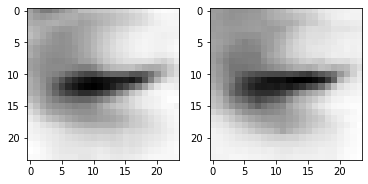

2251 0.0027793527115136385
2252 0.0024785122368484735
2253 0.0022946728859096766
2254 0.0024449643678963184
2255 0.0020856636110693216
2256 0.002280931919813156
2257 0.002324423985555768
2258 0.002014276571571827
2259 0.002140324329957366
2260 0.00211748736910522


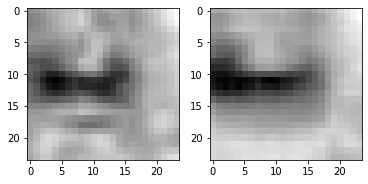

2261 0.0020038404036313295
2262 0.002066130517050624
2263 0.0019457262242212892
2264 0.005781390704214573
2265 0.0022402273025363684
2266 0.002372747752815485
2267 0.002801652066409588
2268 0.0026532032061368227
2269 0.0022186206188052893
2270 0.0024137687869369984


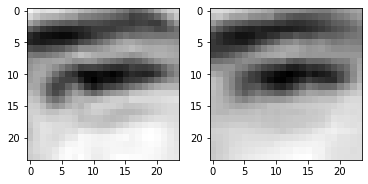

2271 0.004038183018565178
2272 0.0022454378195106983
2273 0.0023678396828472614
2274 0.002324205357581377
2275 0.0023122576531022787
2276 0.003245816333219409
2277 0.002022622851654887
2278 0.002548772608861327
2279 0.00312790647149086
2280 0.0025671268813312054


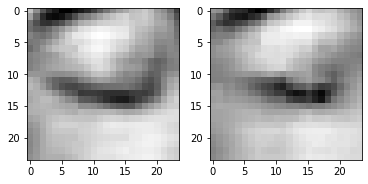

2281 0.002555127488449216
2282 0.00248131831176579
2283 0.0023224791511893272
2284 0.0023894021287560463
2285 0.00267786649055779
2286 0.0019605522975325584
2287 0.002571987686678767
2288 0.0025023450143635273
2289 0.002297832863405347
2290 0.0022335671819746494


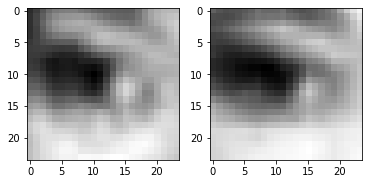

2291 0.0021659971680492163
2292 0.002160271629691124
2293 0.0023141379933804274
2294 0.0030078154522925615
2295 0.0020528617314994335
2296 0.002468870719894767
2297 0.002185037825256586
2298 0.0021942511666566133
2299 0.0024763222318142653
2300 0.0024355677887797356


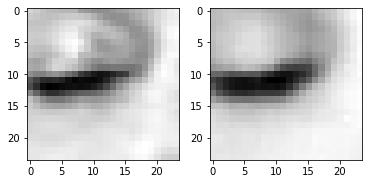

2301 0.0021159546449780464
2302 0.0020760202314704657
2303 0.0026494439225643873
2304 0.002653228584676981
2305 0.002440591109916568
2306 0.0022946761455386877
2307 0.0020869814325124025
2308 0.0027833750937134027
2309 0.0039014762733131647
2310 0.002542338566854596


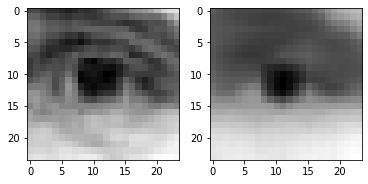

2311 0.002745597390457988
2312 0.0028457760345190763
2313 0.0024199592880904675
2314 0.002280968241393566
2315 0.0022063786163926125
2316 0.0023268950171768665
2317 0.002900046529248357
2318 0.002196408109739423
2319 0.00230894866399467
2320 0.0022326598409563303


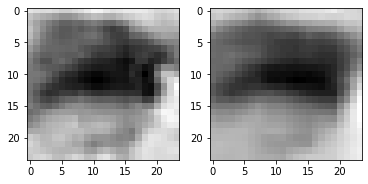

2321 0.0023143740836530924
2322 0.0026362601201981306
2323 0.002365801716223359
2324 0.0035560205578804016
2325 0.002291904529556632
2326 0.002857960294932127
2327 0.0022937555331736803
2328 0.002418982330709696
2329 0.002312510274350643
2330 0.0028640918899327517


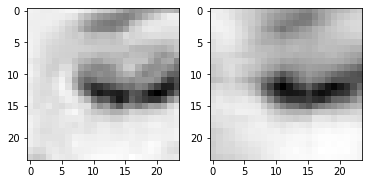

2331 0.0023646235931664705
2332 0.0022112831939011812
2333 0.0028295032680034637
2334 0.0028293814975768328
2335 0.0021991354878991842
2336 0.002224707743152976
2337 0.00231107696890831
2338 0.001965101808309555
2339 0.007706271484494209
2340 0.0023367470130324364


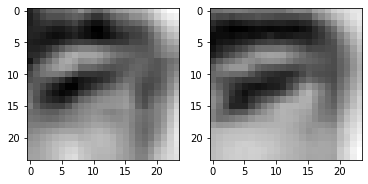

2341 0.0035147229209542274
2342 0.0032301065512001514
2343 0.002651858376339078
2344 0.0025304253213107586
2345 0.0030851715710014105
2346 0.0026414047461003065
2347 0.0022775083780288696
2348 0.0024244356900453568
2349 0.002336359117180109
2350 0.002269841032102704


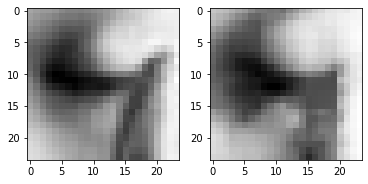

2351 0.002160540781915188
2352 0.002694882685318589
2353 0.0030674163717776537
2354 0.0035697477869689465
2355 0.0024765883572399616
2356 0.0026397956535220146
2357 0.003090581391006708
2358 0.002474043983966112
2359 0.0024515644181519747
2360 0.002268117619678378


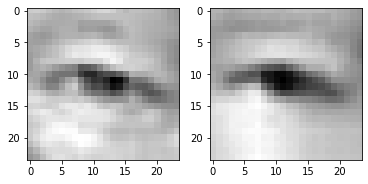

2361 0.002170204883441329
2362 0.0023286454379558563
2363 0.001996794017031789
2364 0.002041093772277236
2365 0.0021127492655068636
2366 0.002611945616081357
2367 0.0029175078961998224
2368 0.0022280437406152487
2369 0.010071305558085442
2370 0.002264911076053977


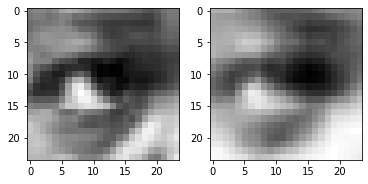

2371 0.002438506344333291
2372 0.0034835219848901033
2373 0.003110331017524004
2374 0.0028518661856651306
2375 0.0021880187559872866
2376 0.0023384110536426306
2377 0.002498764544725418
2378 0.0024153420235961676
2379 0.0026321429759263992
2380 0.0022198788356035948


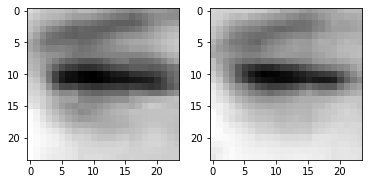

2381 0.002327332040295005
2382 0.0024885302409529686
2383 0.0021371333859860897
2384 0.006062764208763838
2385 0.0023589448537677526
2386 0.0030674070585519075
2387 0.003763207234442234
2388 0.0029159875120967627
2389 0.002326285932213068
2390 0.002748440485447645


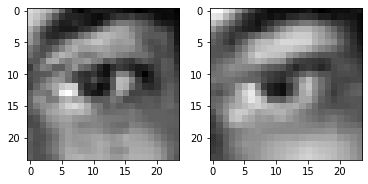

2391 0.0027041409630328417
2392 0.002507738070562482
2393 0.0026463523972779512
2394 0.0023397060576826334
2395 0.0025147029664367437
2396 0.0025656032375991344
2397 0.0025152817834168673
2398 0.0021198811009526253
2399 0.004065749701112509
2400 0.0025264278519898653


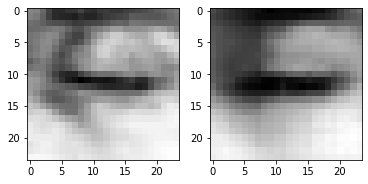

2401 0.003147856565192342
2402 0.003289108630269766
2403 0.0026347723323851824
2404 0.002369353547692299
2405 0.0026789591647684574
2406 0.0025265065487474203
2407 0.0031190929003059864
2408 0.002210908103734255
2409 0.0031903006602078676
2410 0.003038199385628104


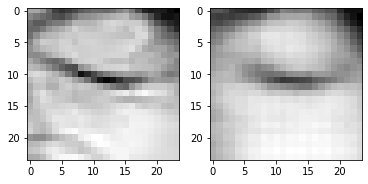

2411 0.0024516377598047256
2412 0.0022624300327152014
2413 0.0030379679519683123
2414 0.0044472236186265945
2415 0.0029561605770140886
2416 0.003974439576268196
2417 0.002475801855325699
2418 0.0026373276486992836
2419 0.0023604801390320063
2420 0.002699370961636305


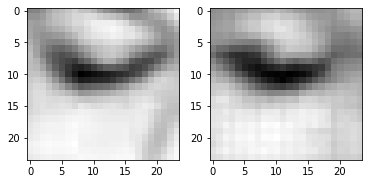

2421 0.0024601437617093325
2422 0.0020783175714313984
2423 0.0023189049679785967
2424 0.0024102265015244484
2425 0.0024321661330759525
2426 0.0023841706570237875
2427 0.00207397504709661
2428 0.0020964578725397587
2429 0.0045419493690133095
2430 0.0029455891344696283


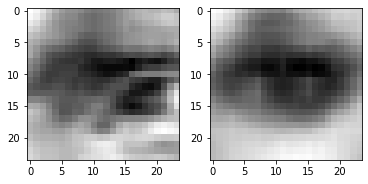

2431 0.0036938840057700872
2432 0.003144841408357024
2433 0.002510849153622985
2434 0.002478890586644411
2435 0.002928041387349367
2436 0.0023793841246515512
2437 0.002273819874972105
2438 0.0023350859992206097
2439 0.0024119578301906586
2440 0.0023649611975997686


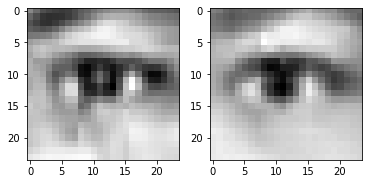

2441 0.002275917213410139
2442 0.003049445105716586
2443 0.002124224789440632
2444 0.004404644016176462
2445 0.002534294966608286
2446 0.0031463990453630686
2447 0.003603833494707942
2448 0.002651216695085168
2449 0.0022759614512324333
2450 0.0026333045680075884


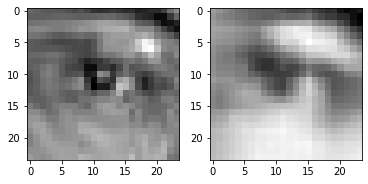

2451 0.0027532032690942287
2452 0.0023954135831445456
2453 0.0027209429536014795
2454 0.0024591591209173203
2455 0.0025032376870512962
2456 0.0027653612196445465
2457 0.0027154283598065376
2458 0.002485212404280901
2459 0.0029317971784621477
2460 0.0023057779762893915


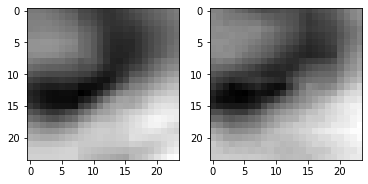

2461 0.0024671952705830336
2462 0.002710725413635373
2463 0.002305335830897093
2464 0.0022536751348525286
2465 0.0029969282913953066
2466 0.0022142252419143915
2467 0.002600576262921095
2468 0.0022481728810817003
2469 0.0021392880007624626
2470 0.0019657996017485857


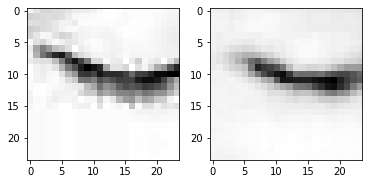

2471 0.0022401788737624884
2472 0.002260620705783367
2473 0.0020605854224413633
2474 0.00256620766595006
2475 0.002232154831290245
2476 0.00224913633428514
2477 0.002561000408604741
2478 0.0023453764151781797
2479 0.002430364955216646
2480 0.002219385700300336


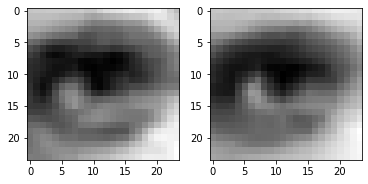

2481 0.002073839772492647
2482 0.0020939128007739782
2483 0.002420336939394474
2484 0.0021251302678138018
2485 0.0020053007174283266
2486 0.0022699986584484577
2487 0.0021967391949146986
2488 0.0021882986184209585
2489 0.004337293561547995
2490 0.0022453090641647577


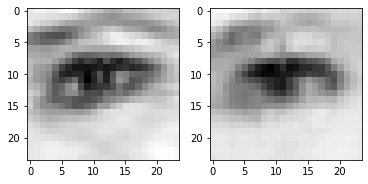

2491 0.0022092179860919714
2492 0.0027067814953625202
2493 0.002325112698599696
2494 0.0019999064970761538
2495 0.002279211999848485
2496 0.0026158629916608334
2497 0.0021054979879409075
2498 0.00204015476629138
2499 0.0022784662432968616
2500 0.002275695325806737


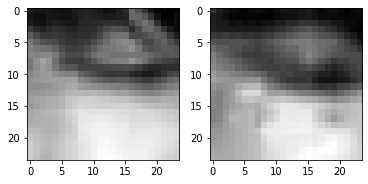

2501 0.0020089929457753897
2502 0.0019520459463819861
2503 0.002228206256404519
2504 0.003077046014368534
2505 0.002212721388787031
2506 0.0021033864468336105
2507 0.0025305866729468107
2508 0.0021145984064787626
2509 0.002521471120417118
2510 0.002356547163799405


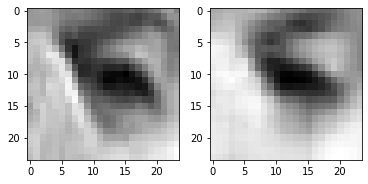

2511 0.0022759055718779564
2512 0.0021651883143931627
2513 0.002249794313684106
2514 0.0021049780771136284
2515 0.0020704290363937616
2516 0.002319600898772478
2517 0.0018883937736973166
2518 0.0019630021415650845
2519 0.0031362001318484545
2520 0.0021992826368659735


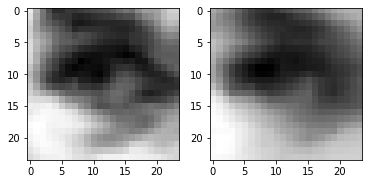

2521 0.0020551620982587337
2522 0.0021026998292654753
2523 0.0021415548399090767
2524 0.0022753558587282896
2525 0.0018533242400735617
2526 0.002093876013532281
2527 0.0018875292735174298
2528 0.0029426247347146273
2529 0.0020288394298404455
2530 0.002689121523872018


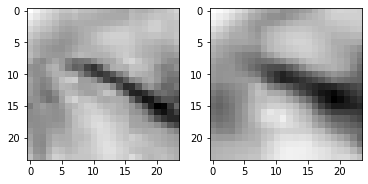

2531 0.0019077687757089734
2532 0.002005560090765357
2533 0.002194661647081375
2534 0.0023169447667896748
2535 0.002771942876279354
2536 0.0033983751200139523
2537 0.002024381887167692
2538 0.0023966480512171984
2539 0.0022127595730125904
2540 0.002122427336871624


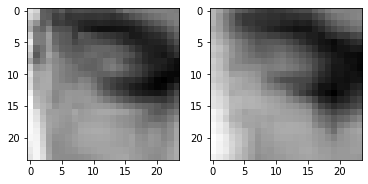

2541 0.0024613121058791876
2542 0.0023050860036164522
2543 0.0020519469399005175
2544 0.0027793662156909704
2545 0.00220715394243598
2546 0.002575554419308901
2547 0.002105862367898226
2548 0.002232720609754324
2549 0.0031184591352939606
2550 0.0025389990769326687


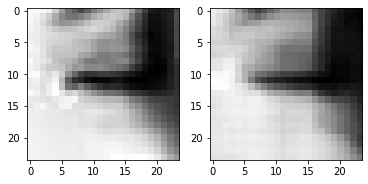

2551 0.0025075392331928015
2552 0.0023378951009362936
2553 0.0022074133157730103
2554 0.0019245429430156946
2555 0.002108569722622633
2556 0.002439844189211726
2557 0.00268733617849648
2558 0.0020021807868033648
2559 0.0027537995483726263
2560 0.00284421700052917


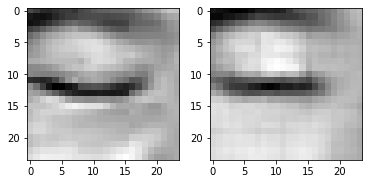

2561 0.002140693599358201
2562 0.0024251805152744055
2563 0.0019621041137725115
2564 0.008049685508012772
2565 0.0023469191510230303
2566 0.0040483311749994755
2567 0.003468898357823491
2568 0.0022071199491620064
2569 0.002173294313251972
2570 0.0023179249837994576


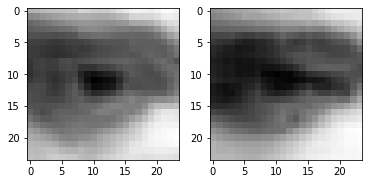

2571 0.002949954243376851
2572 0.0024421282578259706
2573 0.002124871825799346
2574 0.0020881607197225094
2575 0.002407688647508621
2576 0.0023288822267204523
2577 0.002682937541976571
2578 0.002254234394058585
2579 0.0031286710873246193
2580 0.00208884384483099


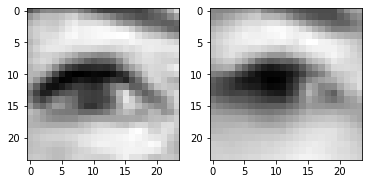

2581 0.002210424281656742
2582 0.0023584356531500816
2583 0.0023999609984457493
2584 0.002377943368628621
2585 0.002151391701772809
2586 0.0023154770024120808
2587 0.002140447497367859
2588 0.0019662838894873857
2589 0.002138342009857297
2590 0.0020956944208592176


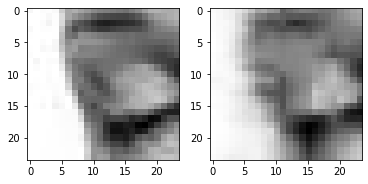

2591 0.002087542088702321
2592 0.0021452109795063734
2593 0.00246411026455462
2594 0.005895745474845171
2595 0.002602966269478202
2596 0.002630281262099743
2597 0.0035509231965988874
2598 0.0023168569896370173
2599 0.0023700681049376726
2600 0.0030083218589425087


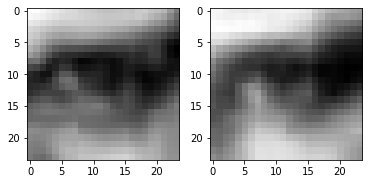

2601 0.0023612419608980417
2602 0.0022775076795369387
2603 0.002064542844891548
2604 0.0025969205889850855
2605 0.002161187119781971
2606 0.00235665962100029
2607 0.0024604348000139
2608 0.002221245551481843
2609 0.0032799632754176855
2610 0.0027878573164343834


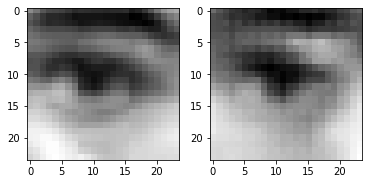

2611 0.0030793386977165937
2612 0.0025235444772988558
2613 0.002357655204832554
2614 0.0021661007776856422
2615 0.0023048901930451393
2616 0.002450962783768773
2617 0.0023001660592854023
2618 0.0024858552496880293
2619 0.0021555619314312935
2620 0.0021985990460962057


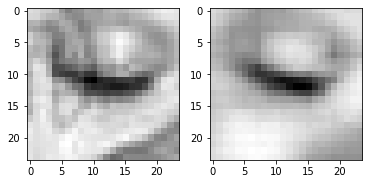

2621 0.002630423754453659
2622 0.002377257915213704
2623 0.0020618692506104708
2624 0.004144883248955011
2625 0.0024591500405222178
2626 0.003553972113877535
2627 0.0024476954713463783
2628 0.0023649774957448244
2629 0.002323898021131754
2630 0.0023535562213510275


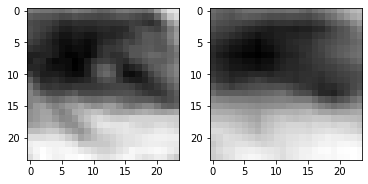

2631 0.003031647065654397
2632 0.002237664768472314
2633 0.002378058386966586
2634 0.002162824384868145
2635 0.0027957663405686617
2636 0.0021884460002183914
2637 0.0021044628228992224
2638 0.002101767109706998
2639 0.007257586810737848
2640 0.002563839079812169


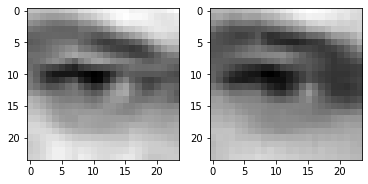

2641 0.004751456435769796
2642 0.004094946198165417
2643 0.002828841330483556
2644 0.002831334015354514
2645 0.0034151047002524137
2646 0.00310556311160326
2647 0.0029636071994900703
2648 0.0025422561448067427
2649 0.0030449246987700462
2650 0.002997327595949173


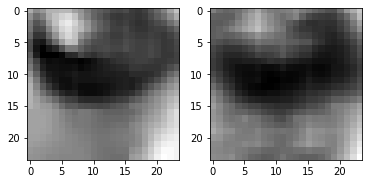

2651 0.002252113539725542
2652 0.0023504116106778383
2653 0.0022356503177434206
2654 0.0048896619118750095
2655 0.0034995637834072113
2656 0.00330546242184937
2657 0.002720924559980631
2658 0.002623472362756729
2659 0.002953442046418786
2660 0.0024291593581438065


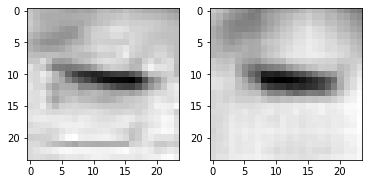

2661 0.0023102578707039356
2662 0.002720045391470194
2663 0.0024507620837539434
2664 0.0026143842842429876
2665 0.0023466343991458416
2666 0.0020900978706777096
2667 0.0027542111929506063
2668 0.002186097903177142
2669 0.004200732335448265
2670 0.002676224336028099


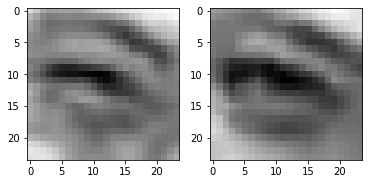

2671 0.0024635004810988903
2672 0.0024035561364144087
2673 0.002281459979712963
2674 0.0023089549504220486
2675 0.0021482708398252726
2676 0.0020965326111763716
2677 0.0019449701067060232
2678 0.001981121953576803
2679 0.002040688181295991
2680 0.002015908481553197


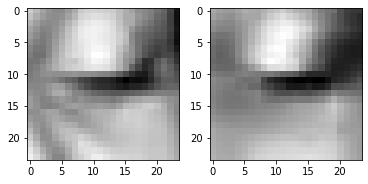

2681 0.002123919315636158
2682 0.0020076206419616938
2683 0.002107650274410844
2684 0.0029012602753937244
2685 0.002331416355445981
2686 0.0020859406795352697
2687 0.0024170216638594866
2688 0.002273017540574074
2689 0.002291846089065075
2690 0.002427857369184494


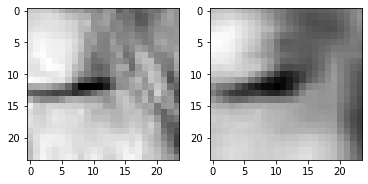

2691 0.002867278177291155
2692 0.002103823237121105
2693 0.0026653334498405457
2694 0.002057737438008189
2695 0.0021194966975599527
2696 0.0020319181494414806
2697 0.0020076853688806295
2698 0.002273731864988804
2699 0.0037966908421367407
2700 0.00276112649589777


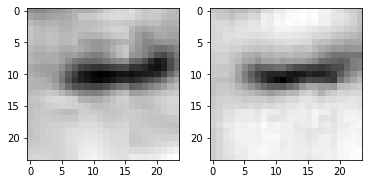

2701 0.0028108146507292986
2702 0.002532427432015538
2703 0.002736072288826108
2704 0.002868134994059801
2705 0.0024880068376660347
2706 0.002596524078398943
2707 0.0020738535095006227
2708 0.0026513049378991127
2709 0.0032666469924151897
2710 0.0024794579949229956


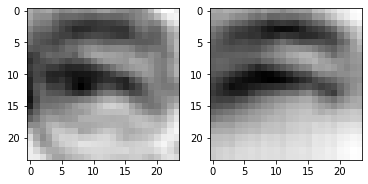

2711 0.002561143832281232
2712 0.0022852688562124968
2713 0.0031275528017431498
2714 0.0069685825146734715
2715 0.0022089167032390833
2716 0.0023847066331654787
2717 0.0028602508828043938
2718 0.002936860080808401
2719 0.002567537361755967
2720 0.0026443384122103453


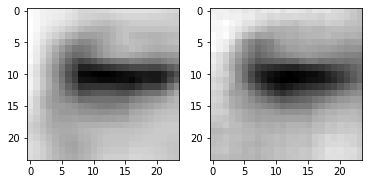

2721 0.0022331331856548786
2722 0.0035834594164043665
2723 0.0023114944342523813
2724 0.002352337585762143
2725 0.002225506352260709
2726 0.002484251046553254
2727 0.0022766233887523413
2728 0.0022596784401685
2729 0.003263308433815837
2730 0.0023311926051974297


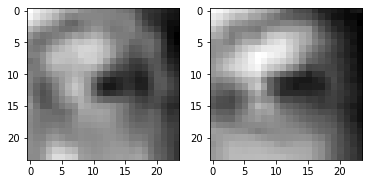

2731 0.0023480651434510946
2732 0.002084999578073621
2733 0.002219748916104436
2734 0.0022234672214835882
2735 0.002791969571262598
2736 0.002226733136922121
2737 0.002113739028573036
2738 0.0021196554880589247
2739 0.002178651513531804
2740 0.0029539098031818867


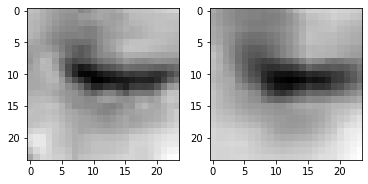

2741 0.0020292974077165127
2742 0.0021518005523830652
2743 0.0029655725229531527
2744 0.006597030442208052
2745 0.0025734719820320606
2746 0.003478675615042448
2747 0.0030993428081274033
2748 0.0026204229798167944
2749 0.002808714983984828
2750 0.0022515421733260155


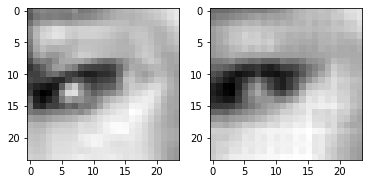

2751 0.003170080715790391
2752 0.003317255061119795
2753 0.0031705049332231283
2754 0.0024183953646570444
2755 0.0028205872513353825
2756 0.002931667724624276
2757 0.0025211903266608715
2758 0.0021268553100526333
2759 0.004568404518067837
2760 0.0023245331831276417


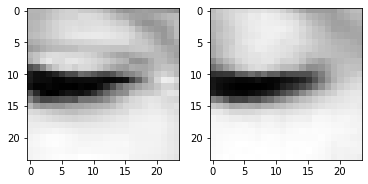

2761 0.0028913647402077913
2762 0.0027788118459284306
2763 0.0022964205127209425
2764 0.0024662665091454983
2765 0.002180032432079315
2766 0.002293373690918088
2767 0.002233737614005804
2768 0.002156821545213461
2769 0.0022538527846336365
2770 0.002406917978078127


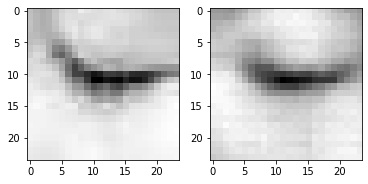

2771 0.002235161606222391
2772 0.002052508294582367
2773 0.002393461763858795
2774 0.0037591673899441957
2775 0.0019850372336804867
2776 0.002533120336011052
2777 0.002626091241836548
2778 0.0023199126590043306
2779 0.002228944795206189
2780 0.00216603628359735


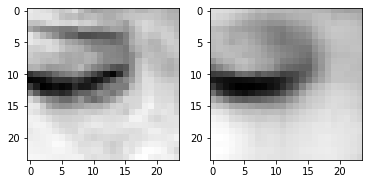

2781 0.002752042142674327
2782 0.0025023710913956165
2783 0.002135051880031824
2784 0.0026901087258011103
2785 0.002073463751003146
2786 0.002159326570108533
2787 0.0021023089066147804
2788 0.0022564746905118227
2789 0.0053803687915205956
2790 0.0022745740134269


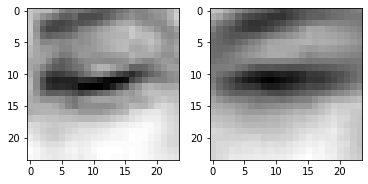

2791 0.0023540195543318987
2792 0.00286488002166152
2793 0.0028343794401735067
2794 0.002645202912390232
2795 0.002298234263435006
2796 0.0024777071084827185
2797 0.0026305641513317823
2798 0.0022111942525953054
2799 0.0022682177368551493
2800 0.0024316608905792236


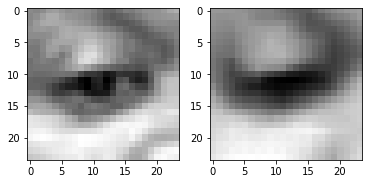

2801 0.002166236750781536
2802 0.0025928288232535124
2803 0.0022539710626006126
2804 0.0027445275336503983
2805 0.002274658065289259
2806 0.0024136684369295835
2807 0.002263666596263647
2808 0.0020968124736100435
2809 0.003083875635638833
2810 0.0027475308161228895


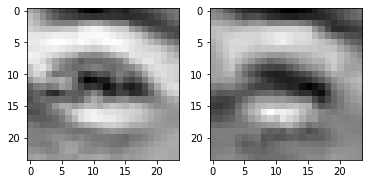

2811 0.0024326450657099485
2812 0.002724643098190427
2813 0.0032995580695569515
2814 0.002855283208191395
2815 0.0022656938526779413
2816 0.002233531093224883
2817 0.0031908126547932625
2818 0.0030225215014070272
2819 0.003350289072841406
2820 0.0022355669643729925


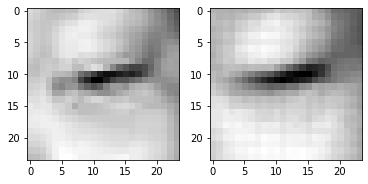

2821 0.0024372623302042484
2822 0.003618061076849699
2823 0.00278406566940248
2824 0.0026037113275378942
2825 0.002262429567053914
2826 0.003316918620839715
2827 0.0024899267591536045
2828 0.0022918495815247297
2829 0.0024040290154516697
2830 0.0023389775305986404


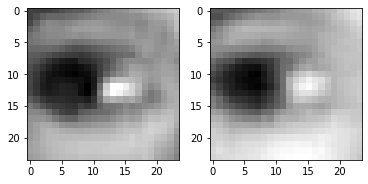

2831 0.0023446637205779552
2832 0.002185534918680787
2833 0.002153614768758416
2834 0.005158155225217342
2835 0.0021797504741698503
2836 0.002934625605121255
2837 0.0027800542302429676
2838 0.0027387982700020075
2839 0.002478651702404022
2840 0.0024111568927764893


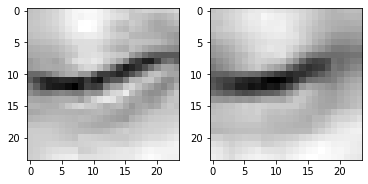

2841 0.002305620117112994
2842 0.0023707302752882242
2843 0.002275703242048621
2844 0.0021560820750892162
2845 0.002356661017984152
2846 0.0023486216086894274
2847 0.0022434161510318518
2848 0.002129284432157874
2849 0.002860923996195197
2850 0.002178470604121685


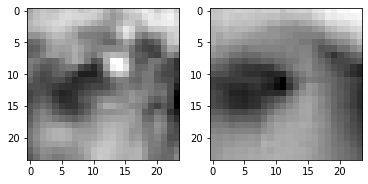

2851 0.0022451046388596296
2852 0.0025699292309582233
2853 0.0023184530436992645
2854 0.002511256141588092
2855 0.0024596157018095255
2856 0.0021275195758789778
2857 0.0022541640792042017
2858 0.0019679393153637648
2859 0.002240099711343646
2860 0.0020255364943295717


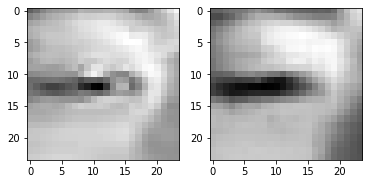

2861 0.0020398199558258057
2862 0.0023510463070124388
2863 0.00214431737549603
2864 0.004515714943408966
2865 0.0018638544715940952
2866 0.002519642235711217
2867 0.0026829750277101994
2868 0.0019986226689070463
2869 0.0017914311029016972
2870 0.002197709633037448


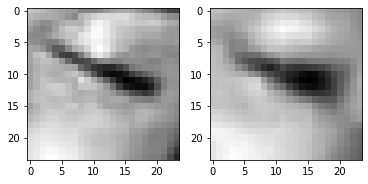

2871 0.0019920901395380497
2872 0.0026432720478624105
2873 0.002444756682962179
2874 0.0020847138948738575
2875 0.0020912722684442997
2876 0.0020329083781689405
2877 0.0022552506998181343
2878 0.002090797293931246
2879 0.004008874297142029
2880 0.0023375689052045345


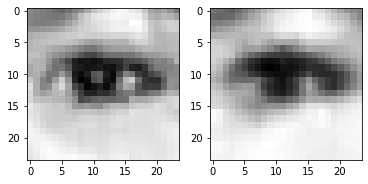

2881 0.003196883713826537
2882 0.0024806642904877663
2883 0.002478402340784669
2884 0.0021447406616061926
2885 0.002358008176088333
2886 0.0023814362939447165
2887 0.002111405599862337
2888 0.0021902669686824083
2889 0.001946468953974545
2890 0.0022635075729340315


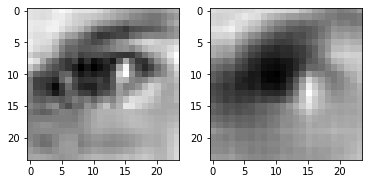

2891 0.0021247602999210358
2892 0.0022893098648637533
2893 0.0020260089077055454
2894 0.005785281769931316
2895 0.002343787346035242
2896 0.0030744404066354036
2897 0.003905173856765032
2898 0.002562357811257243
2899 0.0028079610783606768
2900 0.0033183216582983732


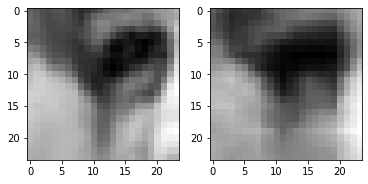

2901 0.002647287677973509
2902 0.00245467945933342
2903 0.0020475154742598534
2904 0.0021810459438711405
2905 0.0024316217750310898
2906 0.0020860980730503798
2907 0.0022182136308401823
2908 0.0020350213162600994
2909 0.004424532409757376
2910 0.002150751417502761


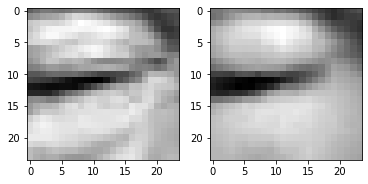

2911 0.002717131283134222
2912 0.003340056398883462
2913 0.0026665194891393185
2914 0.0020994842052459717
2915 0.0023898035287857056
2916 0.002859058789908886
2917 0.0026437051128596067
2918 0.002063396153971553
2919 0.0021852843929082155
2920 0.0022775207180529833


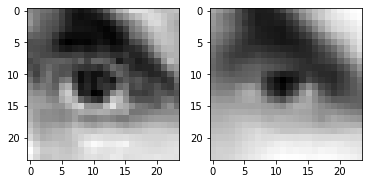

2921 0.0021423238795250654
2922 0.002193005522713065
2923 0.002200513379648328
2924 0.010874161496758461
2925 0.0030074564274400473
2926 0.006546447519212961
2927 0.0027511485386639833
2928 0.00236942945048213
2929 0.0026059444062411785
2930 0.003481154330074787


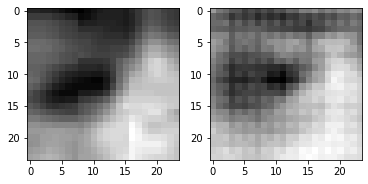

2931 0.0028004911728203297
2932 0.002389756729826331
2933 0.0023289788514375687
2934 0.002329866634681821
2935 0.0026896486524492502
2936 0.0021092116367071867
2937 0.002358972327783704
2938 0.0021886867471039295
2939 0.005660420749336481
2940 0.002798462752252817


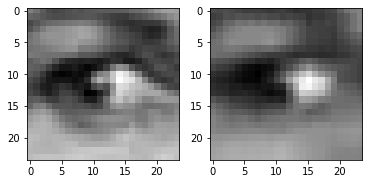

2941 0.005228174384683371
2942 0.0039631277322769165
2943 0.0023998927790671587
2944 0.002347764791920781
2945 0.003142870031297207
2946 0.00278314552269876
2947 0.0028333174996078014
2948 0.002340278821066022
2949 0.00255983998067677
2950 0.0022784583270549774


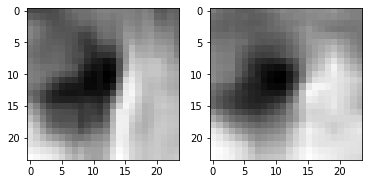

2951 0.0023706669453531504
2952 0.0024328557774424553
2953 0.002518489258363843
2954 0.002817765809595585
2955 0.0023251324892044067
2956 0.002339849481359124
2957 0.0023469580337405205
2958 0.0026320042088627815
2959 0.002106016268953681
2960 0.002084326697513461


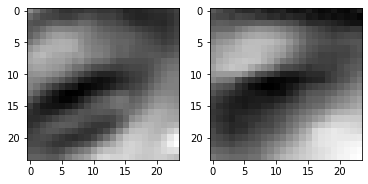

2961 0.002591694938018918
2962 0.002518687630072236
2963 0.0031306270975619555
2964 0.0020173194352537394
2965 0.0022569410502910614
2966 0.002094569383189082
2967 0.0022498301696032286
2968 0.0023454364854842424
2969 0.0026908447034657
2970 0.0020255607087165117


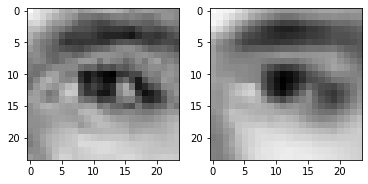

2971 0.0021727927960455418
2972 0.0021041131112724543
2973 0.0019036807352676988
2974 0.001934376428835094
2975 0.0019694792572408915
2976 0.0022056614980101585
2977 0.00201793503947556
2978 0.002064972883090377
2979 0.002203489886596799
2980 0.002052953699603677


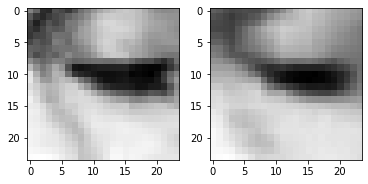

2981 0.002071398077532649
2982 0.0019244218710809946
2983 0.00191357487346977
2984 0.002854461083188653
2985 0.0020066811703145504
2986 0.002722414443269372
2987 0.002658739686012268
2988 0.0023734525311738253
2989 0.002076548058539629
2990 0.002245506504550576


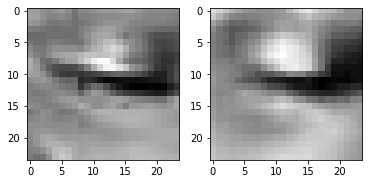

2991 0.0031276701483875513
2992 0.0024564361665397882
2993 0.003957778215408325
2994 0.0018877764232456684
2995 0.002421600976958871
2996 0.003014832502231002
2997 0.0027611900586634874
2998 0.002356901066377759
2999 0.00457741366699338
3000 0.00212913379073143


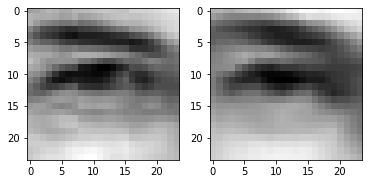

3001 0.0032130617182701826
3002 0.0027150213718414307
3003 0.0020215155091136694
3004 0.0028777550905942917
3005 0.0029607980977743864
3006 0.0020337235182523727
3007 0.0022432056721299887
3008 0.0021023438312113285
3009 0.0020916813518851995
3010 0.0023689300287514925


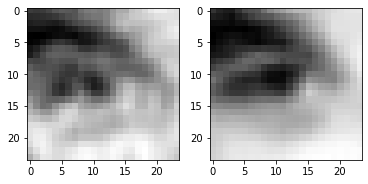

3011 0.0024172556586563587
3012 0.0019884812645614147
3013 0.002127918181940913
3014 0.0036479681730270386
3015 0.0022330274805426598
3016 0.002186723053455353
3017 0.0032468573190271854
3018 0.0024014576338231564
3019 0.002194920787587762
3020 0.002145949052646756


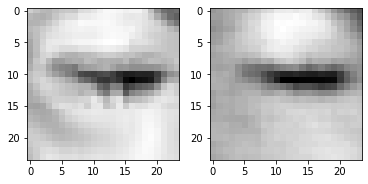

3021 0.002126712817698717
3022 0.00232928735204041
3023 0.0022136003244668245
3024 0.0023101840633898973
3025 0.0022102955263108015
3026 0.002172645414248109
3027 0.0020515855867415667
3028 0.0021427245810627937
3029 0.0031319677364081144
3030 0.002601804444566369


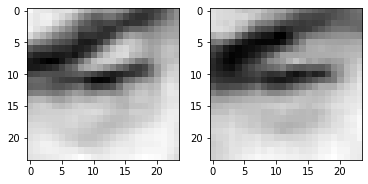

3031 0.0026545939035713673
3032 0.0021178435999900103
3033 0.0025459800381213427
3034 0.0020311654079705477
3035 0.0024650353007018566
3036 0.002046604175120592
3037 0.002320605330169201
3038 0.0019836954306811094
3039 0.002373849507421255
3040 0.0021678581833839417


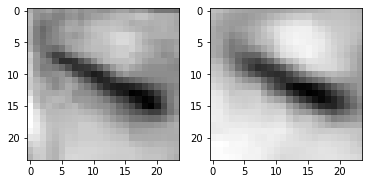

3041 0.0025203083641827106
3042 0.002450223546475172
3043 0.0021203632932156324
3044 0.004051283933222294
3045 0.0019605192355811596
3046 0.002019567182287574
3047 0.002252883045002818
3048 0.002201938536018133
3049 0.001961669884622097
3050 0.0021995913702994585


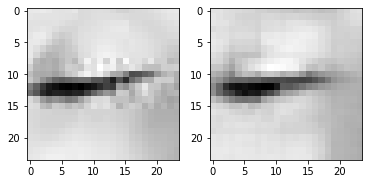

3051 0.002160300500690937
3052 0.001998193096369505
3053 0.002007919130846858
3054 0.002107985783368349
3055 0.0020643919706344604
3056 0.0023384252563118935
3057 0.0021417750976979733
3058 0.002141264732927084
3059 0.004603797569870949
3060 0.003179969033226371


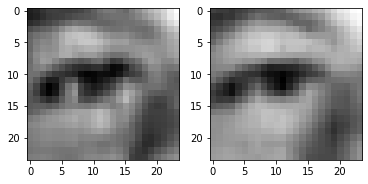

3061 0.002389307366684079
3062 0.0033749148715287447
3063 0.0023703633341938257
3064 0.0023791876155883074
3065 0.0027325425762683153
3066 0.0024337174836546183
3067 0.0026393933221697807
3068 0.0022626316640526056
3069 0.002346696564927697
3070 0.002683113096281886


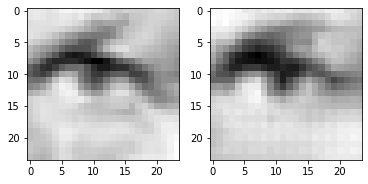

3071 0.0024113620165735483
3072 0.002206016331911087
3073 0.002494026208296418
3074 0.0050938003696501255
3075 0.00255885673686862
3076 0.002374272793531418
3077 0.0022471786942332983
3078 0.0023028827272355556
3079 0.0023051551543176174
3080 0.0023636622354388237


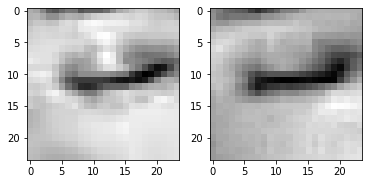

3081 0.0020398003980517387
3082 0.0021115408744663
3083 0.0022023713681846857
3084 0.0021823616698384285
3085 0.0027863699942827225
3086 0.0032177427783608437
3087 0.002540444955229759
3088 0.002329636365175247
3089 0.0039143869653344154
3090 0.002004956593737006


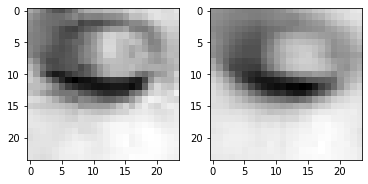

3091 0.0025186219718307257
3092 0.0024632986169308424
3093 0.0023509380407631397
3094 0.002260807901620865
3095 0.0020557872485369444
3096 0.002224092371761799
3097 0.002450388390570879
3098 0.002887538867071271
3099 0.002154021989554167
3100 0.0021643228828907013


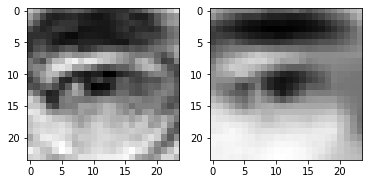

3101 0.002134345006197691
3102 0.002297048456966877
3103 0.0025257763918489218
3104 0.0030720659997314215
3105 0.0023340177722275257
3106 0.00315277767367661
3107 0.0024199981708079576
3108 0.002271413803100586
3109 0.002091639908030629
3110 0.0023068536538630724


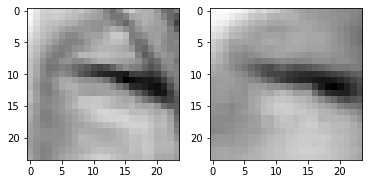

3111 0.0027805217541754246
3112 0.0020608524791896343
3113 0.0021121941972523928
3114 0.001916437060572207
3115 0.002644151449203491
3116 0.0024806635919958353
3117 0.0018934574909508228
3118 0.0019423397025093436
3119 0.0023792716674506664
3120 0.001876547117717564


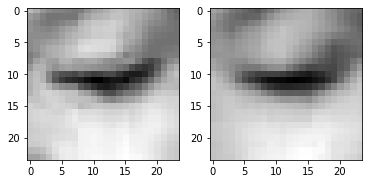

3121 0.002346256049349904
3122 0.0023842272348701954
3123 0.0022647357545793056
3124 0.002011253498494625
3125 0.0019181338138878345
3126 0.0021356313955038786
3127 0.0019635159987956285
3128 0.0020851606968790293
3129 0.0020394136663526297
3130 0.002036551246419549


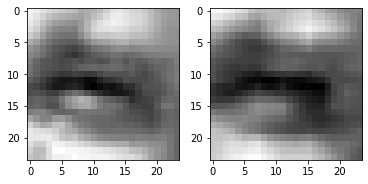

3131 0.0017688893713057041
3132 0.002137779025360942
3133 0.0018694241298362613
3134 0.0026013199239969254
3135 0.001907232915982604
3136 0.0019920095801353455
3137 0.0025465816725045443
3138 0.0018116927240043879
3139 0.0019363750470802188
3140 0.0018698862986639142


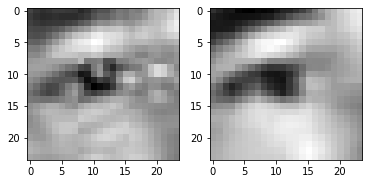

3141 0.001924618030898273
3142 0.0019113136222586036
3143 0.002065435517579317
3144 0.0017710799584165215
3145 0.0018521283054724336
3146 0.0019540968351066113
3147 0.0023763549979776144
3148 0.0021775097120553255
3149 0.0027280200738459826
3150 0.001952406601049006


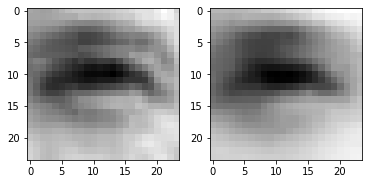

3151 0.0020657561253756285
3152 0.0022025015205144882
3153 0.002120944671332836
3154 0.00215392024256289
3155 0.001927328878082335
3156 0.002132148714736104
3157 0.0019004378700628877
3158 0.002097969176247716
3159 0.0020001039374619722
3160 0.0022041485644876957


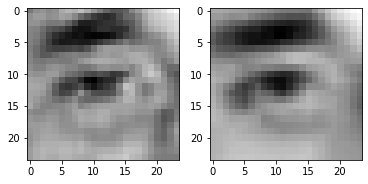

3161 0.0019859913736581802
3162 0.001937579014338553
3163 0.0020613516680896282
3164 0.005342903081327677
3165 0.0024956718552857637
3166 0.0037280130200088024
3167 0.0024589921813458204
3168 0.002208517864346504
3169 0.0023996164090931416
3170 0.003273033769801259


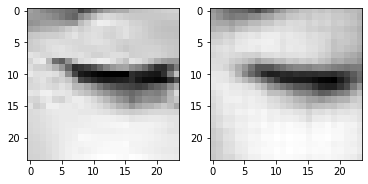

3171 0.002415065886452794
3172 0.002175095956772566
3173 0.001895023277029395
3174 0.0029247640632092953
3175 0.002336583100259304
3176 0.002016792306676507
3177 0.001813333248719573
3178 0.0019085236126556993
3179 0.007454029284417629
3180 0.0022742408327758312


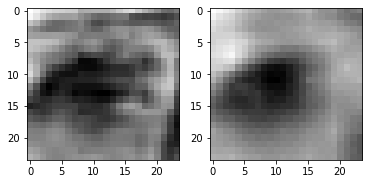

3181 0.002941231010481715
3182 0.0025895037688314915
3183 0.002282356843352318
3184 0.0019601413514465094
3185 0.00222039339132607
3186 0.0020826992113143206
3187 0.0022587082348763943
3188 0.0020217113196849823
3189 0.0021689804270863533
3190 0.0020693205296993256


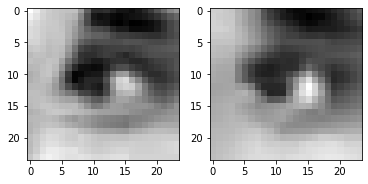

3191 0.0020846251863986254
3192 0.00235001347027719
3193 0.0022345446050167084
3194 0.0042740278877317905
3195 0.0021008497569710016
3196 0.0025049501564353704
3197 0.0035129794850945473
3198 0.0024834447540342808
3199 0.002096468349918723
3200 0.0027457757387310266


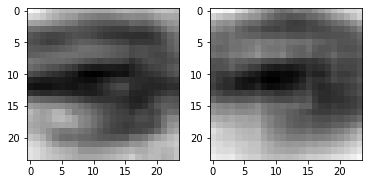

3201 0.002164802048355341
3202 0.0023907653521746397
3203 0.0021981815807521343
3204 0.002248363569378853
3205 0.002275523729622364
3206 0.0019872430711984634
3207 0.0019771468359977007
3208 0.0024001735728234053
3209 0.0055871088989079
3210 0.002176244044676423


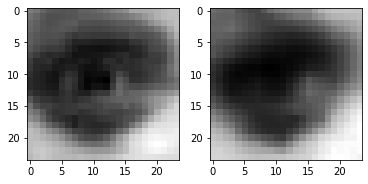

3211 0.0032441318035125732
3212 0.003279890399426222
3213 0.0024499923456460238
3214 0.002307527232915163
3215 0.002391259418800473
3216 0.002773025305941701
3217 0.00305742840282619
3218 0.0029182250145822763
3219 0.002412779489532113
3220 0.0022581766825169325


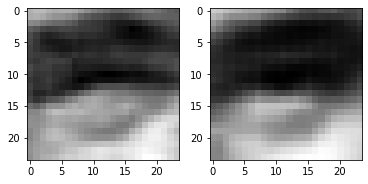

3221 0.0034064960200339556
3222 0.0023936289362609386
3223 0.0023891483433544636
3224 0.00424167001619935
3225 0.002335931407287717
3226 0.0029849179554730654
3227 0.0029131085611879826
3228 0.0026413591112941504
3229 0.0024896764662116766
3230 0.0023319607134908438


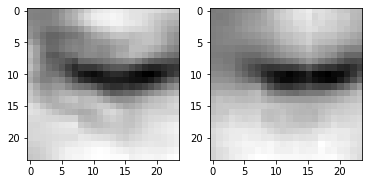

3231 0.002494380809366703
3232 0.003634573658928275
3233 0.0025783213786780834
3234 0.002908863825723529
3235 0.0024694912135601044
3236 0.0021957450080662966
3237 0.002522218506783247
3238 0.0021917358972132206
3239 0.004387725610285997
3240 0.00314729125238955


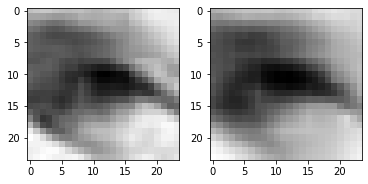

3241 0.0034580687060952187
3242 0.0027710760477930307
3243 0.0023026501294225454
3244 0.002453037304803729
3245 0.0033694147132337093
3246 0.0030537026468664408
3247 0.0028521153144538403
3248 0.00296626309864223
3249 0.0021466563921421766
3250 0.0024000995326787233


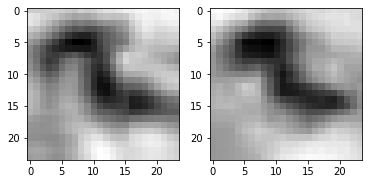

3251 0.0029248129576444626
3252 0.00211136182770133
3253 0.002296458464115858
3254 0.005410126410424709
3255 0.002350169699639082
3256 0.0034030296374112368
3257 0.0037453046534210443
3258 0.002399613382294774
3259 0.002503477968275547
3260 0.0029472699388861656


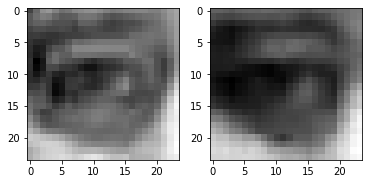

3261 0.00242920801974833
3262 0.0024238387122750282
3263 0.002064894186332822
3264 0.002195816021412611
3265 0.0024754866026341915
3266 0.002129694912582636
3267 0.002069263719022274
3268 0.0020551334600895643
3269 0.002667827531695366
3270 0.0021269831340759993


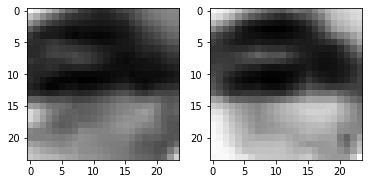

3271 0.002431051107123494
3272 0.003089712467044592
3273 0.0020542640704661608
3274 0.002588889794424176
3275 0.0022246423177421093
3276 0.002072503324598074
3277 0.002387718763202429
3278 0.0023014433681964874
3279 0.001952773192897439
3280 0.0032467155251652002


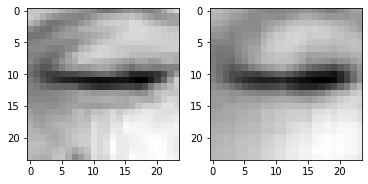

3281 0.0022473791614174843
3282 0.002299546729773283
3283 0.0018453254597261548
3284 0.005382267292588949
3285 0.002687308471649885
3286 0.0035372923593968153
3287 0.0027433924842625856
3288 0.0021311724558472633
3289 0.002918858081102371
3290 0.0025792173109948635


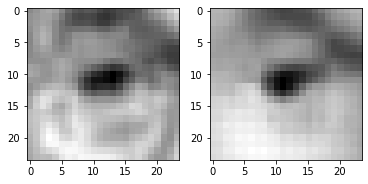

3291 0.0027221248019486666
3292 0.0025979785714298487
3293 0.0020844165701419115
3294 0.002006122376769781
3295 0.00251418212428689
3296 0.002653714269399643
3297 0.0023456932976841927
3298 0.0020127578172832727
3299 0.003905547084286809
3300 0.0027901725843548775


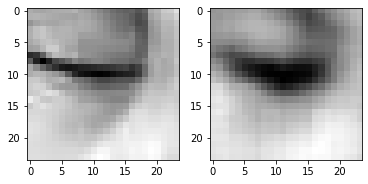

3301 0.0029873952735215425
3302 0.0023929295130074024
3303 0.0020428013522177935
3304 0.0022477449383586645
3305 0.0026764897629618645
3306 0.002997020957991481
3307 0.0020210235379636288
3308 0.0020951309707015753
3309 0.0029600649140775204
3310 0.002299268264323473


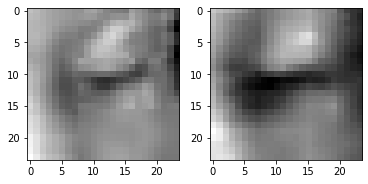

3311 0.0021433953661471605
3312 0.0018593684071674943
3313 0.0024947014171630144
3314 0.00296184909529984
3315 0.0020478132646530867
3316 0.002122988924384117
3317 0.002417986514046788
3318 0.0026731640100479126
3319 0.0021401222329586744
3320 0.001803201506845653


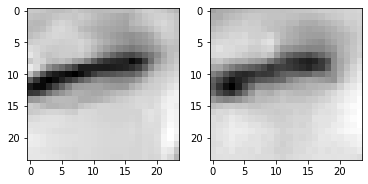

3321 0.002176404930651188
3322 0.002111325738951564
3323 0.0021238180343061686
3324 0.0020566806197166443
3325 0.00255085458047688
3326 0.002319068880751729
3327 0.001809584558941424
3328 0.0021442368160933256
3329 0.0059318882413208485
3330 0.002263837493956089


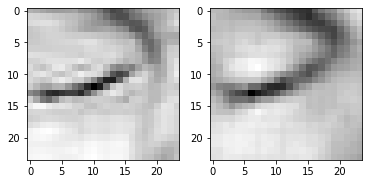

3331 0.0034228134900331497
3332 0.0024889688938856125
3333 0.0023555047810077667
3334 0.0023678590077906847
3335 0.0020496740471571684
3336 0.001990413526073098
3337 0.002630028175190091
3338 0.00201615784317255
3339 0.0019987181294709444
3340 0.0022552807349711657


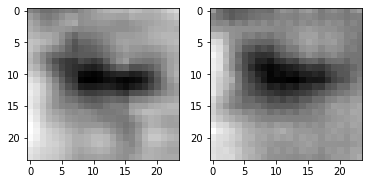

3341 0.002221267204731703
3342 0.0020783820655196905
3343 0.002055596560239792
3344 0.003741336753591895
3345 0.0018600954208523035
3346 0.0021751918829977512
3347 0.0022165898699313402
3348 0.00299854320473969
3349 0.0024396025110036135
3350 0.002173998625949025


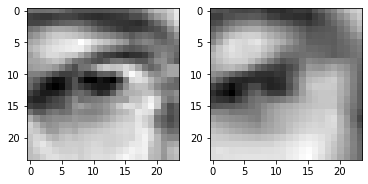

3351 0.0022540721110999584
3352 0.00273684854619205
3353 0.002623130800202489
3354 0.0021650823764503
3355 0.0021430638153105974
3356 0.0020560775883495808
3357 0.0025210820604115725
3358 0.002090132562443614
3359 0.0047185602597892284
3360 0.002231001853942871


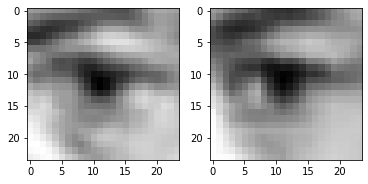

3361 0.0021825109142810106
3362 0.0023498788941651583
3363 0.0029230632353574038
3364 0.002141253324225545
3365 0.0024260603822767735
3366 0.002431325614452362
3367 0.002516824984923005
3368 0.0018675089813768864
3369 0.0020917814690619707
3370 0.0019814292900264263


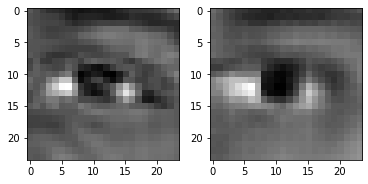

3371 0.0019472762942314148
3372 0.0021858045365661383
3373 0.0024738290812820196
3374 0.0035245800390839577
3375 0.0021800892427563667
3376 0.0021618094760924578
3377 0.0027011383790522814
3378 0.002072123344987631
3379 0.0027886659372597933
3380 0.0019369665533304214


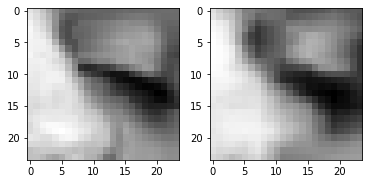

3381 0.002286207862198353
3382 0.002414299873635173
3383 0.002633818658068776
3384 0.002207579091191292
3385 0.0020447729621082544
3386 0.0029301021713763475
3387 0.00239351112395525
3388 0.001796232769265771
3389 0.0037820024881511927
3390 0.0019475099397823215


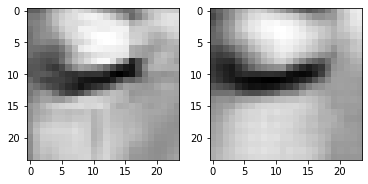

3391 0.002089433604851365
3392 0.002032943069934845
3393 0.0020677968859672546
3394 0.0018782048719003797
3395 0.0022049248218536377
3396 0.00210294546559453
3397 0.0018575763097032905
3398 0.002315261634066701
3399 0.0018346282886341214
3400 0.002390520879998803


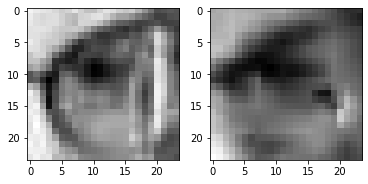

3401 0.001955647487193346
3402 0.0016843497287482023
3403 0.001843075966462493
3404 0.003772021969780326
3405 0.0021700498182326555
3406 0.0026297320146113634
3407 0.002041924512013793
3408 0.0021092386450618505
3409 0.002002438995987177
3410 0.0019795068074017763


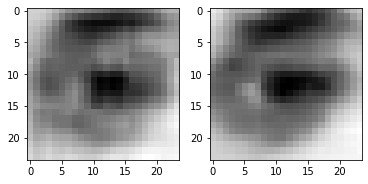

3411 0.0020287164952605963
3412 0.0022771942894905806
3413 0.0019181743264198303
3414 0.002047184854745865
3415 0.002162375720217824
3416 0.0019386251224204898
3417 0.0018783935811370611
3418 0.0018215557793155313
3419 0.0033391471952199936
3420 0.0019043982028961182


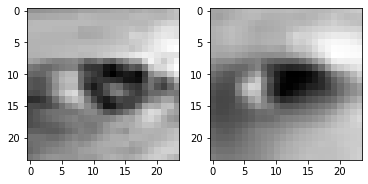

3421 0.002010618569329381
3422 0.002472488908097148
3423 0.0020279199816286564
3424 0.0018856360111385584
3425 0.002122480422258377
3426 0.001951620215550065
3427 0.0021413483191281557
3428 0.0019392573740333319
3429 0.002245228039100766
3430 0.001765362685546279


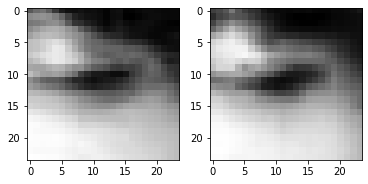

3431 0.001900256727822125
3432 0.0020365624222904444
3433 0.001840796903707087
3434 0.004998774267733097
3435 0.0020038359798491
3436 0.00264564948156476
3437 0.0020849464926868677
3438 0.001988376723602414
3439 0.002160537289455533
3440 0.002471000887453556


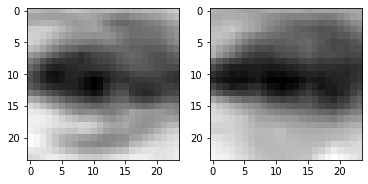

3441 0.0019313445081934333
3442 0.002049979753792286
3443 0.0024593062698841095
3444 0.0022435400169342756
3445 0.002338980557397008
3446 0.0021443781442940235
3447 0.002613994525745511
3448 0.003257371950894594
3449 0.006658585742115974
3450 0.002492091618478298


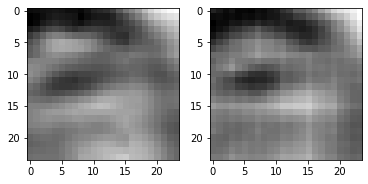

3451 0.003263320541009307
3452 0.00454317731782794
3453 0.0026478718500584364
3454 0.002387423301115632
3455 0.0025842704344540834
3456 0.002362628700211644
3457 0.0024998041335493326
3458 0.0022126431576907635
3459 0.0023742925841361284
3460 0.002219320274889469


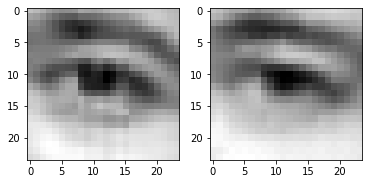

3461 0.0022482438944280148
3462 0.0024846552405506372
3463 0.0021391070913523436
3464 0.0031661291141062975
3465 0.0020564028527587652
3466 0.001975998282432556
3467 0.001997583080083132
3468 0.002412997419014573
3469 0.0020440067164599895
3470 0.002044995781034231


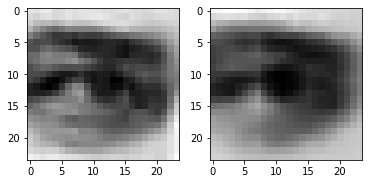

3471 0.002648233436048031
3472 0.00202609202824533
3473 0.001967537449672818
3474 0.002376432064920664
3475 0.0018543154001235962
3476 0.0019458524184301496
3477 0.0017008037539198995
3478 0.0019004676723852754
3479 0.002313429256901145
3480 0.0018465138273313642


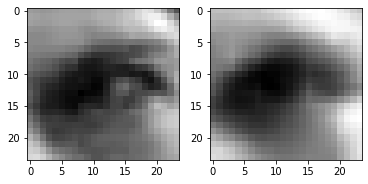

3481 0.002294337609782815
3482 0.001987658441066742
3483 0.001988148083910346
3484 0.0020998006220906973
3485 0.0019241704139858484
3486 0.002324637258425355
3487 0.0017320873448625207
3488 0.00203972146846354
3489 0.0028398572467267513
3490 0.0018480252474546432


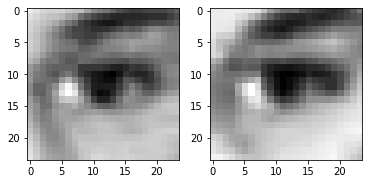

3491 0.0019789920188486576
3492 0.001943022827617824
3493 0.001850356929935515
3494 0.0027512842789292336
3495 0.0018916291883215308
3496 0.0022355946712195873
3497 0.0022047730162739754
3498 0.0020158987026661634
3499 0.0018347179284319282
3500 0.0019137728959321976


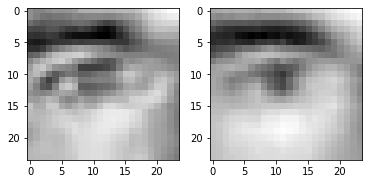

3501 0.0019069404806941748
3502 0.0020550391636788845
3503 0.0019682433921843767
3504 0.0020625791512429714
3505 0.0020570808555930853
3506 0.0018511917442083359
3507 0.0025714184157550335
3508 0.0018743338296189904
3509 0.0032140186522156
3510 0.0024888606276363134


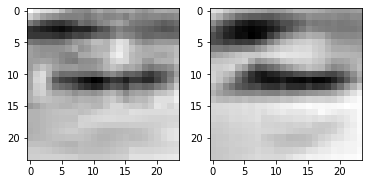

3511 0.002711473498493433
3512 0.002401102799922228
3513 0.002141875447705388
3514 0.0020418548956513405
3515 0.0026894297916442156
3516 0.0024714001920074224
3517 0.0019576505292207003
3518 0.0020218032877892256
3519 0.0019633325282484293
3520 0.002051952527835965


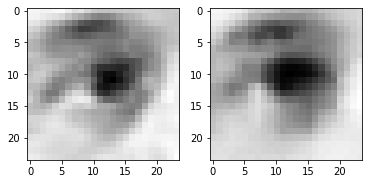

3521 0.0019664722494781017
3522 0.0018785811262205243
3523 0.003011023625731468
3524 0.009126552380621433
3525 0.0025186650454998016
3526 0.003315990325063467
3527 0.0028956737369298935
3528 0.002355757402256131
3529 0.002138013718649745
3530 0.0024083973839879036


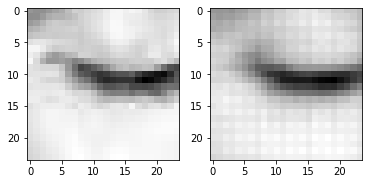

3531 0.0024066048208624125
3532 0.002320809056982398
3533 0.002002259250730276
3534 0.0020735992584377527
3535 0.0022041834890842438
3536 0.0021107946522533894
3537 0.0026174108497798443
3538 0.0020415778271853924
3539 0.005708044860512018
3540 0.0019292546203359962


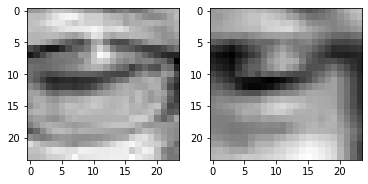

3541 0.002463494660332799
3542 0.003082538489252329
3543 0.002157835057005286
3544 0.002007444854825735
3545 0.002234372543171048
3546 0.0021745115518569946
3547 0.0022107528056949377
3548 0.0023907539434731007
3549 0.0020884075202047825
3550 0.0021630676928907633


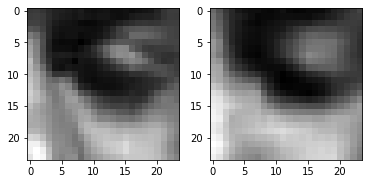

3551 0.0021146119106560946
3552 0.002304383087903261
3553 0.0020324653014540672
3554 0.0034599422942847013
3555 0.0022332824300974607
3556 0.0024737969506531954
3557 0.002355212578549981
3558 0.002097712829709053
3559 0.0034743319265544415
3560 0.0019649185705929995


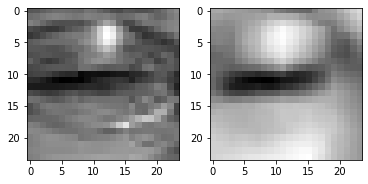

3561 0.0026410832069814205
3562 0.0024140854366123676
3563 0.0021221928764134645
3564 0.0023655432742089033
3565 0.002178395865485072
3566 0.0019278456456959248
3567 0.001936674932949245
3568 0.0018318119691684842
3569 0.002491212682798505
3570 0.0021176559384912252


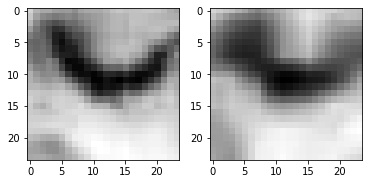

3571 0.002765751676633954
3572 0.0021484196186065674
3573 0.0022107893601059914
3574 0.002189394785091281
3575 0.0023768884129822254
3576 0.0019541962537914515
3577 0.001772304647602141
3578 0.0018931567901745439
3579 0.002288897754624486
3580 0.001980044413357973


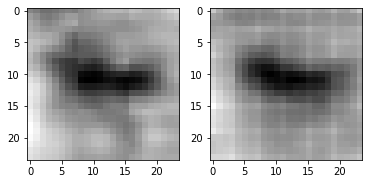

3581 0.002029923489317298
3582 0.0019912319257855415
3583 0.0019976827315986156
3584 0.002889673924073577
3585 0.0019875613506883383
3586 0.0038583027198910713
3587 0.0023209850769490004
3588 0.0020272487308830023
3589 0.002323681255802512
3590 0.002327046589925885


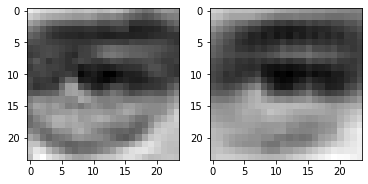

3591 0.002011488191783428
3592 0.0019999397918581963
3593 0.0017802888760343194
3594 0.0023450630251318216
3595 0.0018076379783451557
3596 0.0018215517047792673
3597 0.0018646195530891418
3598 0.0022046330850571394
3599 0.0030904081650078297
3600 0.0021522725000977516


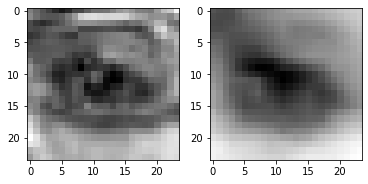

3601 0.0017606333130970597
3602 0.0019438692834228277
3603 0.0020759860053658485
3604 0.0019806637428700924
3605 0.00200691563077271
3606 0.00222257268615067
3607 0.0021314627956598997
3608 0.0021867973264306784
3609 0.0018556492868810892
3610 0.001814217888750136


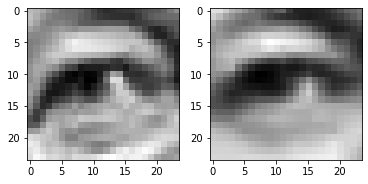

3611 0.0020787320099771023
3612 0.0020742297638207674
3613 0.001825217972509563
3614 0.0027087442576885223
3615 0.002107947366312146
3616 0.0020521734841167927
3617 0.0019677102100104094
3618 0.001982697518542409
3619 0.002212278312072158
3620 0.002313392935320735


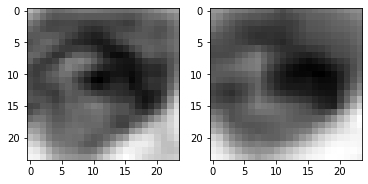

3621 0.001910662860609591
3622 0.0027423114515841007
3623 0.0018098027212545276
3624 0.002184751909226179
3625 0.0018763068364933133
3626 0.0018585696816444397
3627 0.0017318244790658355
3628 0.0021569540258497
3629 0.004099314566701651
3630 0.002132828114554286


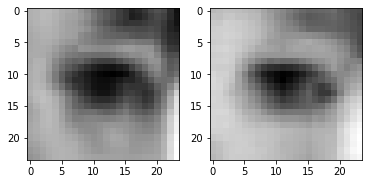

3631 0.002040968742221594
3632 0.0020283067133277655
3633 0.001967197982594371
3634 0.001926504890434444
3635 0.001987041672691703
3636 0.001956831431016326
3637 0.0018678467022255063
3638 0.0018930435180664062
3639 0.001947862794622779
3640 0.0022262418642640114


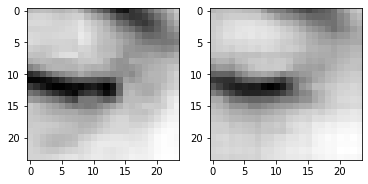

3641 0.0018189458642154932
3642 0.0017043919069692492
3643 0.0018759523518383503
3644 0.00931998249143362
3645 0.003309832187369466
3646 0.004323373083025217
3647 0.0028431073296815157
3648 0.0022552974987775087
3649 0.0023252300452440977
3650 0.002300116466358304


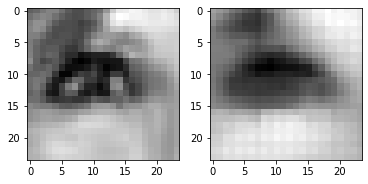

3651 0.002758137183263898
3652 0.0021841542329639196
3653 0.0021890834905207157
3654 0.0024073768872767687
3655 0.00212117494083941
3656 0.00209057261236012
3657 0.0021843796130269766
3658 0.002244102768599987
3659 0.008264136500656605
3660 0.003721989691257477


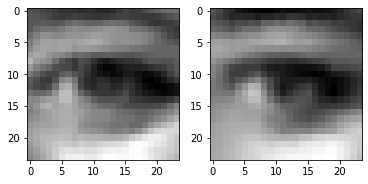

3661 0.00431713555008173
3662 0.0031157610937952995
3663 0.002109914319589734
3664 0.0024730470031499863
3665 0.002607776550576091
3666 0.003697585314512253
3667 0.0029719818849116564
3668 0.0024502973537892103
3669 0.0022883957717567682
3670 0.0028456884901970625


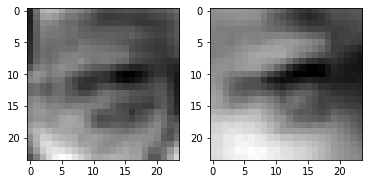

3671 0.003355418099090457
3672 0.002147351624444127
3673 0.002529778052121401
3674 0.009849649854004383
3675 0.0021132263354957104
3676 0.003620404051616788
3677 0.003999301698058844
3678 0.003869563341140747
3679 0.0021640020422637463
3680 0.0033605839125812054


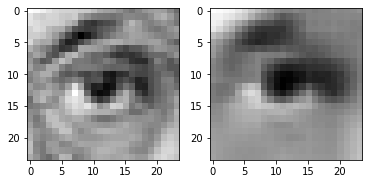

3681 0.003786338260397315
3682 0.0027984492480754852
3683 0.0028917519375681877
3684 0.00275814370252192
3685 0.0028400036972016096
3686 0.0025409397203475237
3687 0.0028247421141713858
3688 0.002956945449113846
3689 0.005297502037137747
3690 0.002605841960757971


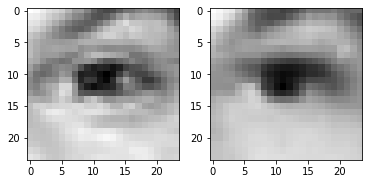

3691 0.002799899550154805
3692 0.0027563937474042177
3693 0.00310471816919744
3694 0.0025592416059225798
3695 0.0024434193037450314
3696 0.0026687912177294493
3697 0.0024805006105452776
3698 0.004195941612124443
3699 0.00315661309286952
3700 0.0023500556126236916


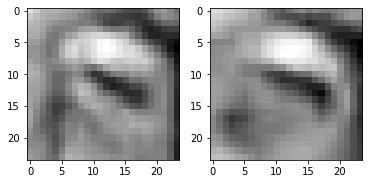

3701 0.00279227108694613
3702 0.0026046945713460445
3703 0.0033857610542327166
3704 0.00424007186666131
3705 0.0022570251021534204
3706 0.002555059501901269
3707 0.0026379514019936323
3708 0.003256551455706358
3709 0.0023266838397830725
3710 0.0021731748711317778


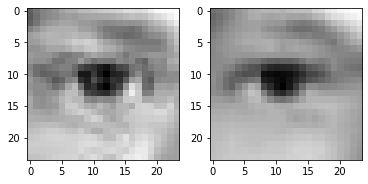

3711 0.0025751153007149696
3712 0.002160628791898489
3713 0.002075453521683812
3714 0.0023659858852624893
3715 0.0022810238879173994
3716 0.002346545923501253
3717 0.001986674265936017
3718 0.002040346385911107
3719 0.004641955252736807
3720 0.0024656292516738176


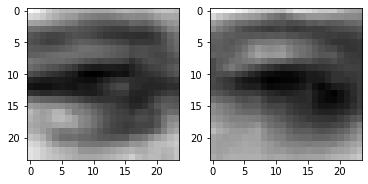

3721 0.0025974188465625048
3722 0.0021844913717359304
3723 0.0024853043723851442
3724 0.0020855821203440428
3725 0.002648361725732684
3726 0.0020412681624293327
3727 0.002163040218874812
3728 0.0022305918391793966
3729 0.0019910987466573715
3730 0.0023868593852967024


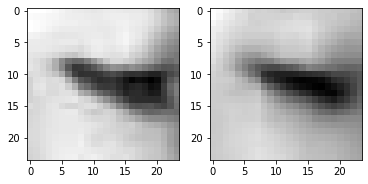

3731 0.0024100393056869507
3732 0.002022584667429328
3733 0.0023682976607233286
3734 0.0029050775337964296
3735 0.0026329956017434597
3736 0.0022192129399627447
3737 0.0029547037556767464
3738 0.002403728198260069
3739 0.0020956152584403753
3740 0.0022189149167388678


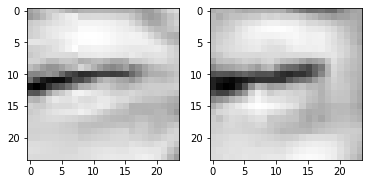

3741 0.002165145007893443
3742 0.0026568800676614046
3743 0.002260846784338355
3744 0.002122000092640519
3745 0.0019473094725981355
3746 0.0028137476183474064
3747 0.002112520160153508
3748 0.0019540770445019007
3749 0.003656138200312853
3750 0.0025033208075910807


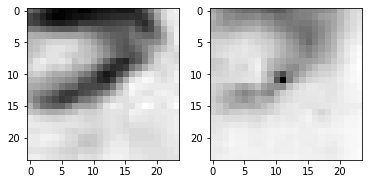

3751 0.0021504443138837814
3752 0.0023028196301311255
3753 0.0023803249932825565
3754 0.002164600882679224
3755 0.0020361077040433884
3756 0.0020340413320809603
3757 0.0024510291405022144
3758 0.0023229264188557863
3759 0.002019819337874651
3760 0.002007121220231056


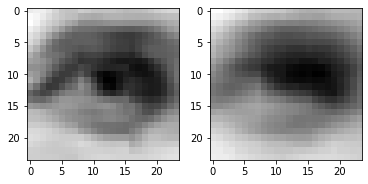

3761 0.0023954296484589577
3762 0.0022641271352767944
3763 0.0018911181250587106
3764 0.0036576795391738415
3765 0.0018254593014717102
3766 0.002136589027941227
3767 0.0023461710661649704
3768 0.0022282260470092297
3769 0.0021428531035780907
3770 0.0018084680195897818


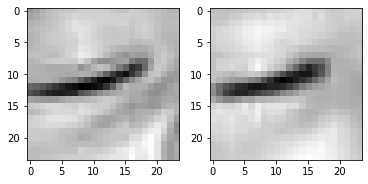

3771 0.0020672939717769623
3772 0.0018863353179767728
3773 0.002032034331932664
3774 0.002119892742484808
3775 0.002046292880550027
3776 0.0018324514385312796
3777 0.002127518178895116
3778 0.0019685837905853987
3779 0.003419175511226058
3780 0.001922131865285337


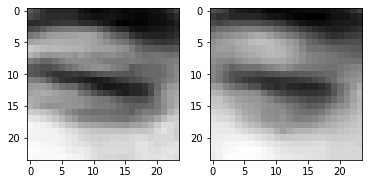

3781 0.002017701044678688
3782 0.002104412764310837
3783 0.002080420730635524
3784 0.00196321913972497
3785 0.0021125124767422676
3786 0.0019173481268808246
3787 0.0021545186173170805
3788 0.00206551980227232
3789 0.0020022187381982803
3790 0.0018623281503096223


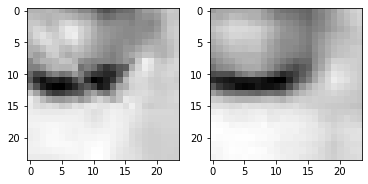

3791 0.001824726932682097
3792 0.0024353633634746075
3793 0.0018414995865896344
3794 0.003454175777733326
3795 0.0018672285368666053
3796 0.0022414305713027716
3797 0.0026388836558908224
3798 0.0024832834023982286
3799 0.0023127964232116938
3800 0.0020002401433885098


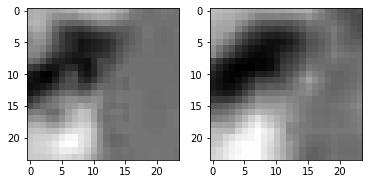

3801 0.0039720842614769936
3802 0.0020760504994541407
3803 0.002174661960452795
3804 0.0019475097069516778
3805 0.0020311851985752583
3806 0.001917302026413381
3807 0.00198280718177557
3808 0.0018143949564546347
3809 0.0036639156751334667
3810 0.0019423355115577579


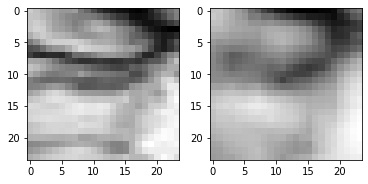

3811 0.0024118211586028337
3812 0.001938908244483173
3813 0.001980182947590947
3814 0.0020362483337521553
3815 0.002031560055911541
3816 0.0019061091588810086
3817 0.0021584811620414257
3818 0.0021240294445306063
3819 0.0020773811265826225
3820 0.0029752578120678663


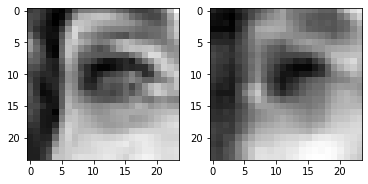

3821 0.001940097426995635
3822 0.0020881688687950373
3823 0.002449456136673689
3824 0.0058884103782474995
3825 0.0019442904740571976
3826 0.0020636010449379683
3827 0.004103171173483133
3828 0.0028803308960050344
3829 0.0019750630017369986
3830 0.0017853075405582786


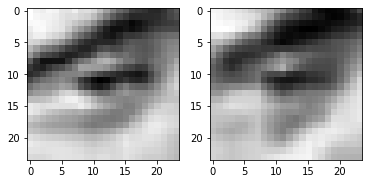

3831 0.00237426464445889
3832 0.002186395227909088
3833 0.002018376486375928
3834 0.0018195667071267962
3835 0.0020581320859491825
3836 0.001955021172761917
3837 0.002203357871621847
3838 0.0018835634691640735
3839 0.0034579746425151825
3840 0.002325400011613965


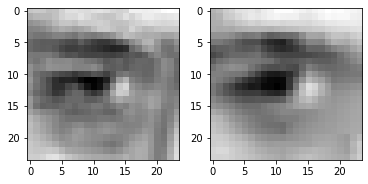

3841 0.0021497770212590694
3842 0.0023609413765370846
3843 0.00194802216719836
3844 0.001985182287171483
3845 0.002124218735843897
3846 0.0019919772166758776
3847 0.0020459170918911695
3848 0.002155619440600276
3849 0.00228299293667078
3850 0.00198897416703403


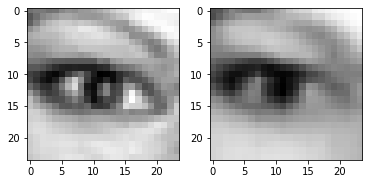

3851 0.0018641749629750848
3852 0.002107255859300494
3853 0.0022076319437474012
3854 0.00545350369066
3855 0.0021872699726372957
3856 0.002594458172097802
3857 0.0027206006925553083
3858 0.0023279376327991486
3859 0.0020062546245753765
3860 0.0020364848896861076


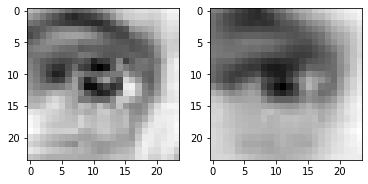

3861 0.002930192742496729
3862 0.0028596404008567333
3863 0.0020193036179989576
3864 0.0018758416408672929
3865 0.002004005713388324
3866 0.0025511677376925945
3867 0.0021820133551955223
3868 0.0020243527833372355
3869 0.006144274491816759
3870 0.00327225960791111


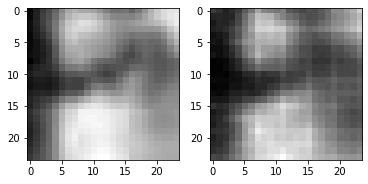

3871 0.0036347450222820044
3872 0.0027325619012117386
3873 0.0021106742788106203
3874 0.002334092976525426
3875 0.002163207856938243
3876 0.0025453250855207443
3877 0.002679805038496852
3878 0.0021367950830608606
3879 0.0023254251573234797
3880 0.002294505713507533


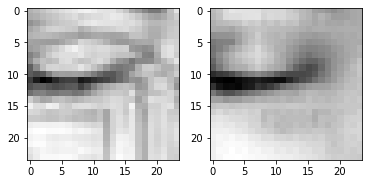

3881 0.002182194497436285
3882 0.0019894097931683064
3883 0.0021380784455686808
3884 0.0034784707240760326
3885 0.002087314845994115
3886 0.003514060052111745
3887 0.0027871683705598116
3888 0.0019976841285824776
3889 0.0019507681718096137
3890 0.0020758353639394045


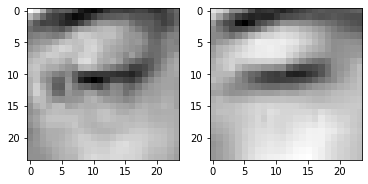

3891 0.0020020008087158203
3892 0.0023177084513008595
3893 0.0029154648073017597
3894 0.0020732562988996506
3895 0.002139552030712366
3896 0.002338545862585306
3897 0.0025719727855175734
3898 0.0021162969060242176
3899 0.00892737228423357
3900 0.002386335050687194


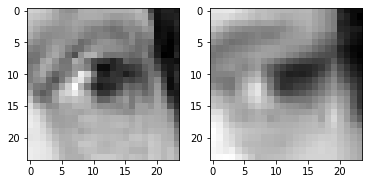

3901 0.004134353715926409
3902 0.003203913802281022
3903 0.003539465367794037
3904 0.003718941705301404
3905 0.002973549999296665
3906 0.0030317166820168495
3907 0.003508669324219227
3908 0.003150535048916936
3909 0.002890518633648753
3910 0.0035128453746438026


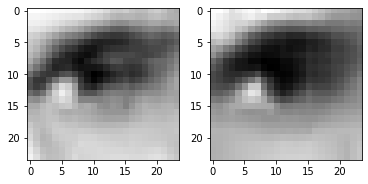

3911 0.0027648834511637688
3912 0.0028601426165550947
3913 0.002478912705555558
3914 0.0041260081343352795
3915 0.002400230150669813
3916 0.002633847761899233
3917 0.002522918162867427
3918 0.0024343798868358135
3919 0.002219446701928973
3920 0.0025012099649757147


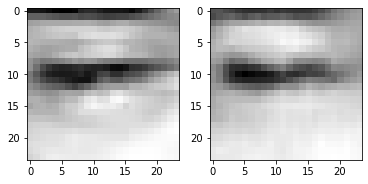

3921 0.0023877318017184734
3922 0.0021507081110030413
3923 0.00216621533036232
3924 0.0029222534503787756
3925 0.0026595324743539095
3926 0.002283864887431264
3927 0.0029203728772699833
3928 0.0025957422330975533
3929 0.0031759035773575306
3930 0.002424936043098569


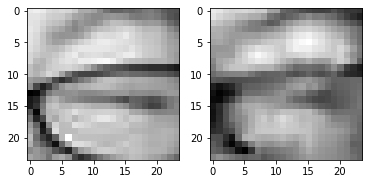

3931 0.0028071696870028973
3932 0.002435647416859865
3933 0.0022505915258079767
3934 0.0024011002387851477
3935 0.002130807377398014
3936 0.0023319812025874853
3937 0.0025997927878051996
3938 0.0019832199905067682
3939 0.0023216891568154097
3940 0.002212727442383766


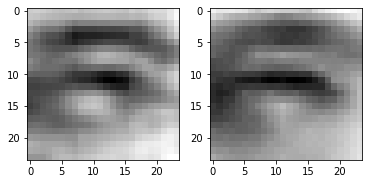

3941 0.0022351027000695467
3942 0.002035257639363408
3943 0.001972722355276346
3944 0.0027582074981182814
3945 0.002372435759752989
3946 0.0021418731193989515
3947 0.002295491984114051
3948 0.0023668925277888775
3949 0.0020997340325266123
3950 0.0027301425579935312


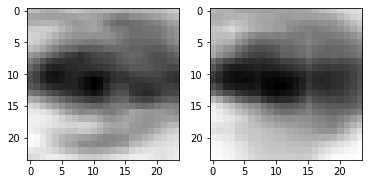

3951 0.002534961560741067
3952 0.0021797113586217165
3953 0.002094478579238057
3954 0.001983116613700986
3955 0.0019499800400808454
3956 0.002109918976202607
3957 0.0022725360468029976
3958 0.0022551368456333876
3959 0.0046018920838832855
3960 0.0018434436060488224


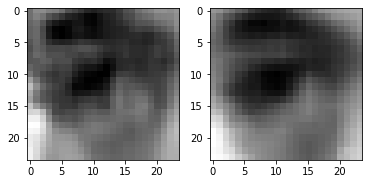

3961 0.002060194732621312
3962 0.0021976123098284006
3963 0.002235709922388196
3964 0.002121369820088148
3965 0.0020686606876552105
3966 0.0021085434127599
3967 0.0021054840181022882
3968 0.001924749929457903
3969 0.0020312482956796885
3970 0.0019173589535057545


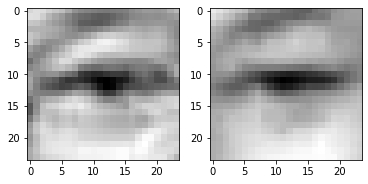

3971 0.0019574048928916454
3972 0.0019866488873958588
3973 0.0021573230624198914
3974 0.0031601106747984886
3975 0.001868154271505773
3976 0.0021499469876289368
3977 0.002275769831612706
3978 0.0022934391163289547
3979 0.0018694220343604684
3980 0.002085425890982151


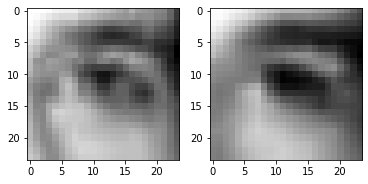

3981 0.0023221212904900312
3982 0.0018058483256027102
3983 0.0017260267632082105
3984 0.0024727971758693457
3985 0.0019210869213566184
3986 0.0020900594536215067
3987 0.0018626073142513633
3988 0.002058224519714713
3989 0.004006927367299795
3990 0.001955900341272354


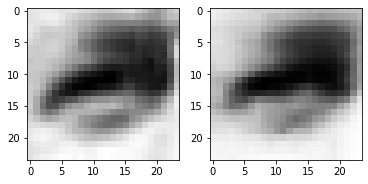

3991 0.0023020142689347267
3992 0.002862924477085471
3993 0.0017745883669704199
3994 0.001816607196815312
3995 0.0019554097671061754
3996 0.0023603993467986584
3997 0.001826134859584272
3998 0.0017821259098127484
3999 0.0019027699017897248
4000 0.0021414747461676598


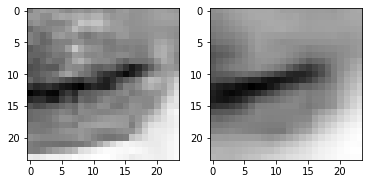

4001 0.0019005653448402882
4002 0.0017675821436569095
4003 0.0018350784666836262
4004 0.0034049120731651783
4005 0.0018278261413797736
4006 0.0020621081348508596
4007 0.0022516180761158466
4008 0.001945718307979405
4009 0.0026013797614723444
4010 0.001691219164058566


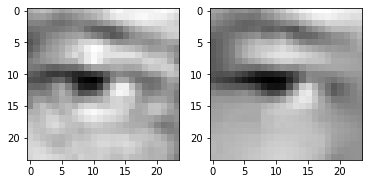

4011 0.0020420800428837538
4012 0.0020662923343479633
4013 0.0023063775151968002
4014 0.001847528386861086
4015 0.0021583412308245897
4016 0.0022472164127975702
4017 0.0018675976898521185
4018 0.001782609149813652
4019 0.005385859869420528
4020 0.0024236496537923813


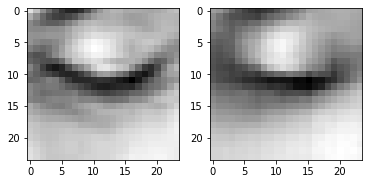

4021 0.004360377322882414
4022 0.004072240088135004
4023 0.002708339598029852
4024 0.0019545035902410746
4025 0.0027390134055167437
4026 0.005404662806540728
4027 0.0027278224006295204
4028 0.00227114069275558
4029 0.00225144368596375
4030 0.003378296038135886


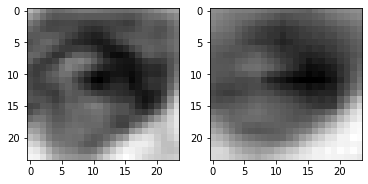

4031 0.0029823705554008484
4032 0.0021107082720845938
4033 0.0019970228895545006
4034 0.008905281312763691
4035 0.0035045736003667116
4036 0.0031728981994092464
4037 0.0037250416353344917
4038 0.0037472674157470465
4039 0.002320525934919715
4040 0.003354178974404931


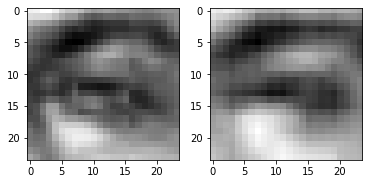

4041 0.003280343022197485
4042 0.003436597529798746
4043 0.002235307125374675
4044 0.0029900886584073305
4045 0.0028686237055808306
4046 0.0027021681889891624
4047 0.002484721364453435
4048 0.002767004072666168
4049 0.00281659048050642
4050 0.002524418756365776


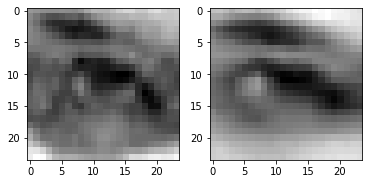

4051 0.0024326469283550978
4052 0.002206729957833886
4053 0.0021372276823967695
4054 0.0023363246582448483
4055 0.0027289490681141615
4056 0.002314229728654027
4057 0.002744366182014346
4058 0.0021005398593842983
4059 0.002201406517997384
4060 0.0029140638653188944


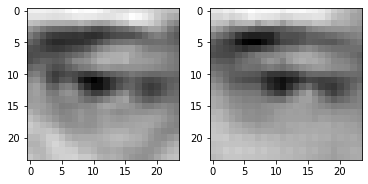

4061 0.0020645176991820335
4062 0.0020382956136018038
4063 0.0023469789884984493
4064 0.0039027605671435595
4065 0.0027793210465461016
4066 0.002571866614744067
4067 0.0022568656131625175
4068 0.0020530286710709333
4069 0.0021681899670511484
4070 0.0021302755922079086


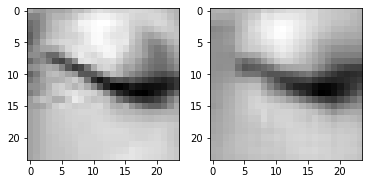

4071 0.0024264389649033546
4072 0.002111070090904832
4073 0.0022143502719700336
4074 0.0019622358959168196
4075 0.001793591887690127
4076 0.0021602462511509657
4077 0.0021234112791717052
4078 0.0019474244909361005
4079 0.004614220466464758
4080 0.00218973308801651


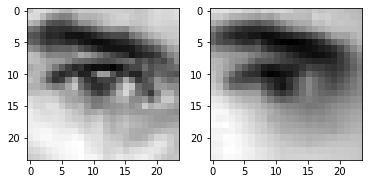

4081 0.0023247164208441973
4082 0.0018415400991216302
4083 0.0022486832458525896
4084 0.001977604115381837
4085 0.0019224254647269845
4086 0.002311434829607606
4087 0.0023045274429023266
4088 0.0018208622932434082
4089 0.0019023322965949774
4090 0.00217050570063293


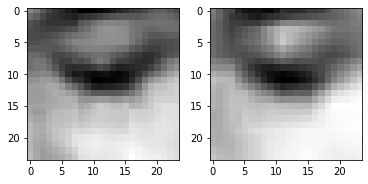

4091 0.0022053606808185577
4092 0.0022244493011385202
4093 0.0018845945596694946
4094 0.004420843441039324
4095 0.001971340971067548
4096 0.0029367604292929173
4097 0.002389162080362439
4098 0.0025214527267962694
4099 0.0028546724934130907
4100 0.0029176610987633467


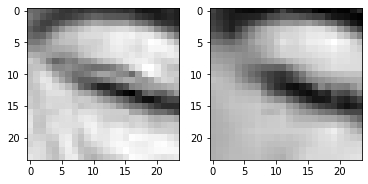

4101 0.0020694651175290346
4102 0.0028103236109018326
4103 0.0037659171503037214
4104 0.002271344419568777
4105 0.00193628272973001
4106 0.0026231424417346716
4107 0.0021639675833284855
4108 0.0029823717195540667
4109 0.003444546600803733
4110 0.0019875247962772846


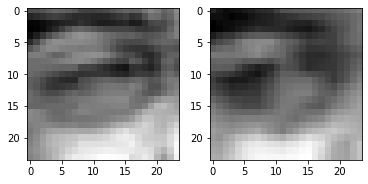

4111 0.00317356176674366
4112 0.003154602600261569
4113 0.002782591385766864
4114 0.0022342209704220295
4115 0.0020622173324227333
4116 0.0029106405563652515
4117 0.003231379436329007
4118 0.0023993265349417925
4119 0.002231340389698744
4120 0.002087616827338934


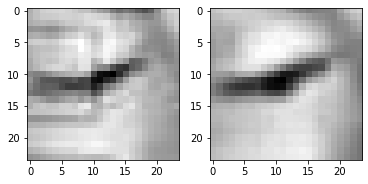

4121 0.0030278521589934826
4122 0.0028921966440975666
4123 0.0021836338564753532
4124 0.004629740957170725
4125 0.002071699593216181
4126 0.0022601003292948008
4127 0.0020760418847203255
4128 0.002069964539259672
4129 0.002205129247158766
4130 0.001980645814910531


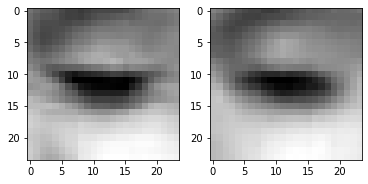

4131 0.0023368250112980604
4132 0.002668320434167981
4133 0.002498569432646036
4134 0.0018701934022828937
4135 0.001987181603908539
4136 0.002520505338907242
4137 0.0022431083489209414
4138 0.0019763533491641283
4139 0.0050484673120081425
4140 0.0018192945281043649


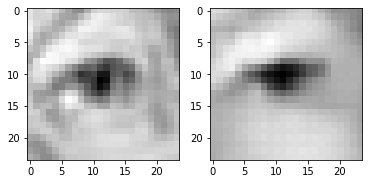

4141 0.0034232325851917267
4142 0.0027173208072781563
4143 0.00252800271846354
4144 0.002091372851282358
4145 0.0021982959005981684
4146 0.002774602035060525
4147 0.0027072762604802847
4148 0.0021457625553011894
4149 0.0020528784953057766
4150 0.0020022259559482336


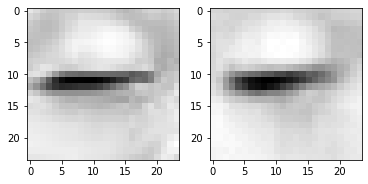

4151 0.0020219748839735985
4152 0.0020375591702759266
4153 0.002027687383815646
4154 0.0030644775833934546
4155 0.0019611294846981764
4156 0.001993301324546337
4157 0.0022099337074905634
4158 0.002179904142394662
4159 0.0020694483537226915
4160 0.001965512754395604


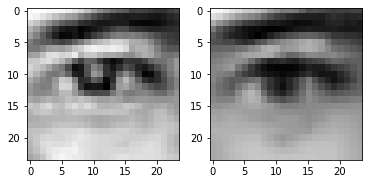

4161 0.0019799352157860994
4162 0.001964201685041189
4163 0.0019399333978071809
4164 0.00190185965038836
4165 0.0018681010697036982
4166 0.0018593424465507269
4167 0.0020225674379616976
4168 0.0019429472740739584
4169 0.006928425747901201
4170 0.002608455717563629


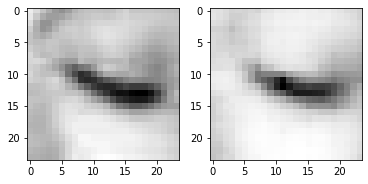

4171 0.002263938309624791
4172 0.003035373520106077
4173 0.002533894730731845
4174 0.0022585478145629168
4175 0.002254944294691086
4176 0.002155552851036191
4177 0.0021212405990809202
4178 0.0021024788729846478
4179 0.0024285323452204466
4180 0.0019289484480395913


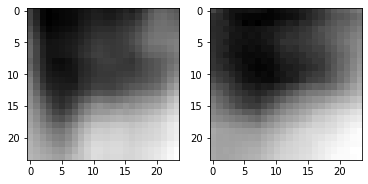

4181 0.0021934318356215954
4182 0.002047804417088628
4183 0.002176502952352166
4184 0.004351396579295397
4185 0.0022642957046628
4186 0.002364841289818287
4187 0.002679739845916629
4188 0.00225155521184206
4189 0.0021197109017521143
4190 0.0021052889060229063


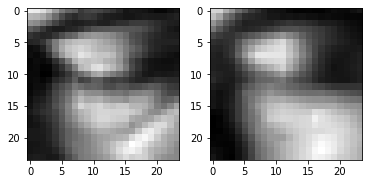

4191 0.001971470657736063
4192 0.002100126352161169
4193 0.0030067942570894957
4194 0.0019900756888091564
4195 0.002020556014031172
4196 0.002221080008894205
4197 0.002099422737956047
4198 0.002333595184609294
4199 0.003831028938293457
4200 0.0027438842225819826


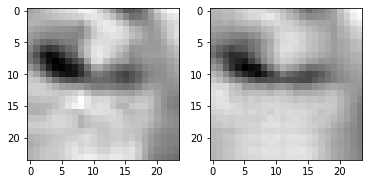

4201 0.003188940929248929
4202 0.002349951071664691
4203 0.0023177945986390114
4204 0.0019538328051567078
4205 0.0023676021955907345
4206 0.002576767234131694
4207 0.0025750515051186085
4208 0.0019140411168336868
4209 0.002035590121522546
4210 0.002260421635583043


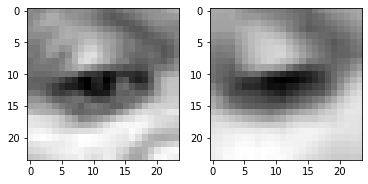

4211 0.0019788562785834074
4212 0.002093413146212697
4213 0.0019916400779038668
4214 0.0031792307272553444
4215 0.0019238503882661462
4216 0.002033086959272623
4217 0.001883065328001976
4218 0.0025075997691601515
4219 0.0019324620952829719
4220 0.0020343547221273184


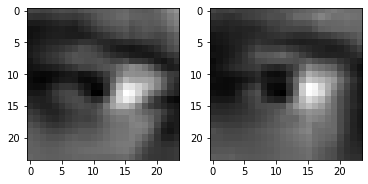

4221 0.0019589753355830908
4222 0.002119669457897544
4223 0.0019250777550041676
4224 0.0018391486955806613
4225 0.0018266630358994007
4226 0.0023902440443634987
4227 0.0020906245335936546
4228 0.0019014411373063922
4229 0.0026126888114959
4230 0.002071329625323415


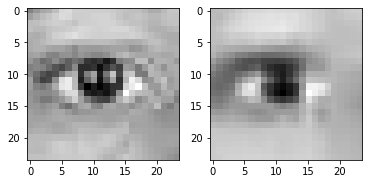

4231 0.002066008048132062
4232 0.002074575750157237
4233 0.0019389574881643057
4234 0.0018502117600291967
4235 0.0018400566186755896
4236 0.002030137227848172
4237 0.001739047234877944
4238 0.0018392697675153613
4239 0.0019885816145688295
4240 0.0026884085964411497


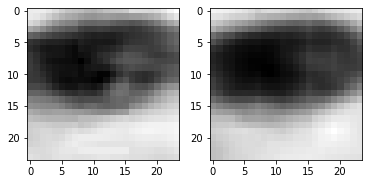

4241 0.002279976848512888
4242 0.001877071801573038
4243 0.0018467638874426484
4244 0.004124283790588379
4245 0.00263247755356133
4246 0.002217691857367754
4247 0.0024544468615204096
4248 0.001995277823880315
4249 0.0020242466125637293
4250 0.0023701679892838


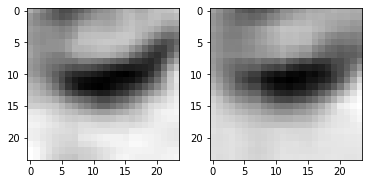

4251 0.0021742095705121756
4252 0.0022283883299678564
4253 0.0021253314334899187
4254 0.002388949738815427
4255 0.002236386062577367
4256 0.002071336843073368
4257 0.001809758017770946
4258 0.0018868321785703301
4259 0.002867338713258505
4260 0.0020275425631552935


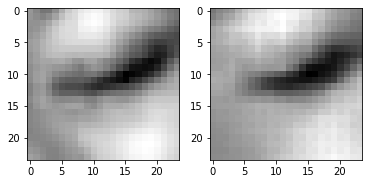

4261 0.002495978493243456
4262 0.0024367435835301876
4263 0.0024410986807197332
4264 0.0019546905532479286
4265 0.00246864533983171
4266 0.002082758117467165
4267 0.002014369238168001
4268 0.0021319191437214613
4269 0.0017512792255729437
4270 0.001883740653283894


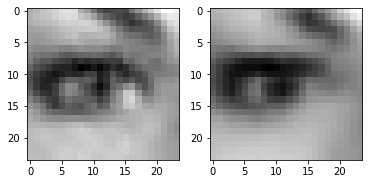

4271 0.0019045714288949966
4272 0.0019187062280252576
4273 0.0026152951177209616
4274 0.0034270405303686857
4275 0.0019301790744066238
4276 0.001848206389695406
4277 0.0021889391355216503
4278 0.0031681861728429794
4279 0.0019511854043230414
4280 0.002069513313472271


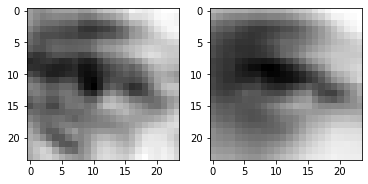

4281 0.0023836554028093815
4282 0.001881313044577837
4283 0.001844343263655901
4284 0.001786689623259008
4285 0.0024196964222937822
4286 0.0020512710325419903
4287 0.0017071525799110532
4288 0.0019974582828581333
4289 0.0027977311983704567
4290 0.002840146655216813


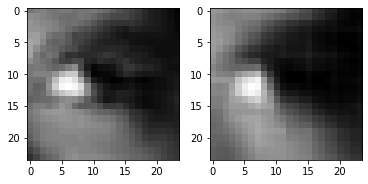

4291 0.0024523357860744
4292 0.00210764748044312
4293 0.002145289210602641
4294 0.0025863738264888525
4295 0.002001158194616437
4296 0.002915489487349987
4297 0.0032077522482722998
4298 0.0022959732450544834
4299 0.002313357312232256
4300 0.002156159607693553


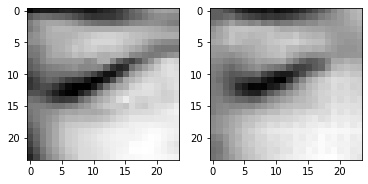

4301 0.003336212830618024
4302 0.002419685944914818
4303 0.0022600360680371523
4304 0.0030341611709445715
4305 0.0024730011355131865
4306 0.0026450345758348703
4307 0.0022845417261123657
4308 0.00226601748727262
4309 0.001958326669409871
4310 0.002078051446005702


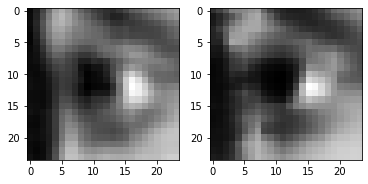

4311 0.002123406156897545
4312 0.002192720305174589
4313 0.002201312454417348
4314 0.0022755598183721304
4315 0.002147629391402006
4316 0.0023293765261769295
4317 0.0019833410624414682
4318 0.0023789904080331326
4319 0.0028736405074596405
4320 0.002167173195630312


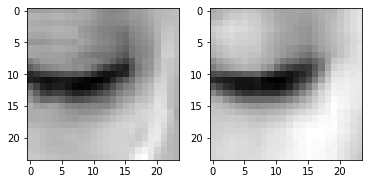

4321 0.0027461976278573275
4322 0.002997832139953971
4323 0.0024424931034445763
4324 0.002341666491702199
4325 0.002439093077555299
4326 0.002246609888970852
4327 0.00206168950535357
4328 0.001962586073204875
4329 0.0020143897272646427
4330 0.0017704932251945138


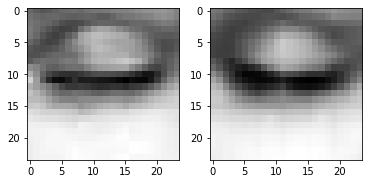

4331 0.001912738080136478
4332 0.0020155515521764755
4333 0.0022098443005234003
4334 0.003946454264223576
4335 0.002382732229307294
4336 0.0022483302745968103
4337 0.00278642144985497
4338 0.0024529690854251385
4339 0.0018932034727185965
4340 0.0024870240595191717


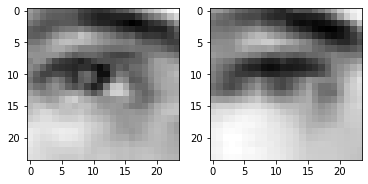

4341 0.002252558944746852
4342 0.0020275036804378033
4343 0.0018251362489536405
4344 0.0021955380216240883
4345 0.0018736784113571048
4346 0.002029603812843561
4347 0.0019208844751119614
4348 0.0020095158834010363
4349 0.002577816369011998
4350 0.0019254889339208603


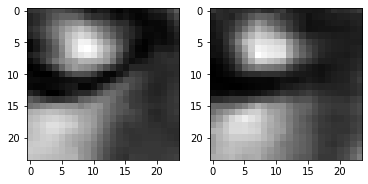

4351 0.00194024748634547
4352 0.002005311893299222
4353 0.002122524194419384
4354 0.0022673499770462513
4355 0.002091845963150263
4356 0.001983873313292861
4357 0.0021361291874200106
4358 0.0018643649527803063
4359 0.0017336838645860553
4360 0.0020178467966616154


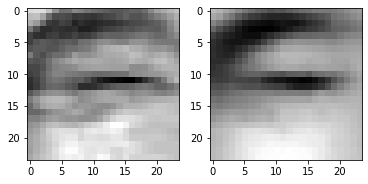

4361 0.001722972490824759
4362 0.0018502449383959174
4363 0.0017875749617815018
4364 0.0024139315355569124
4365 0.0018333797343075275
4366 0.001907878089696169
4367 0.002238271525129676
4368 0.0018802151316776872
4369 0.0019302759319543839
4370 0.001804676721803844


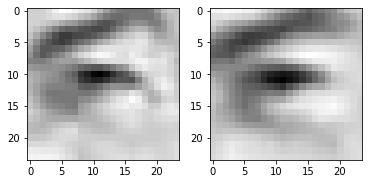

4371 0.0018252810696139932
4372 0.0021026572212576866
4373 0.001853174064308405
4374 0.0021404712460935116
4375 0.002013527788221836
4376 0.00179909891448915
4377 0.002530071185901761
4378 0.0022113409359008074
4379 0.004591517150402069
4380 0.002140785101801157


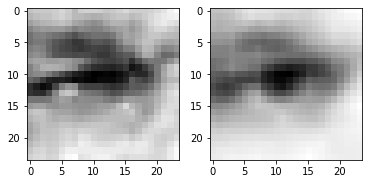

4381 0.0029630514327436686
4382 0.003774202661588788
4383 0.0025899605825543404
4384 0.0020541169214993715
4385 0.002106574596837163
4386 0.00437199417501688
4387 0.0022900167386978865
4388 0.0022426892537623644
4389 0.0019853964913636446
4390 0.0024063573218882084


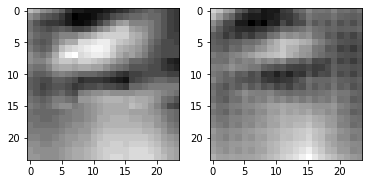

4391 0.0021861763671040535
4392 0.0026167926844209433
4393 0.002083072206005454
4394 0.004169038031250238
4395 0.0025489376857876778
4396 0.003825857536867261
4397 0.0024011286441236734
4398 0.002155334921553731
4399 0.002094070892781019
4400 0.0024857958778738976


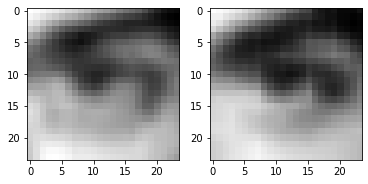

4401 0.002931716153398156
4402 0.0028336227405816317
4403 0.0022001650650054216
4404 0.0021735168993473053
4405 0.00255237752571702
4406 0.0026752848643809557
4407 0.0021676202304661274
4408 0.0022212921176105738
4409 0.003316381713375449
4410 0.002205758122727275


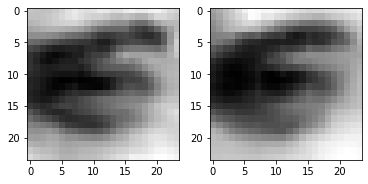

4411 0.002255266299471259
4412 0.0022982433438301086
4413 0.0021054737735539675
4414 0.0021977610886096954
4415 0.002011707052588463
4416 0.0019580416847020388
4417 0.002365072490647435
4418 0.002216948429122567
4419 0.0020697545260190964
4420 0.0023633763194084167


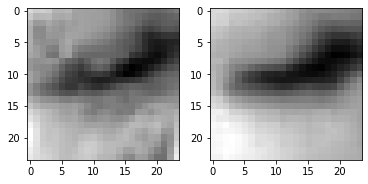

4421 0.0019505475647747517
4422 0.0020623025484383106
4423 0.0018281835364177823
4424 0.003914414439350367
4425 0.0022334717214107513
4426 0.002213303931057453
4427 0.002815656131133437
4428 0.0022718922700732946
4429 0.0021509795915335417
4430 0.0020697966683655977


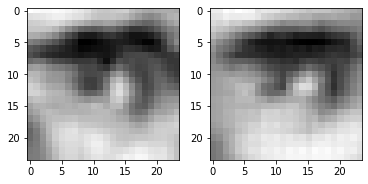

4431 0.0020031023304909468
4432 0.002132612746208906
4433 0.002365455962717533
4434 0.00183695531450212
4435 0.0020063950214535
4436 0.00236899615265429
4437 0.001750621129758656
4438 0.001910928636789322
4439 0.0032942835241556168
4440 0.002096714684739709


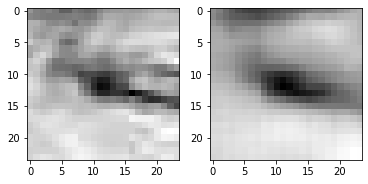

4441 0.0021887149196118116
4442 0.0028852771501988173
4443 0.002089553512632847
4444 0.0024355612695217133
4445 0.0019131677690893412
4446 0.001910315826535225
4447 0.002175478730350733
4448 0.002337411278858781
4449 0.0017803364899009466
4450 0.002215305808931589


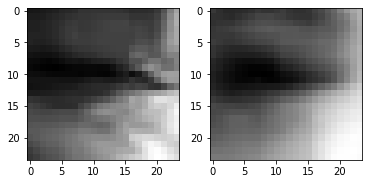

4451 0.0017952517373487353
4452 0.0019625634886324406
4453 0.0020289570093154907
4454 0.007021406665444374
4455 0.002605712739750743
4456 0.0037345075979828835
4457 0.003167106304317713
4458 0.003115404862910509
4459 0.0025386970955878496
4460 0.003155328333377838


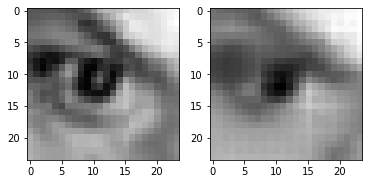

4461 0.002831560792401433
4462 0.004425096325576305
4463 0.002814239589497447
4464 0.002399595221504569
4465 0.003328826744109392
4466 0.0034070850815624
4467 0.0020572913344949484
4468 0.002154894173145294
4469 0.012606878764927387
4470 0.0024803401902318


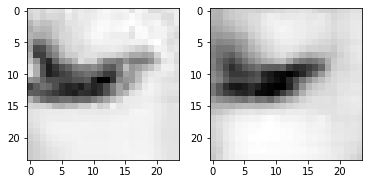

4471 0.0024514293763786554
4472 0.002462886506691575
4473 0.0040414584800601006
4474 0.0027569415979087353
4475 0.002161762909963727
4476 0.0035025470424443483
4477 0.0027982003521174192
4478 0.0022024954669177532
4479 0.002508325269445777
4480 0.0023210516665130854


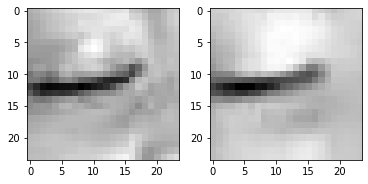

4481 0.002159944036975503
4482 0.0023135370574891567
4483 0.002111704321578145
4484 0.0070745316334068775
4485 0.0024401037953794003
4486 0.004155335016548634
4487 0.003057793714106083
4488 0.002424952806904912
4489 0.002384949941188097
4490 0.0024875099770724773


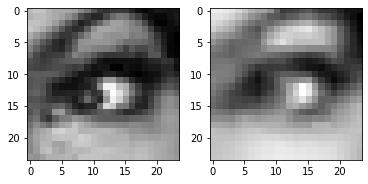

4491 0.002472800435498357
4492 0.002409548731520772
4493 0.0024489453062415123
4494 0.0021185551304370165
4495 0.002184225944802165
4496 0.002660980448126793
4497 0.00293848873116076
4498 0.0026379937771707773
4499 0.003454343182966113
4500 0.002343270229175687


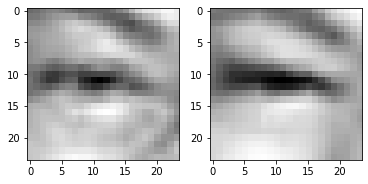

4501 0.002374527743086219
4502 0.002772688400000334
4503 0.002225782023742795
4504 0.0021338919177651405
4505 0.002313924953341484
4506 0.0021549605298787355
4507 0.002433311427012086
4508 0.002230617217719555
4509 0.0022804613690823317
4510 0.002038929844275117


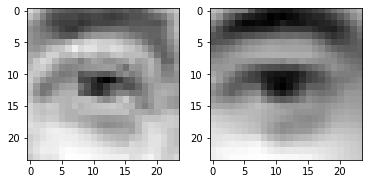

4511 0.0024694011081010103
4512 0.0020741531625390053
4513 0.0023074615746736526
4514 0.002785125281661749
4515 0.001993302721530199
4516 0.00207403558306396
4517 0.002349516609683633
4518 0.0023001946974545717
4519 0.001979456515982747
4520 0.0020577125251293182


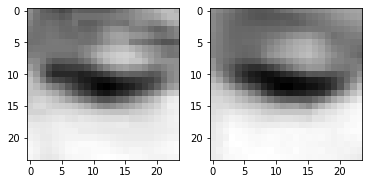

4521 0.0021156456787139177
4522 0.0019408462103456259
4523 0.0020877302158623934
4524 0.0019716762471944094
4525 0.002069184323772788
4526 0.00198306399397552
4527 0.001833670074120164
4528 0.001944248448126018
4529 0.002592275617644191
4530 0.0018318109214305878


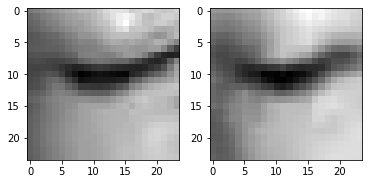

4531 0.0018959840526804328
4532 0.0018390357727184892
4533 0.0019294731318950653
4534 0.0018757416401058435
4535 0.0018560085445642471
4536 0.0017920947866514325
4537 0.0019542844966053963
4538 0.002019606763496995
4539 0.0017058008816093206
4540 0.0019380117300897837


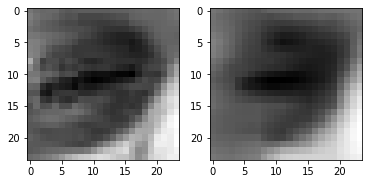

4541 0.0018076689448207617
4542 0.0017032695468515158
4543 0.0018329978920519352
4544 0.0030600533355027437
4545 0.0019296873360872269
4546 0.0019505119416862726
4547 0.00248552649281919
4548 0.0021330721210688353
4549 0.0024219148326665163
4550 0.0018962533213198185


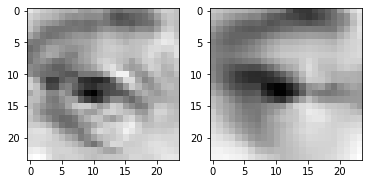

4551 0.0023259357549250126
4552 0.0019822411704808474
4553 0.0022470080293715
4554 0.0017412363085895777
4555 0.0017829237040132284
4556 0.0018639282789081335
4557 0.0019558346830308437
4558 0.0020635370165109634
4559 0.0026887692511081696
4560 0.0017846194095909595


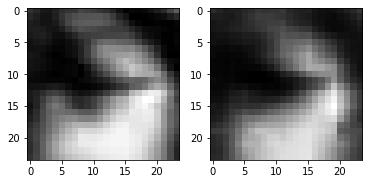

4561 0.0017553152283653617
4562 0.0019170138984918594
4563 0.0017625527689233422
4564 0.0017868282739073038
4565 0.002181922784075141
4566 0.0018462046282365918
4567 0.002067101653665304
4568 0.001842800760641694
4569 0.0018793424824252725
4570 0.0020594948437064886


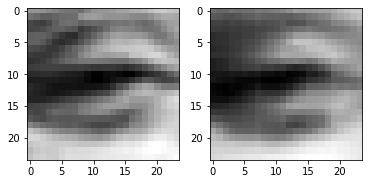

4571 0.001760086859576404
4572 0.001788617460988462
4573 0.0017225566552951932
4574 0.0031041475012898445
4575 0.0021714468020945787
4576 0.0021991245448589325
4577 0.0020749270915985107
4578 0.0018170212861150503
4579 0.00181071856059134
4580 0.001873393659479916


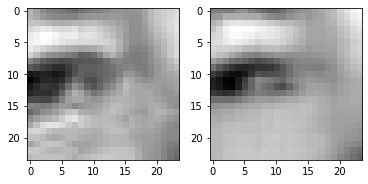

4581 0.0018432800425216556
4582 0.0018506768392398953
4583 0.0019166589481756091
4584 0.0020344725344330072
4585 0.0016839919844642282
4586 0.0016794338589534163
4587 0.0016300646821036935
4588 0.00175196782220155
4589 0.003948206547647715
4590 0.0019308807095512748


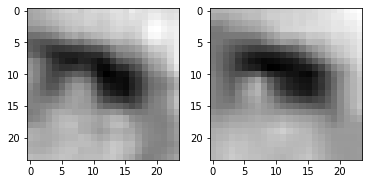

4591 0.003162905341014266
4592 0.002227639313787222
4593 0.0021221546921879053
4594 0.0021373543422669172
4595 0.0021205239463597536
4596 0.0021656479220837355
4597 0.002243484603241086
4598 0.0023117742966860533
4599 0.0019978368654847145
4600 0.002171407686546445


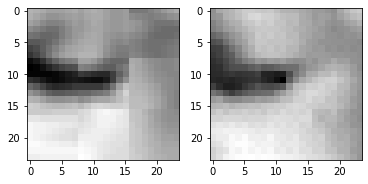

4601 0.0020155629608780146
4602 0.0018135468708351254
4603 0.001994573511183262
4604 0.004220842849463224
4605 0.0023314724676311016
4606 0.0030071090441197157
4607 0.002672094851732254
4608 0.0022704685106873512
4609 0.0022625450510531664
4610 0.0020117703825235367


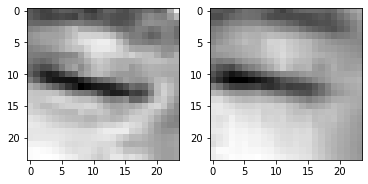

4611 0.0024842768907546997
4612 0.00292031466960907
4613 0.002260577864944935
4614 0.0019863853231072426
4615 0.001997582148760557
4616 0.00227752304635942
4617 0.0023219301365315914
4618 0.001925419783219695
4619 0.0026298591401427984
4620 0.0019481182098388672


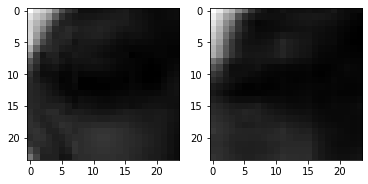

4621 0.002002299763262272
4622 0.0022908952087163925
4623 0.001979219727218151
4624 0.002282873960211873
4625 0.0019417291041463614
4626 0.002774284454062581
4627 0.0019856079015880823
4628 0.0018471420044079423
4629 0.001707495772279799
4630 0.0018304348923265934


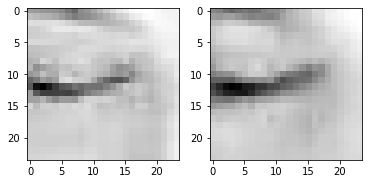

4631 0.0019503483781591058
4632 0.0018762685358524323
4633 0.0019332555821165442
4634 0.003769769798964262
4635 0.002614156808704138
4636 0.0021158307790756226
4637 0.0022760939318686724
4638 0.002192556392401457
4639 0.001835809787735343
4640 0.0018368740566074848


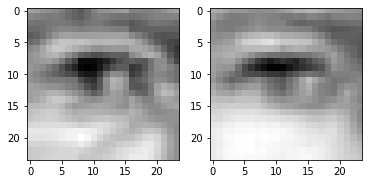

4641 0.0019874083809554577
4642 0.0019735945388674736
4643 0.0018779250094667077
4644 0.0018869239138439298
4645 0.0022318954579532146
4646 0.00188573042396456
4647 0.002068870235234499
4648 0.002031756332144141
4649 0.005267692264169455
4650 0.002551877172663808


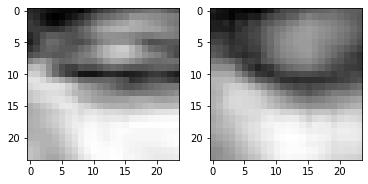

4651 0.004807417746633291
4652 0.00311488751322031
4653 0.0021189742255955935
4654 0.0022819165606051683
4655 0.002521836431697011
4656 0.002885219408199191
4657 0.0021121774334460497
4658 0.002258890075609088
4659 0.0021244920790195465
4660 0.00202520121820271


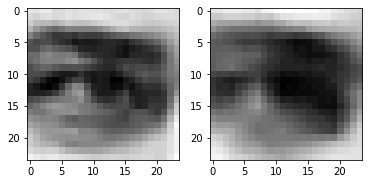

4661 0.002113464754074812
4662 0.002679716795682907
4663 0.0019704513251781464
4664 0.005959374830126762
4665 0.0033869054168462753
4666 0.003978467080742121
4667 0.0037261538673192263
4668 0.0023315604776144028
4669 0.0027710036374628544
4670 0.0025321203283965588


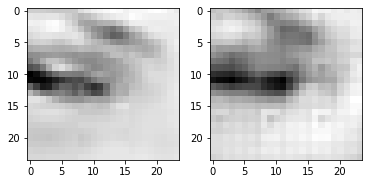

4671 0.0035047014243900776
4672 0.003132024547085166
4673 0.002641225466504693
4674 0.002735622925683856
4675 0.002553485566750169
4676 0.004047659691423178
4677 0.002833789912983775
4678 0.0020579404663294554
4679 0.003102786373347044
4680 0.002268032869324088


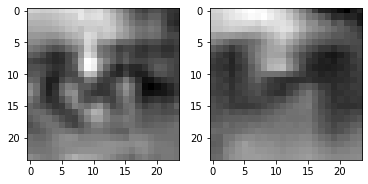

4681 0.00308611080981791
4682 0.0024003973230719566
4683 0.00215743575245142
4684 0.0023741053882986307
4685 0.0023933667689561844
4686 0.002437821589410305
4687 0.0018982049077749252
4688 0.002177542308345437
4689 0.002282288856804371
4690 0.0020872594323009253


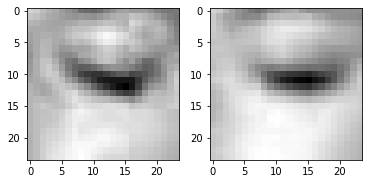

4691 0.002334335120394826
4692 0.002074503106996417
4693 0.0019807920325547457
4694 0.004999838303774595
4695 0.002145536243915558
4696 0.002453523688018322
4697 0.00273201079107821
4698 0.002134960610419512
4699 0.002328196307644248
4700 0.002177212154492736


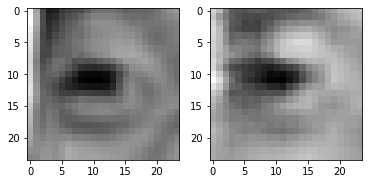

4701 0.0026493407785892487
4702 0.0021143369376659393
4703 0.0020547995809465647
4704 0.002645168686285615
4705 0.002115301787853241
4706 0.00209659431129694
4707 0.0021607126109302044
4708 0.00211726943962276
4709 0.004892886616289616
4710 0.002487713238224387


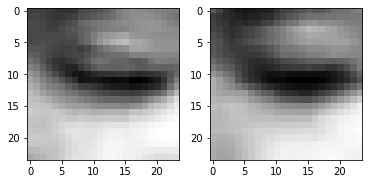

4711 0.002734691370278597
4712 0.003644592361524701
4713 0.0028458423912525177
4714 0.0021082230377942324
4715 0.0019645001739263535
4716 0.0021737029310315847
4717 0.002104091225191951
4718 0.002394423820078373
4719 0.0019845934584736824
4720 0.002957601100206375


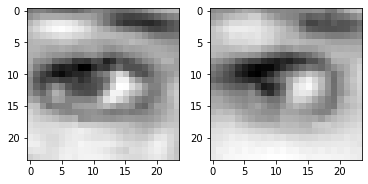

4721 0.0020927281584590673
4722 0.0020678089931607246
4723 0.0022875682916492224
4724 0.003157214494422078
4725 0.0021485951729118824
4726 0.0020598131231963634
4727 0.0021104435436427593
4728 0.002106785774230957
4729 0.0018865203019231558
4730 0.001940169488079846


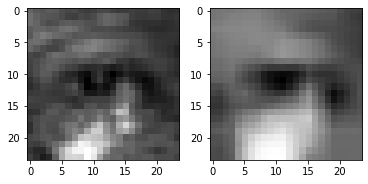

4731 0.0019231763435527682
4732 0.0020243232138454914
4733 0.002109452383592725
4734 0.0021266296971589327
4735 0.0021968309301882982
4736 0.0017297398298978806
4737 0.0018586189253255725
4738 0.002120373072102666
4739 0.0042449235916137695
4740 0.0021816531661897898


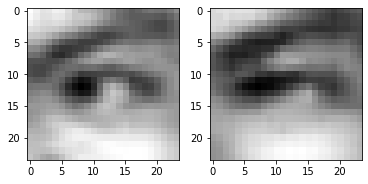

4741 0.0020505180582404137
4742 0.0022152916062623262
4743 0.0019136166665703058
4744 0.0020987559109926224
4745 0.002310182899236679
4746 0.0018758031073957682
4747 0.001901494339108467
4748 0.002029833849519491
4749 0.0022157093044370413
4750 0.0019941660575568676


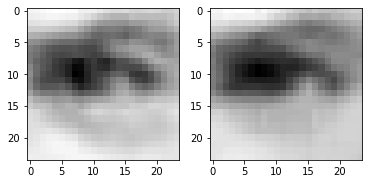

4751 0.0017074390780180693
4752 0.002321728738024831
4753 0.0023212251253426075
4754 0.002790817292407155
4755 0.001980697503313422
4756 0.002162839286029339
4757 0.0019350229995325208
4758 0.002059098333120346
4759 0.001783299958333373
4760 0.0018141820328310132


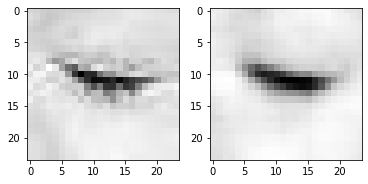

4761 0.0027370734605938196
4762 0.002118587726727128
4763 0.0018571872496977448
4764 0.001972818048670888
4765 0.002745048375800252
4766 0.0018885262543335557
4767 0.0021595351863652468
4768 0.0018024506280198693
4769 0.0045172106474637985
4770 0.0019122223602607846


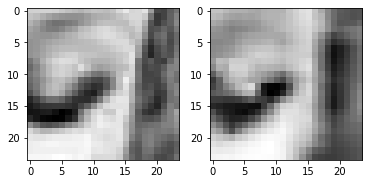

4771 0.001942578935995698
4772 0.001948401564732194
4773 0.002093070652335882
4774 0.001954220235347748
4775 0.0020464903209358454
4776 0.001734935212880373
4777 0.0022736061364412308
4778 0.0023122807033360004
4779 0.0019652992486953735
4780 0.0017222077585756779


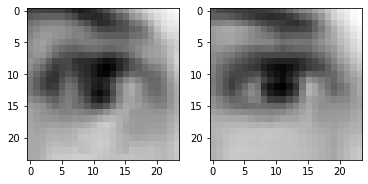

4781 0.001803656225092709
4782 0.0020529860630631447
4783 0.002158287214115262
4784 0.003111794590950012
4785 0.0019219961250200868
4786 0.002403880702331662
4787 0.002181357704102993
4788 0.0020274894777685404
4789 0.001800738275051117
4790 0.0017802895745262504


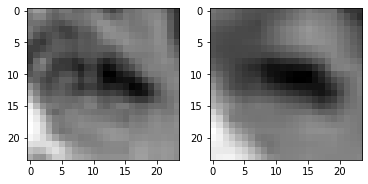

4791 0.0018202867358922958
4792 0.0020739631727337837
4793 0.0019431532127782702
4794 0.001788523280993104
4795 0.0018136125290766358
4796 0.0018519171280786395
4797 0.0018517776625230908
4798 0.0029020982328802347
4799 0.0064627486281096935
4800 0.0022632055915892124


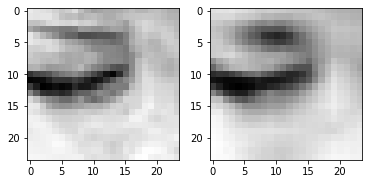

4801 0.0037548483815044165
4802 0.003141197143122554
4803 0.004001054912805557
4804 0.002201809547841549
4805 0.00274926470592618
4806 0.002699995646253228
4807 0.0030139656737446785
4808 0.0026580120902508497
4809 0.0019880037289112806
4810 0.002086077583953738


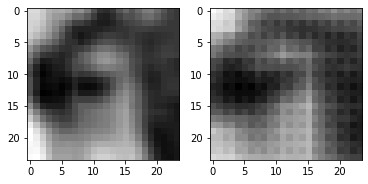

4811 0.0025665920693427324
4812 0.0023413742892444134
4813 0.0020589118357747793
4814 0.005397034343332052
4815 0.0019495399901643395
4816 0.0022868153173476458
4817 0.0030462678987532854
4818 0.0020939712412655354
4819 0.00202370947226882
4820 0.0021108428481966257


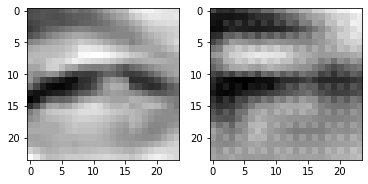

4821 0.0019477496389299631
4822 0.0020624957978725433
4823 0.002133400412276387
4824 0.002104709856212139
4825 0.0018621792551130056
4826 0.001965424744412303
4827 0.0017406042898073792
4828 0.0017758806934580207
4829 0.0030514479149132967
4830 0.0020635505206882954


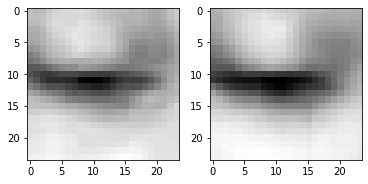

4831 0.002216372173279524
4832 0.002164911711588502
4833 0.0020782083738595247
4834 0.001890733023174107
4835 0.0025041932240128517
4836 0.001780412276275456
4837 0.0018816654337570071
4838 0.001674798782914877
4839 0.0019419501768425107
4840 0.0019346361514180899


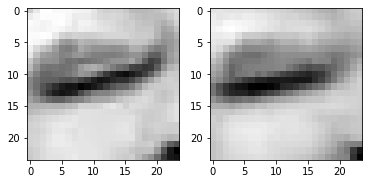

4841 0.00199444149620831
4842 0.0024310764856636524
4843 0.0017340644262731075
4844 0.0024319984950125217
4845 0.0017748568207025528
4846 0.0019557876512408257
4847 0.0024214244913309813
4848 0.0019956491887569427
4849 0.0018173155840486288
4850 0.002521676244214177


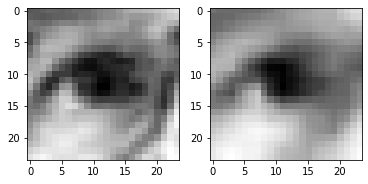

4851 0.001909559010528028
4852 0.0018748451257124543
4853 0.0015656157629564404
4854 0.0018512372625991702
4855 0.0022436990402638912
4856 0.0017156207468360662
4857 0.0018680901266634464
4858 0.001797171775251627
4859 0.01459635142236948
4860 0.0020677209831774235


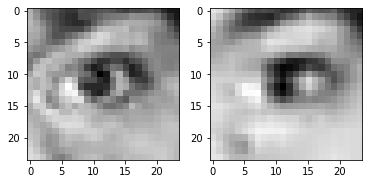

4861 0.004496695473790169
4862 0.004688973072916269
4863 0.0030616982840001583
4864 0.0028041282203048468
4865 0.003022513585165143
4866 0.0026810478884726763
4867 0.00285345152951777
4868 0.002480370458215475
4869 0.0026855464093387127
4870 0.002344988053664565


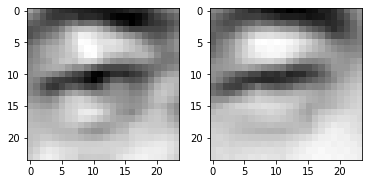

4871 0.002876250073313713
4872 0.002350102411583066
4873 0.0022211617324501276
4874 0.00293613295070827
4875 0.002318763406947255
4876 0.0022564649116247892
4877 0.0024793578777462244
4878 0.002809893572703004
4879 0.00221362360753119
4880 0.0023476947098970413


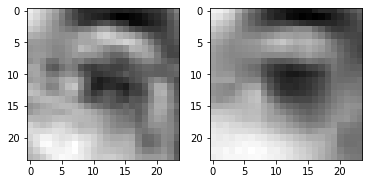

4881 0.0020597511902451515
4882 0.0022335180547088385
4883 0.0021851796191185713
4884 0.0022773966193199158
4885 0.002086264081299305
4886 0.0021727015264332294
4887 0.001978452317416668
4888 0.0017744412180036306
4889 0.003108361968770623
4890 0.002196851186454296


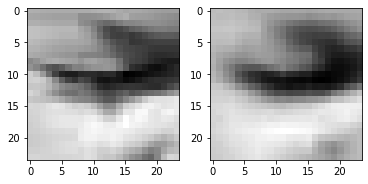

4891 0.00232718582265079
4892 0.002244468778371811
4893 0.0019700590055435896
4894 0.002270672470331192
4895 0.0026758781168609858
4896 0.0021103208418935537
4897 0.002069519367069006
4898 0.0019813005346804857
4899 0.0024048255290836096
4900 0.0018007151084020734


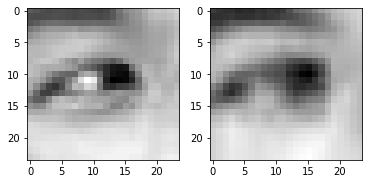

4901 0.00203189835883677
4902 0.001998684834688902
4903 0.0017410196596756577
4904 0.002636834979057312
4905 0.0019139581127092242
4906 0.001824276288971305
4907 0.0019755251705646515
4908 0.0017956375377252698
4909 0.0017346442909911275
4910 0.0018507064087316394


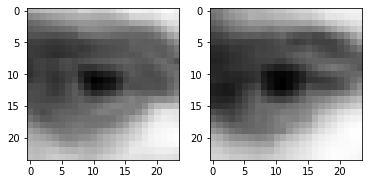

4911 0.0020311721600592136
4912 0.0025042362976819277
4913 0.0017019077204167843
4914 0.0021938232239335775
4915 0.0017698005540296435
4916 0.00180906115565449
4917 0.0017246193019673228
4918 0.0016862652264535427
4919 0.005446061957627535
4920 0.0030331574380397797


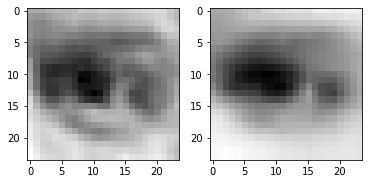

4921 0.0031020930036902428
4922 0.001923769130371511
4923 0.0018247661646455526
4924 0.0019442474003881216
4925 0.001929208287037909
4926 0.0018328463193029165
4927 0.001956398133188486
4928 0.0023747398518025875
4929 0.0019123227102681994
4930 0.001970253884792328


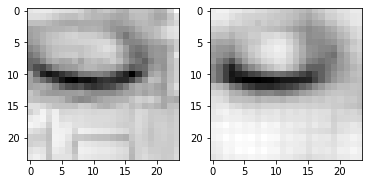

4931 0.0019407945219427347
4932 0.00190997333265841
4933 0.002027275739237666
4934 0.005750993266701698
4935 0.0019027901580557227
4936 0.0018472102237865329
4937 0.002465632976964116
4938 0.0023376476019620895
4939 0.0020048024598509073
4940 0.0019377809949219227


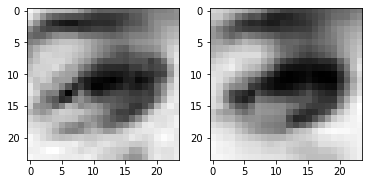

4941 0.0018403875874355435
4942 0.0027227886021137238
4943 0.002918240614235401
4944 0.002434907713904977
4945 0.001992663135752082
4946 0.002218007342889905
4947 0.0024261733051389456
4948 0.002070013899356127
4949 0.00364849716424942
4950 0.0023767512757331133


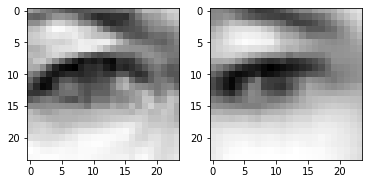

4951 0.002762099029496312
4952 0.002682363847270608
4953 0.0022306572645902634
4954 0.001802670070901513
4955 0.0019308680202811956
4956 0.0020955298095941544
4957 0.002367157954722643
4958 0.002085520885884762
4959 0.0020054313354194164
4960 0.0022617417853325605


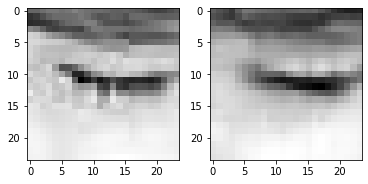

4961 0.0018515645060688257
4962 0.0017270551761612296
4963 0.0019373620161786675
4964 0.005326842423528433
4965 0.0030186264775693417
4966 0.002773889573290944
4967 0.0020525334402918816
4968 0.001906326855532825
4969 0.0019001761684194207
4970 0.001820081495679915


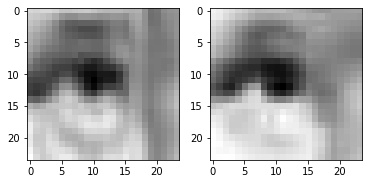

4971 0.0019792583771049976
4972 0.0019249268807470798
4973 0.0017810194985941052
4974 0.0019179917871952057
4975 0.0019222196424379945
4976 0.0017943227430805564
4977 0.001841080724261701
4978 0.0024268566630780697
4979 0.0030310731381177902
4980 0.001727385795675218


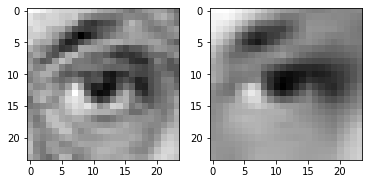

4981 0.001996659906581044
4982 0.0020003467798233032
4983 0.0020776791498064995
4984 0.0019190593156963587
4985 0.0019071222050115466
4986 0.001960381167009473
4987 0.001890684594400227
4988 0.0018610896077007055
4989 0.002108176238834858
4990 0.0018213399453088641


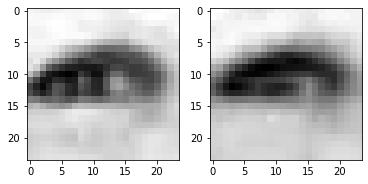

4991 0.0017364887753501534
4992 0.0019218993838876486
4993 0.002028601011261344
4994 0.003811316331848502
4995 0.0019143989775329828
4996 0.002025724621489644
4997 0.0021250746212899685
4998 0.0019237755332142115
4999 0.001948049059137702
5000 0.0018652868457138538


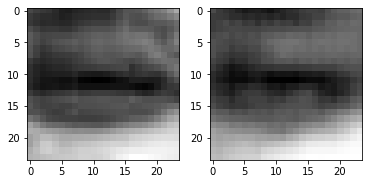

5001 0.002244020812213421
5002 0.002086029155179858
5003 0.0018862036522477865
5004 0.002128161024302244
5005 0.002795041771605611
5006 0.0018900198629125953
5007 0.0018050952348858118
5008 0.002316657919436693
5009 0.0030969837680459023


In [12]:
class VaeTrainer:
    def __init__(self, latent_size):
        self.vae = VAE(latent_size=latent_size)
        self.vae.cuda()
    
    def train(self):
        self.vae.train()
        
        image_list, _ = load_archive()
        
        tensor_data = (1/255*torch.tensor(image_list).float()).unsqueeze(1)

        dataset = torch.utils.data.TensorDataset(tensor_data)
        
        loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)
        
        optimizer = torch.optim.Adam(self.vae.parameters(), lr=1e-2)
        
        num_iters = 5_000
        i_iter = 0
        while i_iter < num_iters:
            for i_batch, (batch,) in enumerate(loader):
                batch = batch.cuda()
                pred_batch = self.vae(batch)
                optimizer.zero_grad()
                loss = F.mse_loss(batch, pred_batch)
                loss.backward()
                print(i_iter, loss.item())
                optimizer.step()
                if i_iter % 10 == 0:
                    fig, axs = plt.subplots(1, 2)
                    axs[0].imshow(batch[0, 0, ...].detach().cpu().numpy(), cmap='gray')
                    axs[1].imshow(pred_batch[0, 0, ...].detach().cpu().numpy(), cmap='gray')
                    plt.show()
                    torch.save(self.vae.state_dict(), "vae.pth")
                i_iter += 1

latent_size = 30
vae_trainer = VaeTrainer(latent_size=latent_size)
vae_trainer.train()

In [13]:
# model.load_state_dict(torch.load(PATH))
# state_dict = torch.load("vae.pth")
# print(state_dict.keys())

class Classifier(nn.Module):
    def __init__(self, latent_size, pretrained_model_path="vae.pth"):
        super().__init__()
        self.encoder = Encoder(latent_size)
        state_dict = torch.load(pretrained_model_path)
        # print(state_dict.keys())
        state_dict = {k[len("encoder."):]: v
                      for k, v in state_dict.items() if "encoder." in k}
        # print(state_dict.keys())
        self.encoder.load_state_dict(state_dict, strict=True)
        self.encoder.eval()
        self.class_fc = nn.Linear(latent_size, 1)
    
    def forward(self, x):
        with torch.no_grad():
            mu, log_var = self.encoder(x)
        logits = self.class_fc(mu)
        print("logits=", logits)
        x = torch.sigmoid(logits)
        x = x.squeeze(-1)
        return x
    
    def train(self, mode):
        self.class_fc.train(mode)

logits= tensor([[-9.1055e+01],
        [-5.2800e+02],
        [-3.8358e+01],
        [-4.9628e+01],
        [-3.1185e+01],
        [ 5.1509e-01],
        [-3.9723e+02],
        [-5.8715e+02],
        [ 9.0134e+02],
        [-4.6349e+02],
        [-2.8202e+02],
        [ 6.0642e+02],
        [-6.2003e+02],
        [-6.1221e+02],
        [ 3.9976e+02],
        [-1.8249e+02]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0.0000e+00, 0.0000e+00, 2.1952e-17, 2.7981e-22, 2.8603e-14, 6.2600e-01,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
       device='cuda:0')
0 57.509647369384766


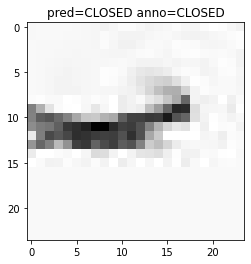

logits= tensor([[ -260.5660],
        [-1275.9318],
        [-1196.2103],
        [ -466.9933]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
1 50.0
logits= tensor([[ -736.5637],
        [ -922.1195],
        [ -492.5377],
        [-1508.1996],
        [-1471.8527],
        [ -463.3241],
        [-1141.8395],
        [ -531.8636],
        [-1273.2621],
        [  -41.6355],
        [ -820.4566],
        [ -684.6281],
        [-1389.5897],
        [ -768.7664],
        [ -956.6877],
        [ -904.2949]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 8.2783e-19, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0.

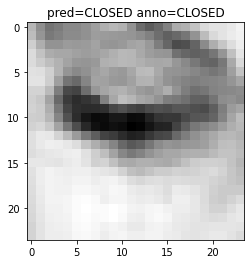

logits= tensor([[-1841.5891],
        [-2577.0010],
        [-2090.1021],
        [-1621.4078]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0.], device='cuda:0')
11 75.0
logits= tensor([[-2010.0189],
        [-3512.4668],
        [-1930.2119],
        [-2272.5122],
        [-1653.4854],
        [-1699.0912],
        [-1904.0737],
        [-3341.3284],
        [-2407.3672],
        [-1606.5455],
        [-2853.9324],
        [-3073.6060],
        [-1475.1875],
        [-2161.8958],
        [-2639.4932],
        [-2010.1632]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.],
       device='cuda:0')
12 62.5
logits= tensor([[-3238.5051],
        [-1721.6329],
        

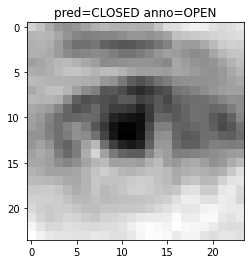

logits= tensor([[-1879.8804],
        [-1772.1309],
        [-2992.3379],
        [-2385.2964]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 1.], device='cuda:0')
21 100.0
logits= tensor([[-2280.4192],
        [-2594.3059],
        [-1791.9432],
        [-1728.3594],
        [-4099.4648],
        [-2403.0610],
        [-1903.7246],
        [-2166.9768],
        [-3930.2170],
        [-2360.7017],
        [-2815.3083],
        [-2410.3254],
        [-1894.9857],
        [-2160.9260],
        [-3325.9612],
        [-3657.3596]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.],
       device='cuda:0')
22 50.0
logits= tensor([[-3037.3157],
        [-3926.7236],
       

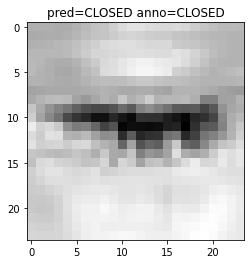

logits= tensor([[-2417.1367],
        [-2963.5046],
        [-2555.6956],
        [-1982.7175]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 1.], device='cuda:0')
31 100.0
logits= tensor([[-2496.7302],
        [-1841.4963],
        [-2361.3201],
        [-2426.4016],
        [-1988.6627],
        [-2586.4771],
        [-2762.0366],
        [-2565.5464],
        [-3848.4312],
        [-3509.0588],
        [-3773.9465],
        [-1914.8112],
        [-3161.8794],
        [-2348.4673],
        [-2973.5471],
        [-2018.9984]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0.],
       device='cuda:0')
32 56.25
logits= tensor([[-4122.4380],
        [-4340.3218],
      

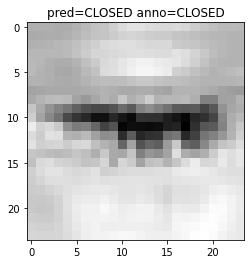

logits= tensor([[-1960.0676],
        [-3215.6555],
        [-1883.1689],
        [-2480.1719]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 1.], device='cuda:0')
41 75.0
logits= tensor([[-2626.5754],
        [-2658.5913],
        [-4194.4863],
        [-2025.4940],
        [-3035.7620],
        [-3850.9045],
        [-2827.9834],
        [-4416.6821],
        [-2483.7976],
        [-3219.2820],
        [-2419.8250],
        [-2550.2124],
        [-3923.5544],
        [-2064.3213],
        [-1885.9794],
        [-2925.8806]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.],
       device='cuda:0')
42 50.0
logits= tensor([[-1965.8962],
        [-3585.1853],
        

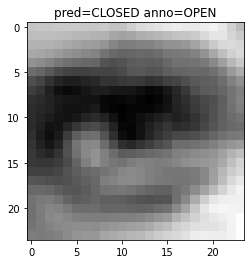

logits= tensor([[-4225.2729],
        [-2684.8752],
        [-1980.7272],
        [-2038.9182]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
51 50.0
logits= tensor([[-2470.7476],
        [-2039.8162],
        [-1981.9049],
        [-1903.2766],
        [-2650.3069],
        [-3059.9553],
        [-4227.3330],
        [-2853.6277],
        [-3952.7673],
        [-3609.0417],
        [-2081.9453],
        [-2506.1172],
        [-3880.8296],
        [-2447.5725],
        [-4451.4937],
        [-2951.0352]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       device='cuda:0')
52 50.0
logits= tensor([[-3242.8755],
        [-4320.8291],
        

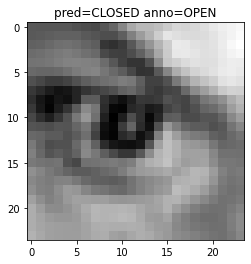

logits= tensor([[-2514.1409],
        [-2658.8379],
        [-2960.0779],
        [-3963.2690]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0.], device='cuda:0')
61 75.0
logits= tensor([[-4239.9248],
        [-2514.6733],
        [-2578.9824],
        [-2697.3838],
        [-2659.4043],
        [-3963.9663],
        [-3250.1606],
        [-1989.1064],
        [-2863.4580],
        [-3069.2295],
        [-3619.7727],
        [-2045.3068],
        [-3892.3020],
        [-4333.3657],
        [-2088.7017],
        [-2458.2102]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')
62 56.25
logits= tensor([[-1910.2825],
        [-2483.1562],
       

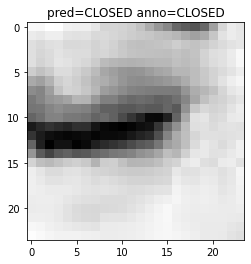

logits= tensor([[-4338.5947],
        [-3967.9436],
        [-2461.9878],
        [-2662.6353]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1.], device='cuda:0')
71 25.0
logits= tensor([[-2867.1802],
        [-3896.6448],
        [-2091.2590],
        [-2486.9392],
        [-1912.4180],
        [-2582.0007],
        [-2964.3286],
        [-2462.2368],
        [-3253.3999],
        [-2047.3850],
        [-3072.7410],
        [-2701.4531],
        [-3623.8354],
        [-4338.9395],
        [-4244.6909],
        [-1991.8322]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1.],
       device='cuda:0')
72 50.0
logits= tensor([[-2518.0940],
        [-2663.0417],
        

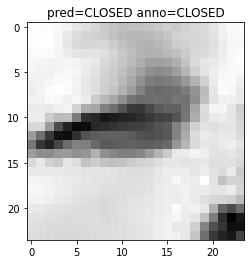

logits= tensor([[-3625.2639],
        [-1913.3007],
        [-2965.6123],
        [-3969.6963]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
81 50.0
logits= tensor([[-3254.6140],
        [-4246.4775],
        [-2092.2175],
        [-4471.7842],
        [-2868.5745],
        [-2664.1394],
        [-2702.9783],
        [-2048.1638],
        [-3969.7939],
        [-2488.6050],
        [-1913.3584],
        [-2583.1316],
        [-4341.0283],
        [-1992.8539],
        [-3074.0559],
        [-2965.6963]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
82 50.0
logits= tensor([[-2463.8296],
        [-3625.4421],
        

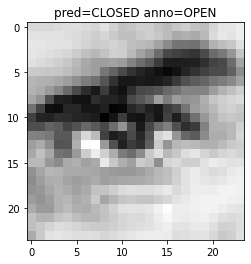

logits= tensor([[-2464.2717],
        [-1913.6864],
        [-3074.5149],
        [-1993.2100]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
91 50.0
logits= tensor([[-4472.4858],
        [-2869.0920],
        [-2519.5762],
        [-4247.1401],
        [-1993.2333],
        [-2092.5735],
        [-4341.8037],
        [-2489.2241],
        [-1913.7079],
        [-3074.5442],
        [-2966.2048],
        [-2048.4534],
        [-2583.5518],
        [-3898.8767],
        [-2703.5447],
        [-2464.3066]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
       device='cuda:0')
92 43.75
logits= tensor([[-3625.9546],
        [-3970.4170],
       

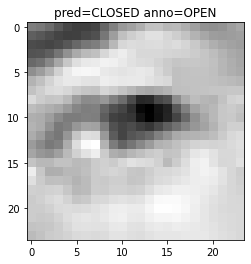

logits= tensor([[-3255.2207],
        [-3074.7141],
        [-1993.3647],
        [-3626.1194]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 1.], device='cuda:0')
101 100.0
logits= tensor([[-2966.3918],
        [-2489.4524],
        [-2664.7952],
        [-4472.7461],
        [-2048.5598],
        [-2583.7068],
        [-2092.7051],
        [-3255.2310],
        [-4342.0903],
        [-2464.5129],
        [-4247.3857],
        [-2519.7429],
        [-3970.6021],
        [-2703.7537],
        [-3626.1321],
        [-1913.8367]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0')
102 43.75
logits= tensor([[-3074.7351],
        [-2869.2942],
    

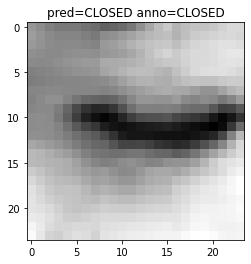

logits= tensor([[-2703.8252],
        [-2464.5837],
        [-2664.8557],
        [-3074.7871]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
111 50.0
logits= tensor([[-3074.7913],
        [-3899.1809],
        [-2464.5886],
        [-2583.7634],
        [-2703.8298],
        [-2048.5991],
        [-2519.8040],
        [-3970.6819],
        [-4247.4751],
        [-2966.4609],
        [-1993.4246],
        [-2869.3533],
        [-2489.5359],
        [-3626.2080],
        [-1913.8838],
        [-2664.8601]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1.],
       device='cuda:0')
112 56.25
logits= tensor([[-3255.2957],
        [-4342.2012],
     

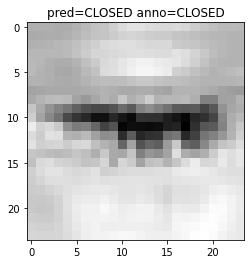

logits= tensor([[-1913.9001],
        [-2869.3777],
        [-4247.5054],
        [-3255.3132]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 1.], device='cuda:0')
121 50.0
logits= tensor([[-4247.5078],
        [-2869.3794],
        [-3074.8157],
        [-2092.7708],
        [-2703.8579],
        [-4342.2339],
        [-1913.9012],
        [-2048.6133],
        [-3899.2109],
        [-2464.6167],
        [-2519.8262],
        [-3970.7112],
        [-3626.2366],
        [-2664.8838],
        [-3255.3145],
        [-2489.5667]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       device='cuda:0')
122 43.75
logits= tensor([[-1993.4443],
        [-4472.8774],
     

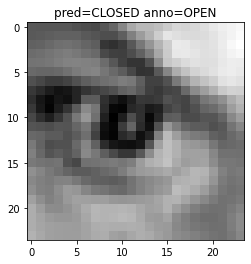

logits= tensor([[-2092.7771],
        [-2583.7913],
        [-4342.2471],
        [-2703.8677]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 0.], device='cuda:0')
131 25.0
logits= tensor([[-2092.7776],
        [-2703.8684],
        [-4472.8887],
        [-1993.4501],
        [-2869.3884],
        [-3970.7217],
        [-2664.8923],
        [-2519.8345],
        [-1913.9073],
        [-2966.4954],
        [-3899.2222],
        [-4247.5195],
        [-3626.2463],
        [-4342.2480],
        [-3074.8240],
        [-2583.7917]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
       device='cuda:0')
132 50.0
logits= tensor([[-2464.6272],
        [-2048.6187],
      

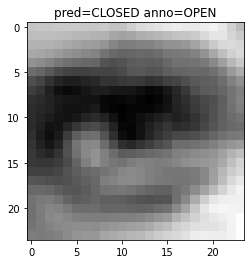

logits= tensor([[-1913.9095],
        [-4247.5239],
        [-2869.3916],
        [-3970.7246]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 0.], device='cuda:0')
141 25.0
logits= tensor([[-3899.2256],
        [-3074.8269],
        [-2464.6306],
        [-4342.2529],
        [-1913.9097],
        [-2869.3916],
        [-2664.8955],
        [-2583.7944],
        [-2092.7798],
        [-2048.6204],
        [-2703.8721],
        [-2966.4983],
        [-4472.8931],
        [-3970.7251],
        [-1993.4525],
        [-2519.8379]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.],
       device='cuda:0')
142 50.0
logits= tensor([[-4247.5239],
        [-3626.2500],
      

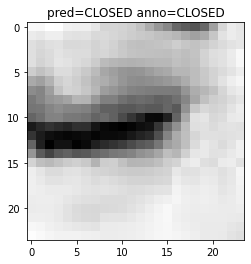

logits= tensor([[-2489.5830],
        [-2664.8962],
        [-2519.8384],
        [-2583.7954]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1.], device='cuda:0')
151 75.0
logits= tensor([[-4247.5249],
        [-1913.9102],
        [-1993.4532],
        [-3970.7261],
        [-2489.5830],
        [-3255.3259],
        [-2583.7954],
        [-2092.7805],
        [-2664.8962],
        [-2464.6313],
        [-2519.8384],
        [-4342.2534],
        [-3899.2271],
        [-2966.4993],
        [-2703.8730],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
       device='cuda:0')
152 37.5
logits= tensor([[-2048.6208],
        [-3626.2510],
      

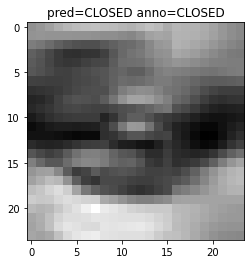

logits= tensor([[-3626.2512],
        [-2489.5833],
        [-2966.4993],
        [-2092.7803]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
161 50.0
logits= tensor([[-4247.5254],
        [-2703.8730],
        [-3074.8279],
        [-3255.3259],
        [-2869.3928],
        [-2489.5833],
        [-2464.6316],
        [-2092.7803],
        [-2583.7954],
        [-3970.7263],
        [-4342.2539],
        [-1993.4535],
        [-2664.8965],
        [-3899.2271],
        [-4472.8940],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
       device='cuda:0')
162 37.5
logits= tensor([[-3626.2512],
        [-2519.8386],
      

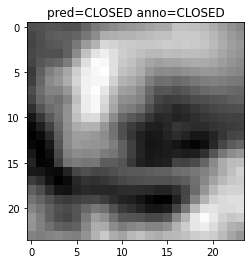

logits= tensor([[-2464.6316],
        [-2869.3928],
        [-2583.7954],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0.], device='cuda:0')
171 50.0
logits= tensor([[-4342.2539],
        [-1913.9104],
        [-2048.6211],
        [-2092.7803],
        [-2966.4993],
        [-2664.8965],
        [-3899.2271],
        [-2583.7954],
        [-4247.5254],
        [-2869.3928],
        [-1993.4535],
        [-2703.8730],
        [-3255.3259],
        [-3970.7263],
        [-2489.5833],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.],
       device='cuda:0')
172 50.0
logits= tensor([[-3074.8279],
        [-3626.2512],
      

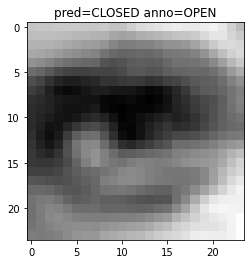

logits= tensor([[-2489.5833],
        [-4342.2539],
        [-3074.8279],
        [-1993.4535]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
181 50.0
logits= tensor([[-3899.2271],
        [-4247.5254],
        [-4472.8940],
        [-2664.8965],
        [-4342.2539],
        [-2583.7954],
        [-2966.4993],
        [-3074.8279],
        [-2489.5833],
        [-2464.6316],
        [-1993.4535],
        [-1913.9104],
        [-3255.3259],
        [-3970.7266],
        [-2869.3928],
        [-2092.7803]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       device='cuda:0')
182 43.75
logits= tensor([[-2703.8730],
        [-2519.8386],
     

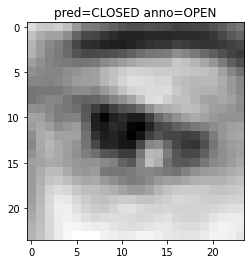

logits= tensor([[-3074.8279],
        [-4342.2539],
        [-3255.3259],
        [-4247.5254]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
191 50.0
logits= tensor([[-2664.8965],
        [-3626.2512],
        [-2489.5833],
        [-3255.3259],
        [-2519.8386],
        [-3074.8279],
        [-2092.7803],
        [-4247.5254],
        [-2464.6316],
        [-4472.8940],
        [-2583.7954],
        [-1913.9104],
        [-4342.2539],
        [-2048.6211],
        [-1993.4535],
        [-3970.7266]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.],
       device='cuda:0')
192 50.0
logits= tensor([[-3899.2271],
        [-2869.3928],
      

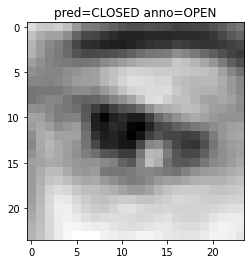

logits= tensor([[-3255.3259],
        [-1913.9104],
        [-1993.4535],
        [-3899.2271]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
201 50.0
logits= tensor([[-4342.2539],
        [-3074.8279],
        [-1993.4535],
        [-3255.3259],
        [-2966.4993],
        [-3626.2512],
        [-2703.8730],
        [-3899.2271],
        [-2869.3928],
        [-2583.7954],
        [-2048.6211],
        [-2664.8965],
        [-1913.9104],
        [-2519.8386],
        [-4247.5254],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.],
       device='cuda:0')
202 62.5
logits= tensor([[-2489.5833],
        [-2092.7803],
      

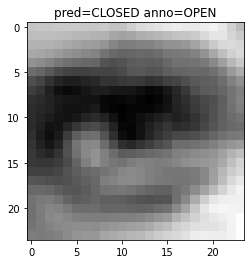

logits= tensor([[-2048.6211],
        [-4247.5254],
        [-2664.8965],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
211 50.0
logits= tensor([[-2966.4993],
        [-4247.5254],
        [-2048.6211],
        [-2489.5833],
        [-1913.9104],
        [-4472.8940],
        [-2092.7803],
        [-2464.6316],
        [-3626.2512],
        [-2869.3928],
        [-3255.3259],
        [-3970.7266],
        [-2703.8730],
        [-3899.2271],
        [-2519.8386],
        [-2664.8965]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1.],
       device='cuda:0')
212 43.75
logits= tensor([[-2583.7954],
        [-3074.8279],
     

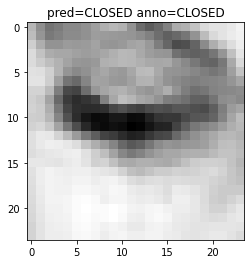

logits= tensor([[-3074.8279],
        [-2464.6316],
        [-2048.6211],
        [-3626.2512]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1.], device='cuda:0')
221 75.0
logits= tensor([[-3626.2512],
        [-4247.5254],
        [-2519.8386],
        [-2966.4993],
        [-3899.2271],
        [-3255.3259],
        [-4342.2539],
        [-2583.7954],
        [-2869.3928],
        [-2048.6211],
        [-2703.8730],
        [-4472.8940],
        [-2664.8965],
        [-2489.5833],
        [-1993.4535],
        [-3074.8279]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.],
       device='cuda:0')
222 62.5
logits= tensor([[-2092.7803],
        [-2464.6316],
      

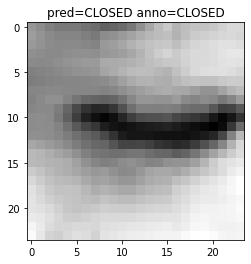

logits= tensor([[-2048.6211],
        [-3626.2512],
        [-2869.3928],
        [-2966.4993]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 1.], device='cuda:0')
231 100.0
logits= tensor([[-2048.6211],
        [-3970.7266],
        [-1993.4535],
        [-3626.2512],
        [-2966.4993],
        [-4247.5254],
        [-2583.7954],
        [-4342.2539],
        [-2489.5833],
        [-3074.8279],
        [-3255.3259],
        [-2703.8730],
        [-2869.3928],
        [-3899.2271],
        [-2664.8965],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.],
       device='cuda:0')
232 56.25
logits= tensor([[-2092.7803],
        [-1913.9104],
    

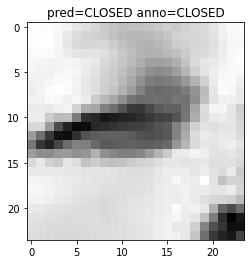

logits= tensor([[-2583.7954],
        [-2464.6316],
        [-2966.4993],
        [-2869.3928]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1.], device='cuda:0')
241 75.0
logits= tensor([[-2048.6211],
        [-2966.4993],
        [-4247.5254],
        [-3899.2271],
        [-2464.6316],
        [-2092.7803],
        [-2583.7954],
        [-3074.8279],
        [-2703.8730],
        [-3255.3259],
        [-2489.5833],
        [-4472.8940],
        [-2664.8965],
        [-3626.2512],
        [-1993.4535],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.],
       device='cuda:0')
242 50.0
logits= tensor([[-2869.3928],
        [-3970.7266],
      

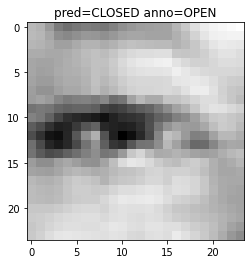

logits= tensor([[-2092.7803],
        [-1913.9104],
        [-4342.2539],
        [-3074.8279]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1.], device='cuda:0')
251 25.0
logits= tensor([[-2966.4993],
        [-2048.6211],
        [-2092.7803],
        [-2464.6316],
        [-1913.9104],
        [-2519.8386],
        [-3626.2512],
        [-2583.7954],
        [-3255.3259],
        [-3899.2271],
        [-2869.3928],
        [-1993.4535],
        [-3970.7266],
        [-2703.8730],
        [-4342.2539],
        [-2664.8965]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1.],
       device='cuda:0')
252 56.25
logits= tensor([[-3074.8279],
        [-2489.5833],
     

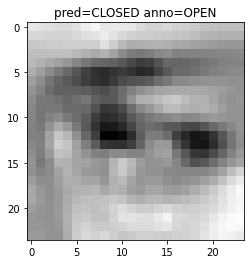

logits= tensor([[-2869.3928],
        [-2703.8730],
        [-2489.5833],
        [-3899.2271]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 0.], device='cuda:0')
261 25.0
logits= tensor([[-2583.7954],
        [-4472.8940],
        [-1993.4535],
        [-2664.8965],
        [-2703.8730],
        [-2464.6316],
        [-2519.8386],
        [-3255.3259],
        [-4247.5254],
        [-1913.9104],
        [-2048.6211],
        [-3970.7266],
        [-2869.3928],
        [-4342.2539],
        [-2489.5833],
        [-3899.2271]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
       device='cuda:0')
262 43.75
logits= tensor([[-3626.2512],
        [-2092.7803],
     

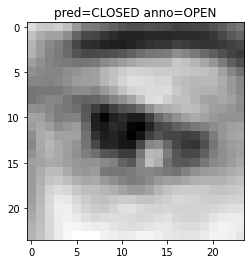

logits= tensor([[-4342.2539],
        [-2583.7954],
        [-2092.7803],
        [-3970.7266]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 0.], device='cuda:0')
271 25.0
logits= tensor([[-2092.7803],
        [-1913.9104],
        [-2519.8386],
        [-3970.7266],
        [-2464.6316],
        [-3626.2512],
        [-3899.2271],
        [-1993.4535],
        [-3074.8279],
        [-2664.8965],
        [-2869.3928],
        [-4247.5254],
        [-2048.6211],
        [-2703.8730],
        [-2489.5833],
        [-2583.7954]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
       device='cuda:0')
272 50.0
logits= tensor([[-4342.2539],
        [-4472.8940],
      

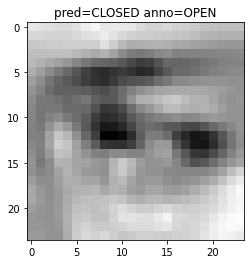

logits= tensor([[-2092.7803],
        [-4342.2539],
        [-1913.9104],
        [-2048.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1.], device='cuda:0')
281 25.0
logits= tensor([[-4342.2539],
        [-2966.4993],
        [-1993.4535],
        [-3899.2271],
        [-3255.3259],
        [-2048.6211],
        [-1913.9104],
        [-4472.8940],
        [-2489.5833],
        [-2464.6316],
        [-2703.8730],
        [-2664.8965],
        [-2092.7803],
        [-2583.7954],
        [-3074.8279],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
282 50.0
logits= tensor([[-3626.2512],
        [-4247.5254],
      

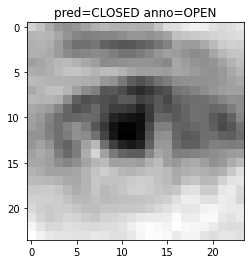

logits= tensor([[-4247.5254],
        [-2966.4993],
        [-2664.8965],
        [-2048.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1.], device='cuda:0')
291 75.0
logits= tensor([[-2703.8730],
        [-3074.8279],
        [-2664.8965],
        [-3899.2271],
        [-1913.9104],
        [-2583.7954],
        [-2464.6316],
        [-2869.3928],
        [-4342.2539],
        [-2048.6211],
        [-3970.7266],
        [-3255.3259],
        [-1993.4535],
        [-2966.4993],
        [-2092.7803],
        [-4247.5254]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
       device='cuda:0')
292 50.0
logits= tensor([[-2519.8386],
        [-3626.2512],
      

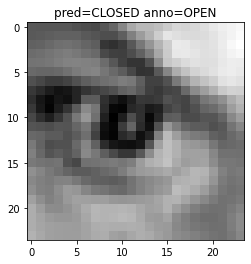

logits= tensor([[-2489.5833],
        [-3970.7266],
        [-2464.6316],
        [-2703.8730]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 0.], device='cuda:0')
301 0.0
logits= tensor([[-1993.4535],
        [-3255.3259],
        [-4247.5254],
        [-3074.8279],
        [-2583.7954],
        [-2966.4993],
        [-2464.6316],
        [-3970.7266],
        [-3899.2271],
        [-2048.6211],
        [-2489.5833],
        [-4342.2539],
        [-2519.8386],
        [-1913.9104],
        [-2703.8730],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')
302 43.75
logits= tensor([[-2869.3928],
        [-2092.7803],
      

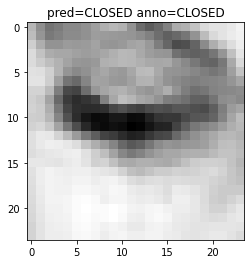

logits= tensor([[-2464.6316],
        [-3626.2512],
        [-3970.7266],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 1.], device='cuda:0')
311 50.0
logits= tensor([[-1993.4535],
        [-2519.8386],
        [-2048.6211],
        [-2703.8730],
        [-3626.2512],
        [-3899.2271],
        [-2966.4993],
        [-4247.5254],
        [-2464.6316],
        [-1913.9104],
        [-3255.3259],
        [-4472.8940],
        [-2092.7803],
        [-2489.5833],
        [-3970.7266],
        [-2583.7954]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       device='cuda:0')
312 43.75
logits= tensor([[-3074.8279],
        [-4342.2539],
     

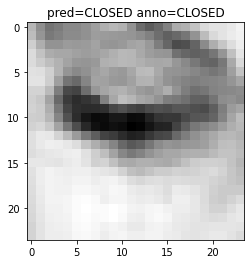

logits= tensor([[-2464.6316],
        [-3255.3259],
        [-2583.7954],
        [-2489.5833]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0.], device='cuda:0')
321 50.0
logits= tensor([[-3970.7266],
        [-4472.8940],
        [-2092.7803],
        [-2966.4993],
        [-3899.2271],
        [-1913.9104],
        [-2489.5833],
        [-3626.2512],
        [-1993.4535],
        [-3255.3259],
        [-2048.6211],
        [-3074.8279],
        [-2703.8730],
        [-2519.8386],
        [-2464.6316],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.],
       device='cuda:0')
322 43.75
logits= tensor([[-2583.7954],
        [-2664.8965],
     

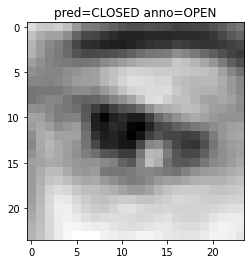

logits= tensor([[-1993.4535],
        [-3626.2512],
        [-3074.8279],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 1.], device='cuda:0')
331 100.0
logits= tensor([[-2703.8730],
        [-4342.2539],
        [-3255.3259],
        [-2664.8965],
        [-2048.6211],
        [-3626.2512],
        [-1993.4535],
        [-2464.6316],
        [-3074.8279],
        [-3970.7266],
        [-2519.8386],
        [-2869.3928],
        [-2092.7803],
        [-2966.4993],
        [-2583.7954],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.],
       device='cuda:0')
332 62.5
logits= tensor([[-2489.5833],
        [-1913.9104],
     

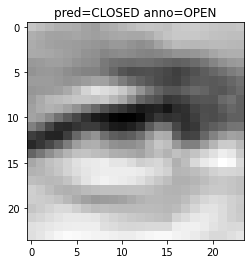

logits= tensor([[-3899.2271],
        [-3626.2512],
        [-1913.9104],
        [-2966.4993]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 1.], device='cuda:0')
341 50.0
logits= tensor([[-4247.5254],
        [-2092.7803],
        [-2703.8730],
        [-2664.8965],
        [-2519.8386],
        [-2048.6211],
        [-1913.9104],
        [-2869.3928],
        [-3899.2271],
        [-3255.3259],
        [-3074.8279],
        [-3970.7266],
        [-4342.2539],
        [-2966.4993],
        [-4472.8940],
        [-1993.4535]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.],
       device='cuda:0')
342 50.0
logits= tensor([[-2489.5833],
        [-3626.2512],
      

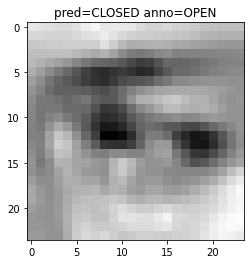

logits= tensor([[-2664.8965],
        [-3899.2271],
        [-3626.2512],
        [-3970.7266]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
351 50.0
logits= tensor([[-2966.4993],
        [-3074.8279],
        [-1913.9104],
        [-4472.8940],
        [-2092.7803],
        [-2583.7954],
        [-2048.6211],
        [-2489.5833],
        [-3899.2271],
        [-2464.6316],
        [-2664.8965],
        [-4247.5254],
        [-2869.3928],
        [-3255.3259],
        [-1993.4535],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0.],
       device='cuda:0')
352 50.0
logits= tensor([[-2519.8386],
        [-3626.2512],
      

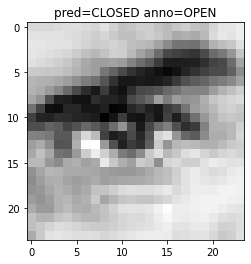

logits= tensor([[-2092.7803],
        [-3074.8279],
        [-2966.4993],
        [-3255.3259]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1.], device='cuda:0')
361 75.0
logits= tensor([[-1913.9104],
        [-2048.6211],
        [-3899.2271],
        [-2489.5833],
        [-4342.2539],
        [-4472.8940],
        [-2092.7803],
        [-3970.7266],
        [-2519.8386],
        [-3255.3259],
        [-2464.6316],
        [-2664.8965],
        [-3626.2512],
        [-2703.8730],
        [-2869.3928],
        [-1993.4535]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.],
       device='cuda:0')
362 43.75
logits= tensor([[-2966.4993],
        [-4247.5254],
     

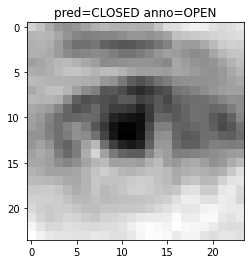

logits= tensor([[-2966.4993],
        [-4247.5254],
        [-2519.8386],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 0.], device='cuda:0')
371 50.0
logits= tensor([[-3255.3259],
        [-3074.8279],
        [-2489.5833],
        [-2092.7803],
        [-4247.5254],
        [-2519.8386],
        [-4472.8940],
        [-3899.2271],
        [-1913.9104],
        [-2703.8730],
        [-2966.4993],
        [-3970.7266],
        [-1993.4535],
        [-2464.6316],
        [-2048.6211],
        [-3626.2512]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.],
       device='cuda:0')
372 43.75
logits= tensor([[-2664.8965],
        [-2583.7954],
     

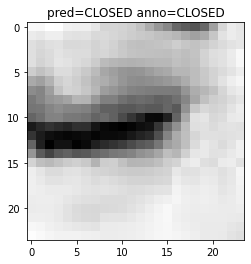

logits= tensor([[-3626.2512],
        [-1993.4535],
        [-3074.8279],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 1., 0.], device='cuda:0')
381 75.0
logits= tensor([[-1913.9104],
        [-4472.8940],
        [-3970.7266],
        [-2048.6211],
        [-4342.2539],
        [-2092.7803],
        [-2489.5833],
        [-1993.4535],
        [-2519.8386],
        [-4247.5254],
        [-2966.4993],
        [-2583.7954],
        [-2664.8965],
        [-2869.3928],
        [-2464.6316],
        [-3255.3259]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       device='cuda:0')
382 50.0
logits= tensor([[-3074.8279],
        [-3899.2271],
      

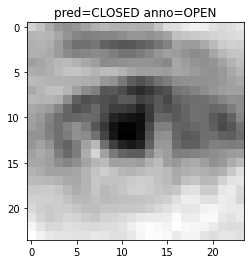

logits= tensor([[-1913.9104],
        [-3970.7266],
        [-2092.7803],
        [-1993.4535]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1.], device='cuda:0')
391 25.0
logits= tensor([[-4472.8940],
        [-3074.8279],
        [-3970.7266],
        [-2519.8386],
        [-1993.4535],
        [-3626.2512],
        [-3899.2271],
        [-2489.5833],
        [-2703.8730],
        [-2664.8965],
        [-2464.6316],
        [-2583.7954],
        [-2092.7803],
        [-2869.3928],
        [-1913.9104],
        [-4342.2539]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
       device='cuda:0')
392 43.75
logits= tensor([[-2966.4993],
        [-2048.6211],
     

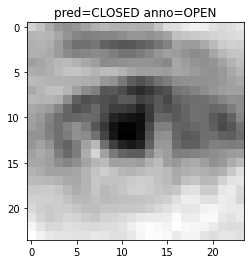

logits= tensor([[-1913.9104],
        [-2583.7954],
        [-3970.7266],
        [-2489.5833]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 0.], device='cuda:0')
401 25.0
logits= tensor([[-2464.6316],
        [-3899.2271],
        [-2092.7803],
        [-2519.8386],
        [-4342.2539],
        [-4472.8940],
        [-3970.7266],
        [-3626.2512],
        [-2583.7954],
        [-2489.5833],
        [-1913.9104],
        [-1993.4535],
        [-2869.3928],
        [-4247.5254],
        [-3255.3259],
        [-2048.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1.],
       device='cuda:0')
402 43.75
logits= tensor([[-2966.4993],
        [-2664.8965],
     

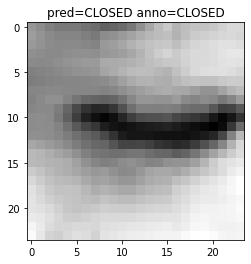

logits= tensor([[-2092.7803],
        [-1913.9104],
        [-2464.6316],
        [-4247.5254]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 0.], device='cuda:0')
411 0.0
logits= tensor([[-2869.3928],
        [-2464.6316],
        [-3626.2512],
        [-2966.4993],
        [-4472.8940],
        [-2519.8386],
        [-3899.2271],
        [-2048.6211],
        [-3255.3259],
        [-2092.7803],
        [-2489.5833],
        [-1913.9104],
        [-4247.5254],
        [-2583.7954],
        [-4342.2539],
        [-2664.8965]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.],
       device='cuda:0')
412 50.0
logits= tensor([[-3970.7266],
        [-3074.8279],
       

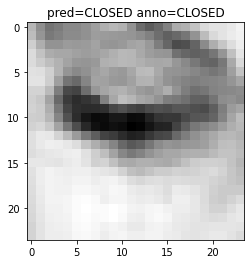

logits= tensor([[-3970.7266],
        [-2519.8386],
        [-3626.2512],
        [-2966.4993]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1.], device='cuda:0')
421 75.0
logits= tensor([[-3970.7266],
        [-3899.2271],
        [-1913.9104],
        [-2869.3928],
        [-2092.7803],
        [-1993.4535],
        [-4342.2539],
        [-3255.3259],
        [-2519.8386],
        [-2664.8965],
        [-2703.8730],
        [-4247.5254],
        [-2489.5833],
        [-2048.6211],
        [-3074.8279],
        [-2966.4993]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       device='cuda:0')
422 50.0
logits= tensor([[-3626.2512],
        [-4472.8940],
      

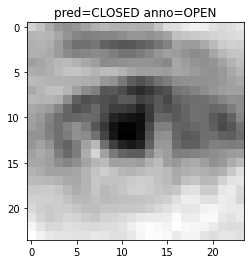

logits= tensor([[-2869.3928],
        [-4247.5254],
        [-2464.6316],
        [-2489.5833]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 0.], device='cuda:0')
431 25.0
logits= tensor([[-3255.3259],
        [-4342.2539],
        [-4247.5254],
        [-2464.6316],
        [-3899.2271],
        [-2664.8965],
        [-2519.8386],
        [-2092.7803],
        [-2869.3928],
        [-3074.8279],
        [-2489.5833],
        [-4472.8940],
        [-3970.7266],
        [-2583.7954],
        [-1993.4535],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.],
       device='cuda:0')
432 43.75
logits= tensor([[-3626.2512],
        [-2966.4993],
     

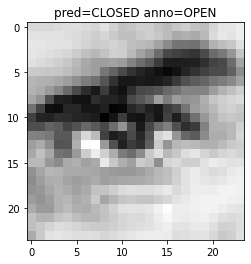

logits= tensor([[-2703.8730],
        [-3899.2271],
        [-3970.7266],
        [-2869.3928]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 1.], device='cuda:0')
441 25.0
logits= tensor([[-2703.8730],
        [-3074.8279],
        [-2869.3928],
        [-3899.2271],
        [-4342.2539],
        [-2583.7954],
        [-2519.8386],
        [-3255.3259],
        [-3970.7266],
        [-1993.4535],
        [-2048.6211],
        [-2092.7803],
        [-3626.2512],
        [-4472.8940],
        [-2464.6316],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0')
442 50.0
logits= tensor([[-2664.8965],
        [-2489.5833],
      

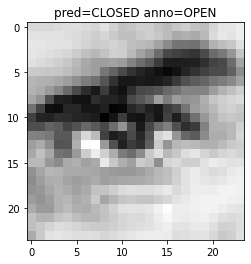

logits= tensor([[-3970.7266],
        [-1913.9104],
        [-2583.7954],
        [-2048.6211]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
451 50.0
logits= tensor([[-1913.9104],
        [-4247.5254],
        [-2048.6211],
        [-1993.4535],
        [-2583.7954],
        [-3626.2512],
        [-3074.8279],
        [-2664.8965],
        [-2092.7803],
        [-2869.3928],
        [-2489.5833],
        [-2966.4993],
        [-2464.6316],
        [-4472.8940],
        [-4342.2539],
        [-3255.3259]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       device='cuda:0')
452 56.25
logits= tensor([[-2703.8730],
        [-2519.8386],
     

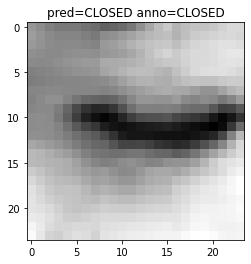

logits= tensor([[-3626.2512],
        [-2583.7954],
        [-2464.6316],
        [-2092.7803]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0.], device='cuda:0')
461 50.0
logits= tensor([[-2092.7803],
        [-1913.9104],
        [-4342.2539],
        [-2464.6316],
        [-4472.8940],
        [-2048.6211],
        [-2489.5833],
        [-2869.3928],
        [-4247.5254],
        [-3899.2271],
        [-2519.8386],
        [-1993.4535],
        [-2583.7954],
        [-3074.8279],
        [-2664.8965],
        [-3970.7266]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.],
       device='cuda:0')
462 43.75
logits= tensor([[-2703.8730],
        [-2966.4993],
     

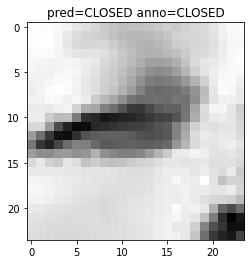

logits= tensor([[-4342.2539],
        [-2048.6211],
        [-3255.3259],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 1.], device='cuda:0')
471 75.0
logits= tensor([[-2519.8386],
        [-3970.7266],
        [-2869.3928],
        [-3626.2512],
        [-2048.6211],
        [-3255.3259],
        [-2583.7954],
        [-2664.8965],
        [-1993.4535],
        [-3899.2271],
        [-2489.5833],
        [-2092.7803],
        [-4247.5254],
        [-2464.6316],
        [-3074.8279],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')
472 56.25
logits= tensor([[-2966.4993],
        [-2703.8730],
     

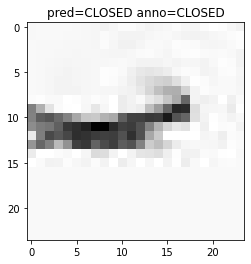

logits= tensor([[-3074.8279],
        [-1993.4535],
        [-4247.5254],
        [-2869.3928]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 1.], device='cuda:0')
481 75.0
logits= tensor([[-3970.7266],
        [-1993.4535],
        [-2519.8386],
        [-3899.2271],
        [-2966.4993],
        [-1913.9104],
        [-4342.2539],
        [-2489.5833],
        [-2869.3928],
        [-2583.7954],
        [-3626.2512],
        [-2464.6316],
        [-4247.5254],
        [-2092.7803],
        [-3074.8279],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.],
       device='cuda:0')
482 43.75
logits= tensor([[-2048.6211],
        [-2703.8730],
     

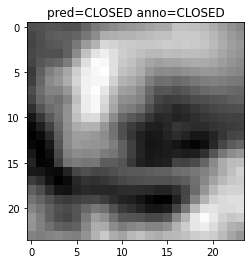

logits= tensor([[-2092.7803],
        [-2664.8965],
        [-4472.8940],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 1., 0., 1.], device='cuda:0')
491 50.0
logits= tensor([[-3074.8279],
        [-2583.7954],
        [-2703.8730],
        [-2092.7803],
        [-2489.5833],
        [-3626.2512],
        [-4247.5254],
        [-3970.7266],
        [-2664.8965],
        [-4472.8940],
        [-4342.2539],
        [-3255.3259],
        [-3899.2271],
        [-2048.6211],
        [-1993.4535],
        [-2519.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
       device='cuda:0')
492 50.0
logits= tensor([[-2966.4993],
        [-2464.6316],
      

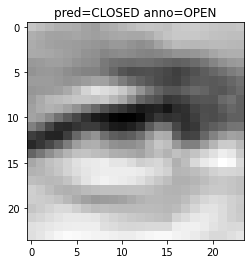

logits= tensor([[-2464.6316],
        [-2703.8730],
        [-2966.4993],
        [-3074.8279]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 1.], device='cuda:0')
501 50.0
logits= tensor([[-2048.6211],
        [-2092.7803],
        [-1993.4535],
        [-3074.8279],
        [-2519.8386],
        [-3899.2271],
        [-3970.7266],
        [-4342.2539],
        [-1913.9104],
        [-2869.3928],
        [-3626.2512],
        [-2664.8965],
        [-2489.5833],
        [-2703.8730],
        [-4472.8940],
        [-3255.3259]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
       device='cuda:0')
502 50.0
logits= tensor([[-2966.4993],
        [-2583.7954],
      

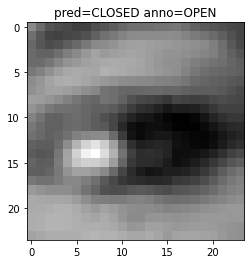

logits= tensor([[-2869.3928],
        [-2966.4993],
        [-2489.5833],
        [-1913.9104]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0.], device='cuda:0')
511 50.0
logits= tensor([[-2048.6211],
        [-3074.8279],
        [-2489.5833],
        [-4247.5254],
        [-3255.3259],
        [-2869.3928],
        [-3626.2512],
        [-1913.9104],
        [-2092.7803],
        [-2703.8730],
        [-4342.2539],
        [-2519.8386],
        [-2464.6316],
        [-2583.7954],
        [-2966.4993],
        [-3899.2271]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
       device='cuda:0')
512 50.0
logits= tensor([[-3970.7266],
        [-2664.8965],
      

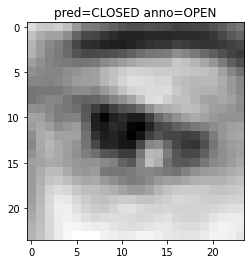

logits= tensor([[-4247.5254],
        [-1913.9104],
        [-2664.8965],
        [-2464.6316]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([0., 0., 1., 0.], device='cuda:0')
521 25.0
logits= tensor([[-1993.4535],
        [-2092.7803],
        [-2048.6211],
        [-3626.2512],
        [-2869.3928],
        [-4247.5254],
        [-4472.8940],
        [-2583.7954],
        [-2664.8965],
        [-3970.7266],
        [-3255.3259],
        [-3074.8279],
        [-2519.8386],
        [-2703.8730],
        [-1913.9104],
        [-2464.6316]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0')
522 56.25
logits= tensor([[-3899.2271],
        [-2966.4993],
     

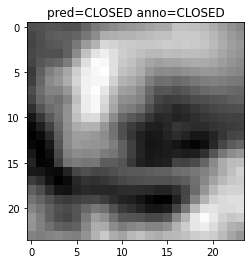

logits= tensor([[-3255.3259],
        [-2664.8965],
        [-4472.8940],
        [-3074.8279]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 1.], device='cuda:0')
531 75.0
logits= tensor([[-3074.8279],
        [-2519.8386],
        [-2092.7803],
        [-2703.8730],
        [-3626.2512],
        [-3970.7266],
        [-2869.3928],
        [-1913.9104],
        [-2489.5833],
        [-2664.8965],
        [-4342.2539],
        [-2048.6211],
        [-1993.4535],
        [-4247.5254],
        [-2583.7954],
        [-4472.8940]], device='cuda:0', grad_fn=<AddmmBackward>)
pred_batch= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
anno_batch= tensor([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       device='cuda:0')
532 50.0
logits= tensor([[-3899.2271],
        [-2966.4993],
      

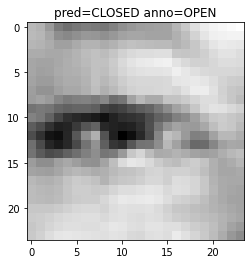

In [ ]:
class ClassifierTrainer:
    def __init__(self):
        self.model = Classifier(latent_size)
        self.model.cuda()

    def train(self):
        with open("annotation.json", "r") as f:
            dataset = json.load(f)
        flat_list = []
        for label, lst in dataset.items():
            if label == "open":
                for name in lst:
                    flat_list.append(("train/"+name, 1))
            else:
                for name in lst:
                    flat_list.append(("train/"+name, 0))
        image_list, filenames = load_archive()
        name_to_image = dict(zip(filenames, image_list))
        anno_images = []
        for anno_name, anno_label in flat_list:
            if anno_name in name_to_image:
                anno_images.append(name_to_image[anno_name])
            else:
                print("Warning: file not found")
        images_np = np.array(anno_images)
        images_np = np.expand_dims(images_np, 1)
        anno_np = np.array([v[1] for v in flat_list])
        dataset = torch.utils.data.TensorDataset(
            torch.tensor(images_np, dtype=torch.float32),
            torch.tensor(anno_np, dtype=torch.float32))
        
        loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=True, num_workers=0)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        
        num_iters = 1_000
        i_iter = 0
        while i_iter < num_iters:
            for i_batch, (image_batch, anno_batch) in enumerate(loader):
                image_batch = image_batch.cuda()
                anno_batch = anno_batch.cuda()
                pred_batch = self.model(image_batch)
                optimizer.zero_grad()
                print("pred_batch=", pred_batch)
                print("anno_batch=", anno_batch)
                loss = F.binary_cross_entropy(pred_batch, anno_batch)
                loss.backward()
                print(i_iter, loss.item())
                optimizer.step()
                if i_iter % 10 == 0:
                    sample_idx = 0
                    plt.imshow(image_batch[sample_idx, 0, ...].detach().cpu().numpy(), cmap='gray')
                    def to_text(flag):
                        return "OPEN" if flag else "CLOSED"
                    plt.title("pred=" + to_text(pred_batch[sample_idx]) + \
                              " anno=" + to_text(anno_batch[sample_idx]))
                    plt.show()
                    torch.save(self.model.state_dict(), "classifier.pth")
                i_iter += 1
    
class_trainer = ClassifierTrainer()
class_trainer.train()